In [1]:
# Python Libraries
%matplotlib inline
import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras import backend as K
import cv2
from scipy.ndimage import gaussian_filter

# Custom Networks
from networks.lenet import LeNet
from networks.resnet import ResNet
from networks.pure_cnn import PureCnn
from networks.network_in_network import NetworkInNetwork
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet
from networks.capsnet import CapsNet

# Helper functions
from differential_evolution import differential_evolution
import helper

matplotlib.style.use('ggplot')
np.random.seed(100)

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
# Custom Networks
from networks.lenet import LeNet
from networks.resnet import ResNet

lenet = LeNet()
resnet = ResNet()

models = [lenet]

# Uncomment below to load more models to play with. Make sure the model files exist by training or downloading them.

# lenet = LeNet()
# pure_cnn = PureCnn()
# net_in_net = NetworkInNetwork()
# resnet = ResNet()
# densenet = DenseNet()
# wide_resnet = WideResNet()
# capsnet = CapsNet()

# models = [lenet, pure_cnn, net_in_net, resnet, densenet, wide_resnet, capsnet]

Successfully loaded lenet
Successfully loaded resnet


In [4]:
network_stats, correct_imgs = helper.evaluate_models(models, x_test, y_test)
correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy', 'param_count'])

network_stats

Evaluating lenet
79/79 [==============================] - 0s 2ms/step


name  accuracy  param_count
0  lenet    0.7488        62006

In [5]:
def perturb_image(xs, img, sigma=0.7):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])

    # Copy the image n == len(xs) times so that we can
    # create n new perturbed images
    tile = [len(xs)] + [1] * (xs.ndim + 1)
    imgs = np.tile(img, tile)

    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)

    # Initialize an empty array to store the coordinates of the optimized pixels
    optimized_pixels = np.zeros((len(xs), xs.shape[1] // 5, 2), dtype=int)

    for i, (x, img) in enumerate(zip(xs, imgs)):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for j, pixel in enumerate(pixels):
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
            # Store the coordinates of the optimized pixels
            optimized_pixels[i, j] = [x_pos, y_pos]

            # Apply a Gaussian filter around the perturbed pixel
            # The filter size is determined by the sigma value
            x_min = max(0, x_pos - int(sigma * 3))
            x_max = min(img.shape[0], x_pos + int(sigma * 3) + 1)
            y_min = max(0, y_pos - int(sigma * 3))
            y_max = min(img.shape[1], y_pos + int(sigma * 3) + 1)
            img[x_min:x_max, y_min:y_max] = gaussian_filter(img[x_min:x_max, y_min:y_max], sigma=sigma)

    return imgs, optimized_pixels


In [6]:
def predict_classes(xs, img, target_class, model, minimize=True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    imgs_perturbed = perturb_image(xs, img)
    predictions = model.predict(imgs_perturbed[0])[:,target_class]
    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions

In [7]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_image = perturb_image(x, img)

    confidence = model.predict(attack_image[0])[0]
    predicted_class = np.argmax(confidence)
    
    # If the prediction is what we want (misclassification or 
    # targeted classification), return True
    if verbose:
        print('Confidence:', confidence[target_class])
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        return True
    # NOTE: return None otherwise (not False), due to how Scipy handles its callback function

In [8]:
def average_color_neighborhood(img, x, y, neighborhood_size=1):
    x_min = max(0, x - neighborhood_size)
    x_max = min(img.shape[0], x + neighborhood_size + 1)
    y_min = max(0, y - neighborhood_size)
    y_max = min(img.shape[1], y + neighborhood_size + 1)

    neighborhood = img[x_min:x_max, y_min:y_max]
    return np.mean(neighborhood, axis=(0, 1))


In [9]:
def attack(img_id, model, target=None, pixel_count=1, 
           maxiter=75, popsize=400, verbose=False):
    # Change the target class based on whether this is a targeted attack or not
    targeted_attack = target is not None
    target_class = target if targeted_attack else y_test[img_id, 0]
    
#     Define bounds for a flat vector of x,y,r,g,b values
#     For more pixels, repeat this layout
#     bounds = [(0,32), (0,32), (0,128), (0,128), (0,128)] * pixel_count

    bounds = []
    neighborhood_size = 1  # Define the size of the neighborhood (1 means directly neighboring pixels)
    for _ in range(pixel_count):
        bounds.extend([(0, 32), (0, 32)])
        x, y = np.random.randint(0, 32, size=2)  # Randomly choose a pixel location
        avg_color = average_color_neighborhood(x_test[img_id], x, y, neighborhood_size)
        color_bounds = [(max(0, color - 10), min(255, color + 10)) for color in avg_color]  # Adjust color range here
        bounds.extend(color_bounds)
    
    
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    
    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(xs):
        return predict_classes(xs, x_test[img_id], target_class, 
                               model, target is None)
    
    def callback_fn(x, convergence):
        return attack_success(x, x_test[img_id], target_class, 
                              model, targeted_attack, verbose)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)

    # Calculate some useful statistics to return from this function
#     attack_image = perturb_image(attack_result.x, x_test[img_id])[0]
    attack_image = perturb_image(attack_result.x, x_test[img_id])[0]
    attack_image_smoothed = gaussian_filter(attack_image, sigma=0.1)
    prior_probs = model.predict_one(x_test[img_id])
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img_id, 0]
    success = predicted_class != actual_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    perturb_pixels = perturb_image(attack_result.x, x_test[img_id])[1]
    
    # Show the best attempt at a solution (successful or not)
#     helper.plot_image(attack_image, actual_class, class_names, predicted_class)
    helper.plot_image(attack_image_smoothed, actual_class, class_names, predicted_class)
    
#     return [perturb_pixels, model.name, pixel_count, img_id, actual_class, predicted_class,
#             success, cdiff, prior_probs, predicted_probs, attack_result.x]
    return [model.name, pixel_count, img_id, actual_class, predicted_class,
            success, cdiff, prior_probs, predicted_probs, attack_result.x]

1/1 [==============================] - 0s 30ms/step
Confidence: 0.8307992
1/1 [==============================] - 0s 31ms/step
Confidence: 0.8307992
1/1 [==============================] - 0s 54ms/step
Confidence: 0.8307992
1/1 [==============================] - 0s 25ms/step
Confidence: 0.78614783
1/1 [==============================] - 0s 27ms/step
Confidence: 0.004439284
1/1 [==============================] - 0s 31ms/step


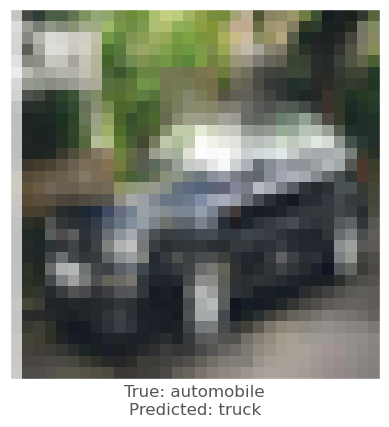

Actual Class: 9
Predicted Class True
The Spatial Values of Pixels:


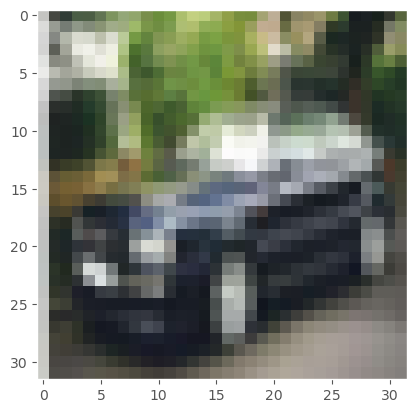

In [10]:
# No: 1, 3: Calculate the confidence values
# Yes: 118, 169, 2978, 658, 1001, 1116

image_id = 1115
pixels = 20 # Number of pixels to attack
model = resnet

_ = attack(image_id, model, pixel_count=pixels, verbose=True)
print("Actual Class:", _[4])
print("Predicted Class", _[5])
print("The Spatial Values of Pixels:")
perturbed_pixels = _[0]
# print(perturbed_pixels)
plt.imshow(x_test[image_id])
plt.grid(False)

In [11]:
def attack_all(models, samples=500, pixels=(1,5,10,20), targeted=False, 
               maxiter=75, popsize=400, verbose=False):
    results = []
    for model in models:
        model_results = []
        valid_imgs = correct_imgs[correct_imgs.name == model.name].img
        img_samples = np.random.choice(valid_imgs, samples, replace=False)
        
        for pixel_count in pixels:
            for i, img_id in enumerate(img_samples):
                print('\n', model.name, '- image', img_id, '-', i+1, '/', len(img_samples))
                targets = [None] if not targeted else range(10)
                
                for target in targets:
                    if targeted:
                        print('Attacking with target', class_names[target])
                        if target == y_test[img_id, 0]:
                            continue
                    result = attack(img_id, model, target, pixel_count, 
                                    maxiter=maxiter, popsize=popsize, 
                                    verbose=verbose)
                    model_results.append(result)
                    
        results += model_results
        helper.checkpoint(results, targeted)
    return results


 lenet - image 9263 - 1 / 90
1/1 [==============================] - 0s 22ms/step


C:\Users\ashta\Downloads\one-pixel-attack-keras-master\differential_evolution.py:586: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


1/1 [==============================] - 0s 24ms/step


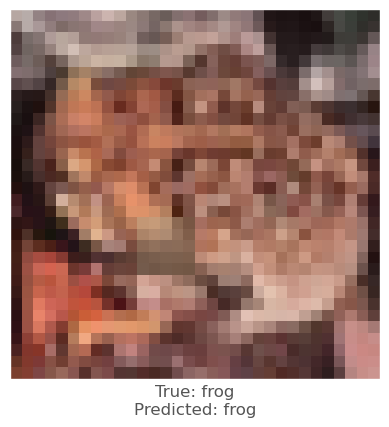


 lenet - image 6249 - 2 / 90
1/1 [==============================] - 0s 23ms/step


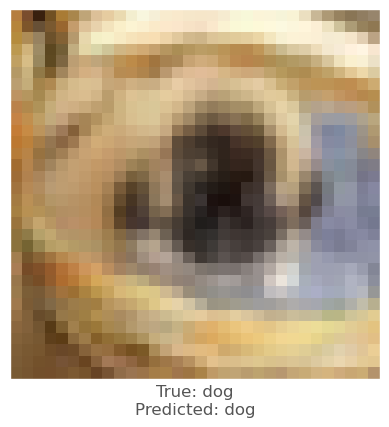


 lenet - image 3732 - 3 / 90
1/1 [==============================] - 0s 23ms/step


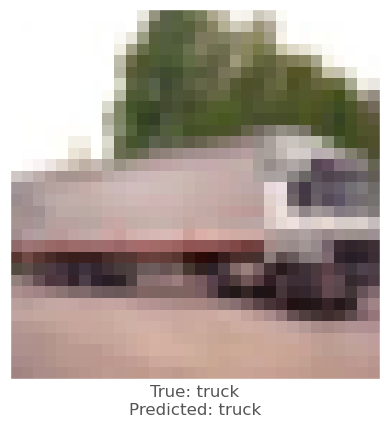


 lenet - image 8015 - 4 / 90
1/1 [==============================] - 0s 20ms/step


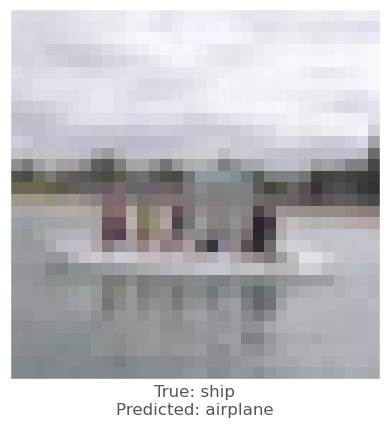


 lenet - image 4356 - 5 / 90
1/1 [==============================] - 0s 23ms/step


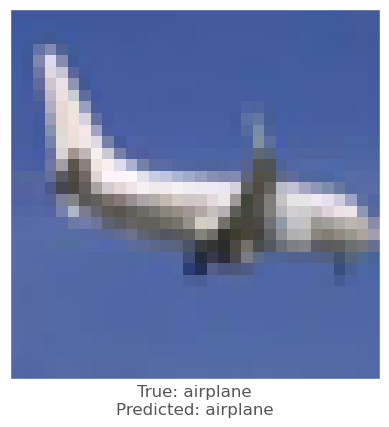


 lenet - image 4929 - 6 / 90
1/1 [==============================] - 0s 22ms/step


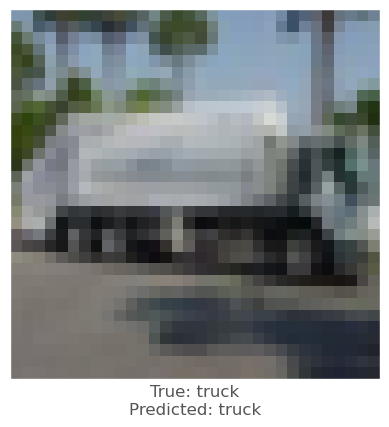


 lenet - image 2448 - 7 / 90
1/1 [==============================] - 0s 20ms/step


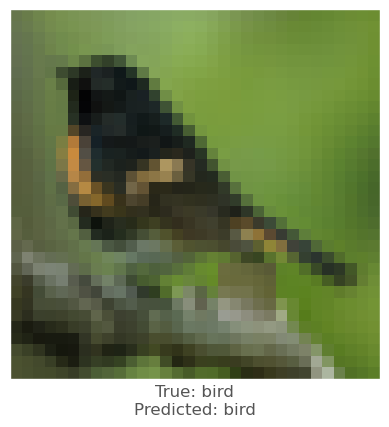


 lenet - image 1082 - 8 / 90
1/1 [==============================] - 0s 22ms/step


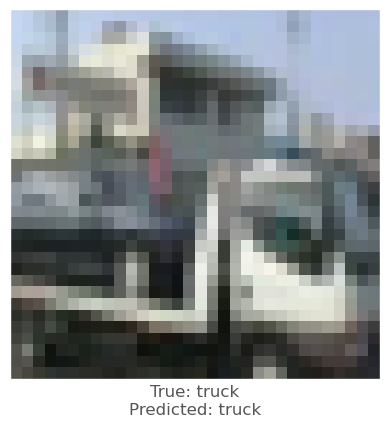


 lenet - image 6592 - 9 / 90
1/1 [==============================] - 0s 22ms/step


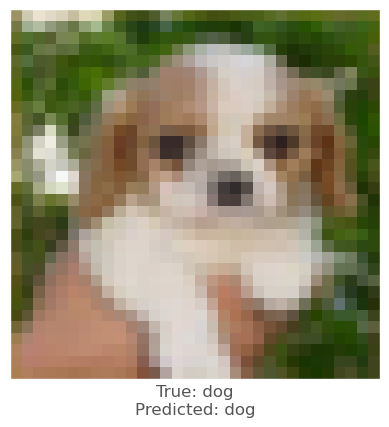


 lenet - image 8118 - 10 / 90
1/1 [==============================] - 0s 23ms/step


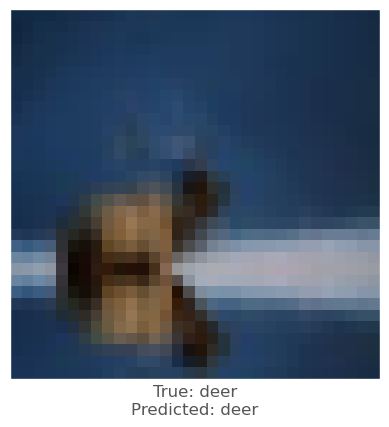


 lenet - image 4040 - 11 / 90
1/1 [==============================] - 0s 22ms/step


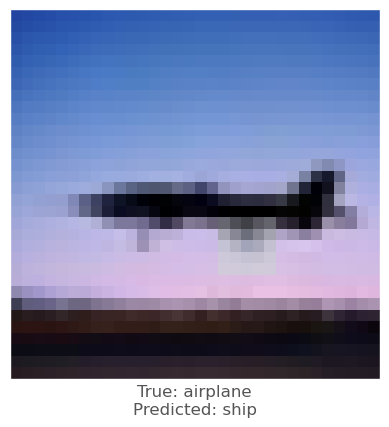


 lenet - image 4969 - 12 / 90
1/1 [==============================] - 0s 23ms/step


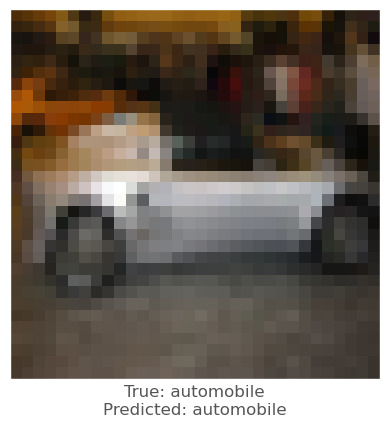


 lenet - image 4087 - 13 / 90
1/1 [==============================] - 0s 23ms/step


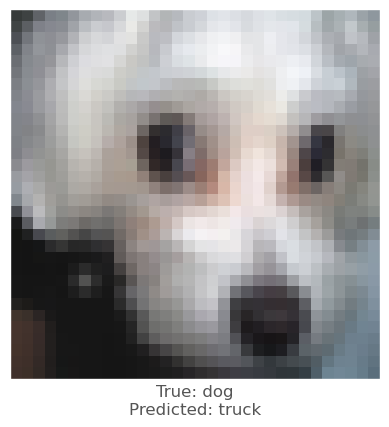


 lenet - image 1606 - 14 / 90
1/1 [==============================] - 0s 22ms/step


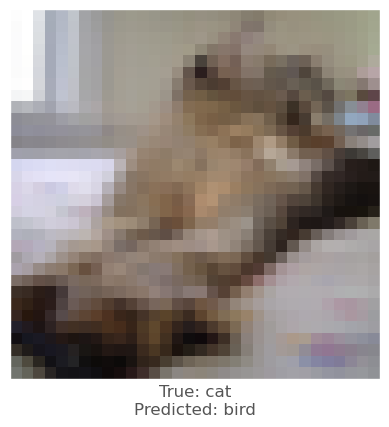


 lenet - image 8275 - 15 / 90
1/1 [==============================] - 0s 22ms/step


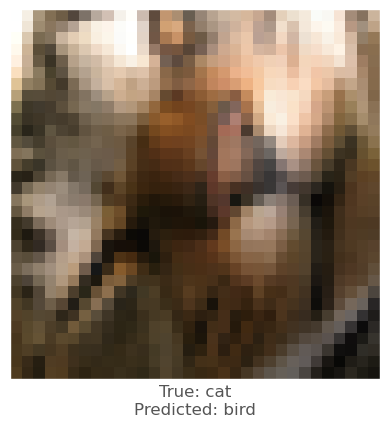


 lenet - image 4893 - 16 / 90
1/1 [==============================] - 0s 25ms/step


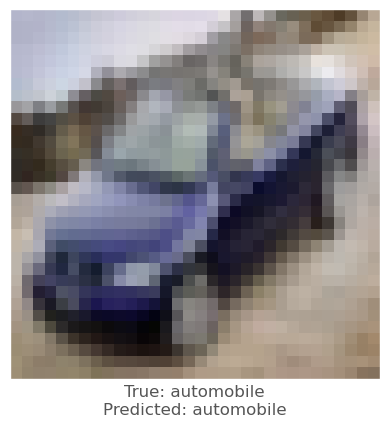


 lenet - image 6749 - 17 / 90
1/1 [==============================] - 0s 24ms/step


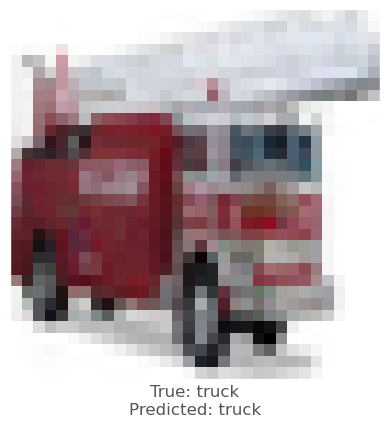


 lenet - image 1702 - 18 / 90
1/1 [==============================] - 0s 24ms/step


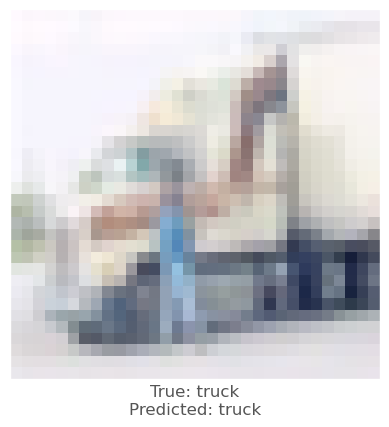


 lenet - image 662 - 19 / 90
1/1 [==============================] - 0s 22ms/step


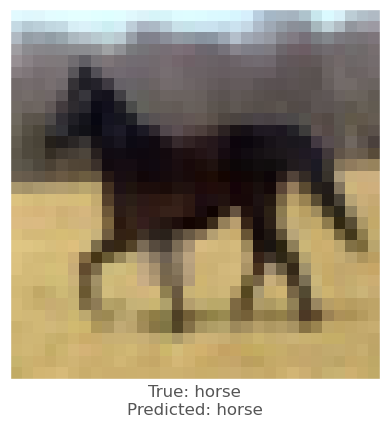


 lenet - image 379 - 20 / 90
1/1 [==============================] - 0s 21ms/step


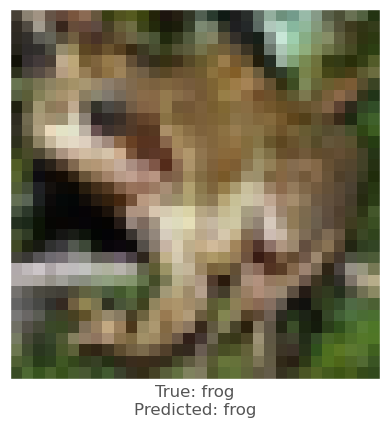


 lenet - image 8273 - 21 / 90
1/1 [==============================] - 0s 20ms/step


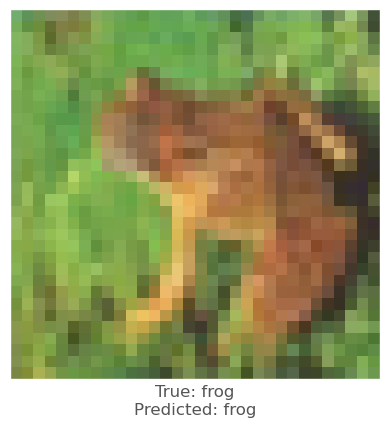


 lenet - image 7693 - 22 / 90
1/1 [==============================] - 0s 22ms/step


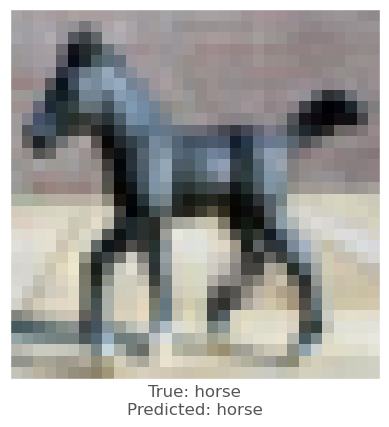


 lenet - image 8018 - 23 / 90
1/1 [==============================] - 0s 22ms/step


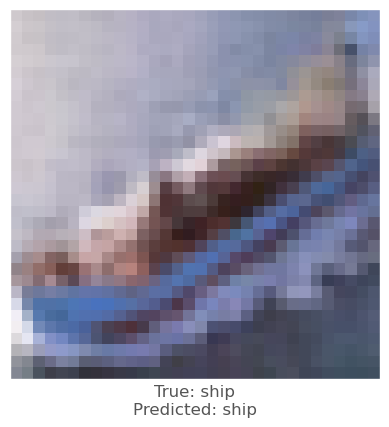


 lenet - image 1180 - 24 / 90
1/1 [==============================] - 0s 22ms/step


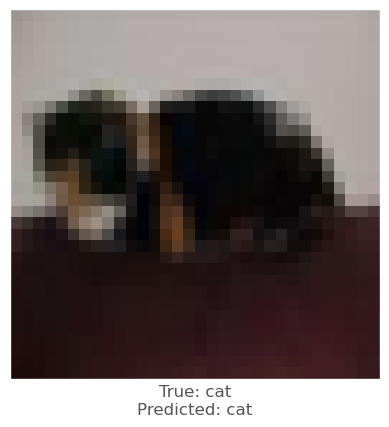


 lenet - image 5664 - 25 / 90
1/1 [==============================] - 0s 28ms/step


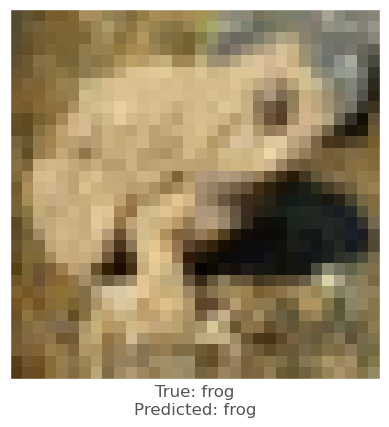


 lenet - image 4016 - 26 / 90
1/1 [==============================] - 0s 23ms/step


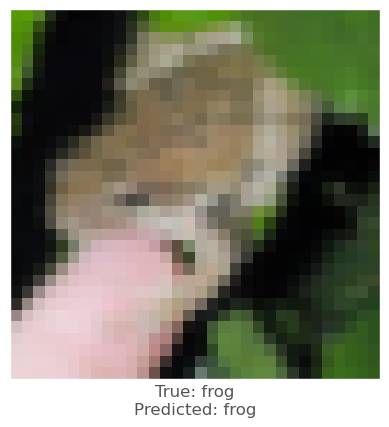


 lenet - image 6744 - 27 / 90
1/1 [==============================] - 0s 25ms/step


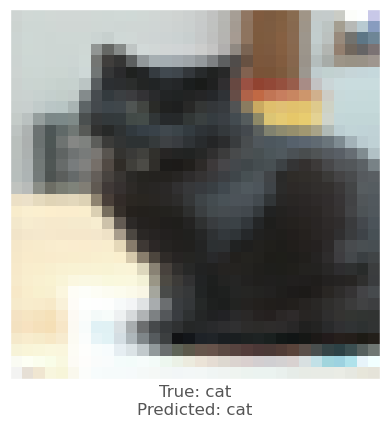


 lenet - image 3535 - 28 / 90
1/1 [==============================] - 0s 20ms/step


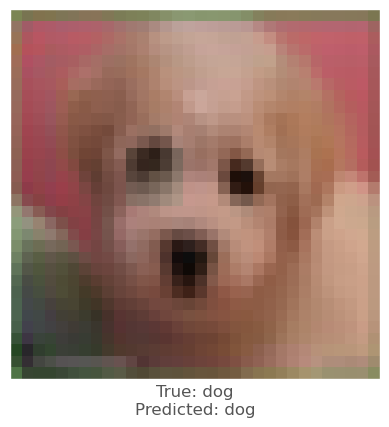


 lenet - image 8640 - 29 / 90
1/1 [==============================] - 0s 22ms/step


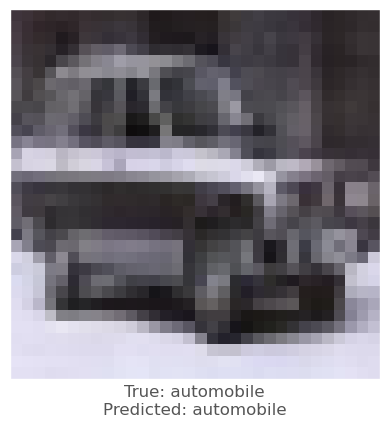


 lenet - image 6740 - 30 / 90
1/1 [==============================] - 0s 22ms/step


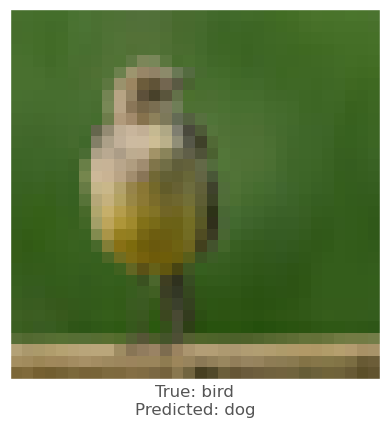


 lenet - image 7166 - 31 / 90
1/1 [==============================] - 0s 23ms/step


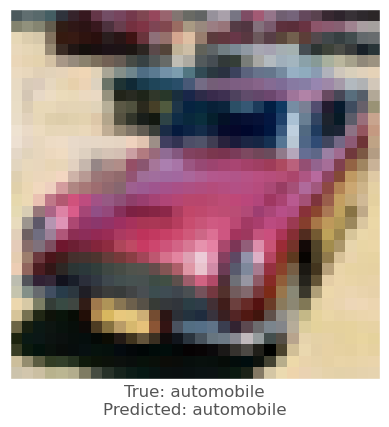


 lenet - image 2429 - 32 / 90
1/1 [==============================] - 0s 21ms/step


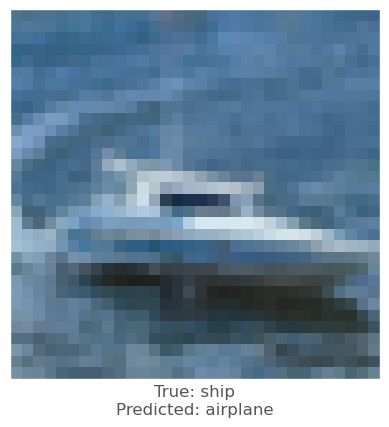


 lenet - image 9651 - 33 / 90
1/1 [==============================] - 0s 23ms/step


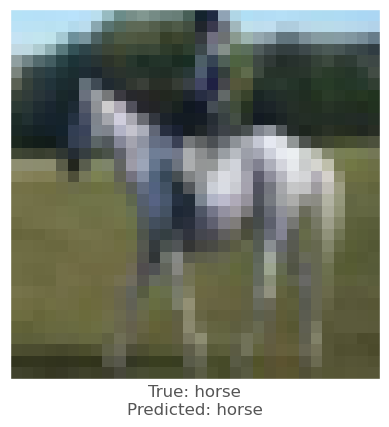


 lenet - image 3389 - 34 / 90
1/1 [==============================] - 0s 23ms/step


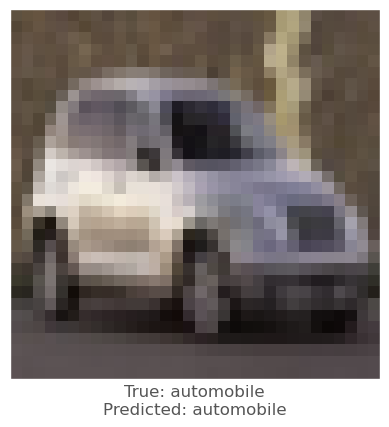


 lenet - image 5295 - 35 / 90
1/1 [==============================] - 0s 20ms/step


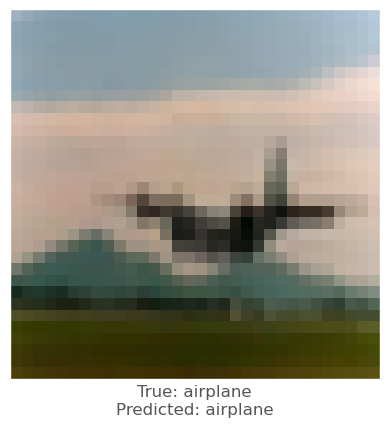


 lenet - image 3796 - 36 / 90
1/1 [==============================] - 0s 22ms/step


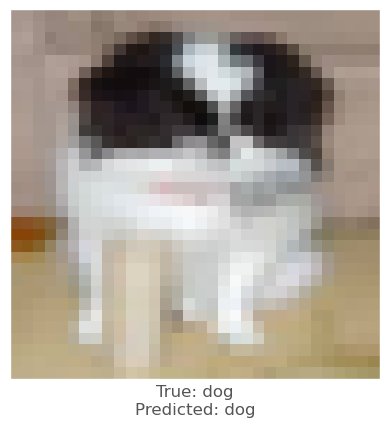


 lenet - image 7563 - 37 / 90
1/1 [==============================] - 0s 23ms/step


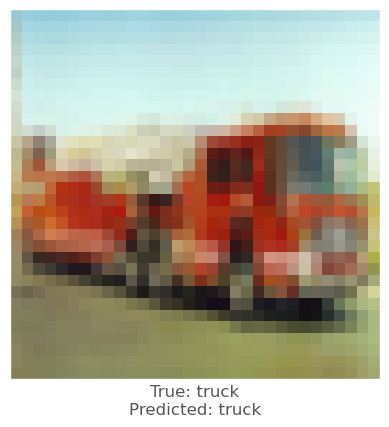


 lenet - image 2802 - 38 / 90
1/1 [==============================] - 0s 23ms/step


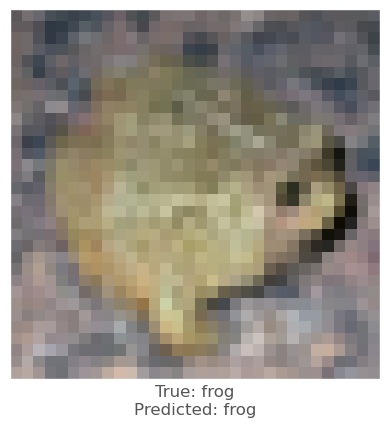


 lenet - image 5631 - 39 / 90
1/1 [==============================] - 0s 21ms/step


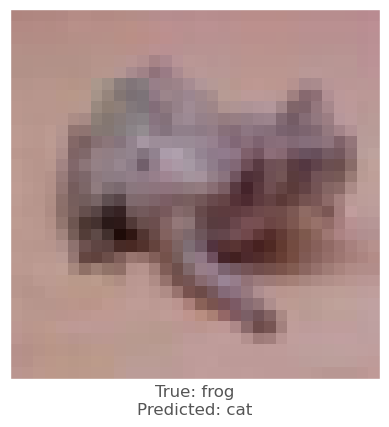


 lenet - image 7277 - 40 / 90
1/1 [==============================] - 0s 27ms/step


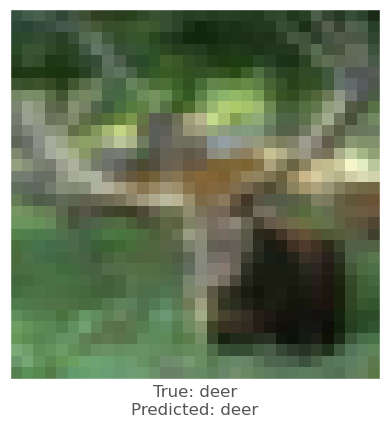


 lenet - image 5929 - 41 / 90
1/1 [==============================] - 0s 22ms/step


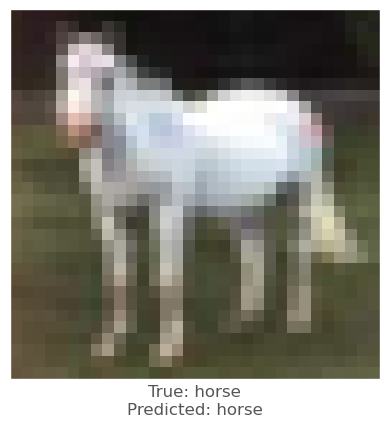


 lenet - image 8661 - 42 / 90
1/1 [==============================] - 0s 25ms/step


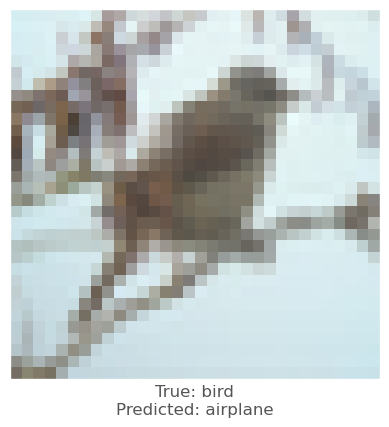


 lenet - image 7140 - 43 / 90
1/1 [==============================] - 0s 26ms/step


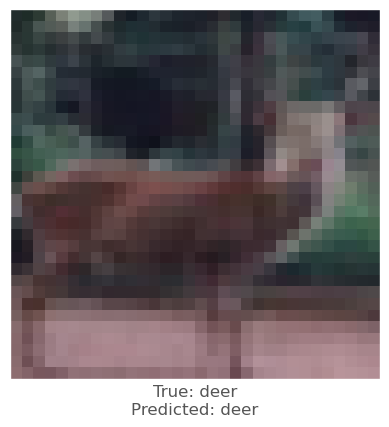


 lenet - image 1390 - 44 / 90
1/1 [==============================] - 0s 25ms/step


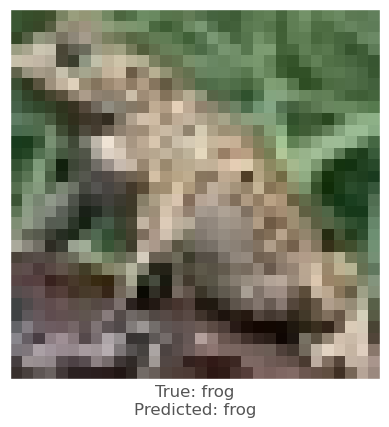


 lenet - image 6657 - 45 / 90
1/1 [==============================] - 0s 25ms/step


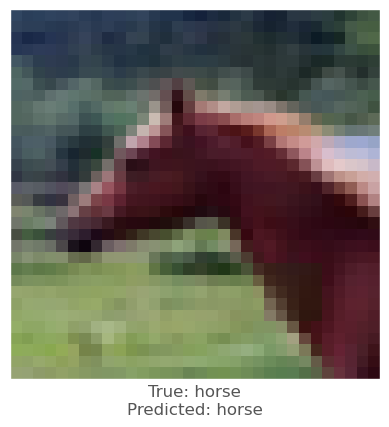


 lenet - image 9363 - 46 / 90
1/1 [==============================] - 0s 26ms/step


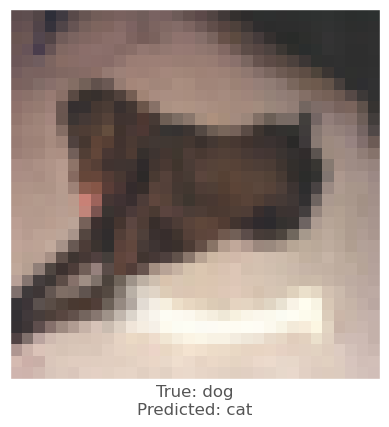


 lenet - image 6539 - 47 / 90
1/1 [==============================] - 0s 25ms/step


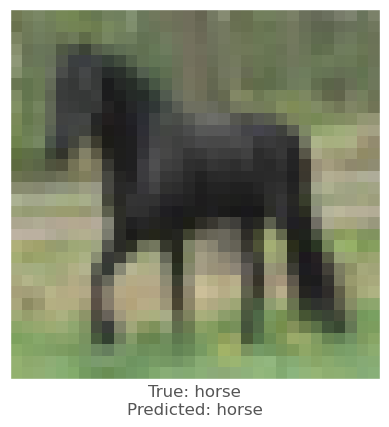


 lenet - image 2329 - 48 / 90
1/1 [==============================] - 0s 25ms/step


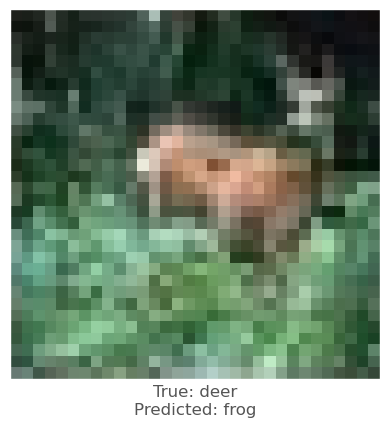


 lenet - image 2340 - 49 / 90
1/1 [==============================] - 0s 23ms/step


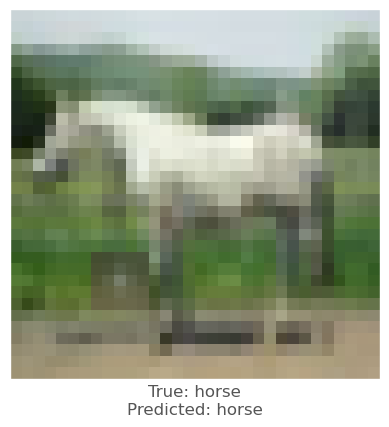


 lenet - image 7370 - 50 / 90
1/1 [==============================] - 0s 41ms/step


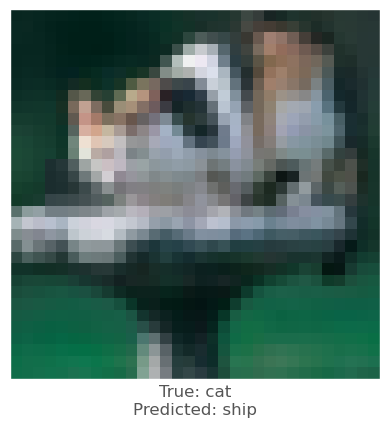


 lenet - image 4900 - 51 / 90
1/1 [==============================] - 0s 25ms/step


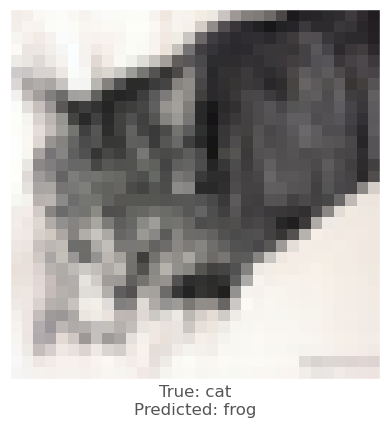


 lenet - image 2587 - 52 / 90
1/1 [==============================] - 0s 24ms/step


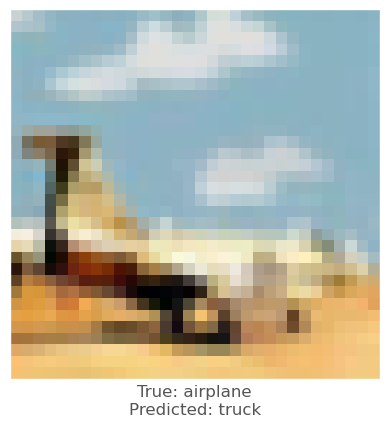


 lenet - image 5267 - 53 / 90
1/1 [==============================] - 0s 25ms/step


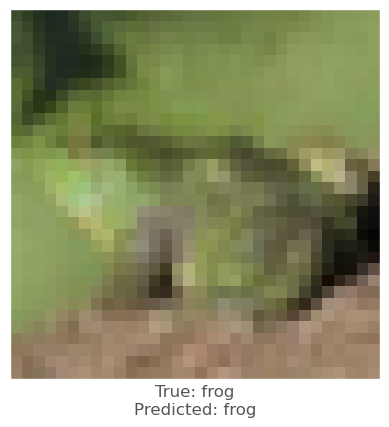


 lenet - image 1876 - 54 / 90
1/1 [==============================] - 0s 26ms/step


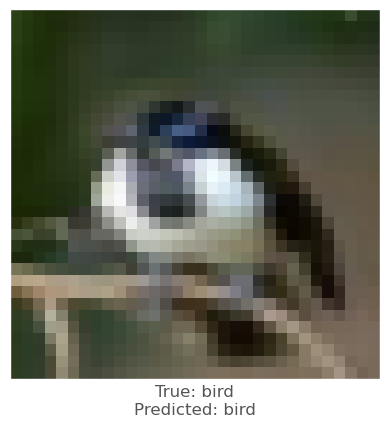


 lenet - image 7238 - 55 / 90
1/1 [==============================] - 0s 24ms/step


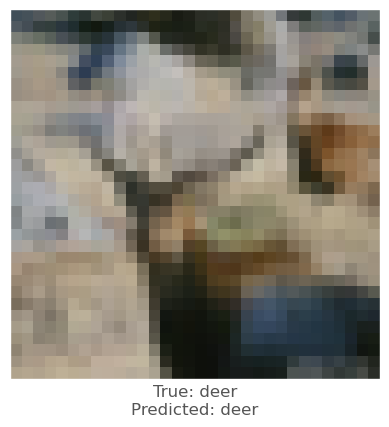


 lenet - image 1152 - 56 / 90
1/1 [==============================] - 0s 21ms/step


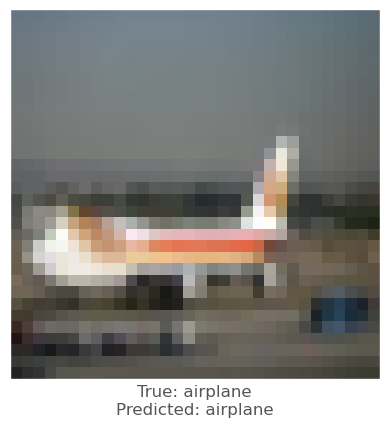


 lenet - image 1892 - 57 / 90
1/1 [==============================] - 0s 22ms/step


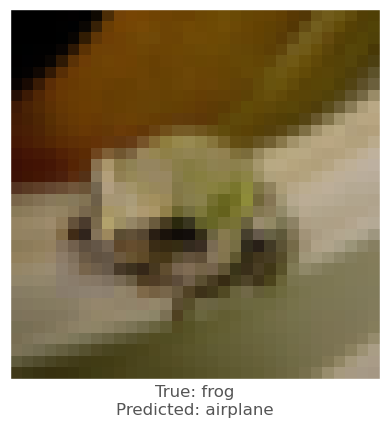


 lenet - image 1651 - 58 / 90
1/1 [==============================] - 0s 26ms/step


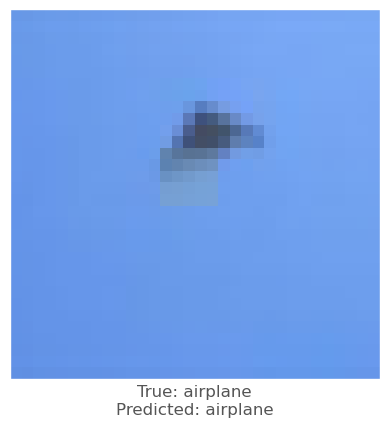


 lenet - image 2246 - 59 / 90
1/1 [==============================] - 0s 20ms/step


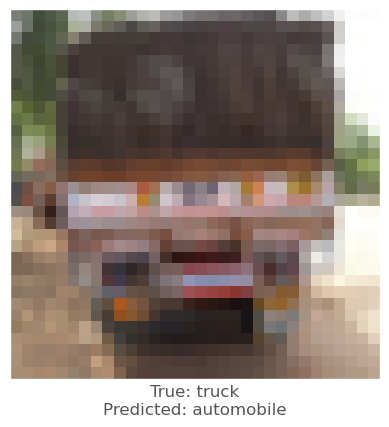


 lenet - image 0 - 60 / 90
1/1 [==============================] - 0s 22ms/step


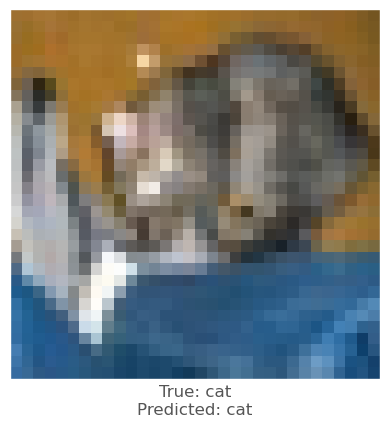


 lenet - image 3599 - 61 / 90
1/1 [==============================] - 0s 21ms/step


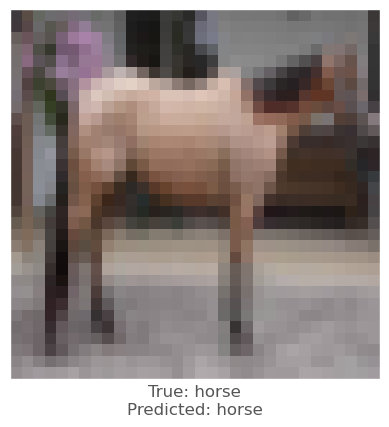


 lenet - image 8643 - 62 / 90
1/1 [==============================] - 0s 16ms/step


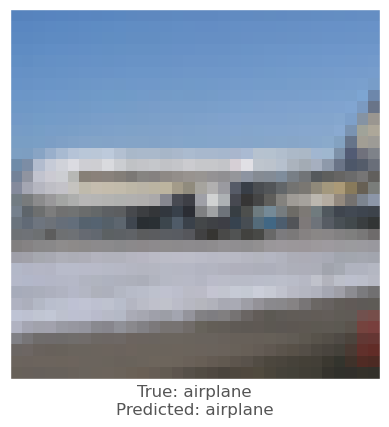


 lenet - image 8073 - 63 / 90
1/1 [==============================] - 0s 21ms/step


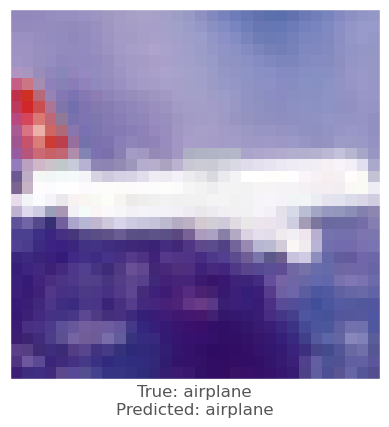


 lenet - image 1272 - 64 / 90
1/1 [==============================] - 0s 24ms/step


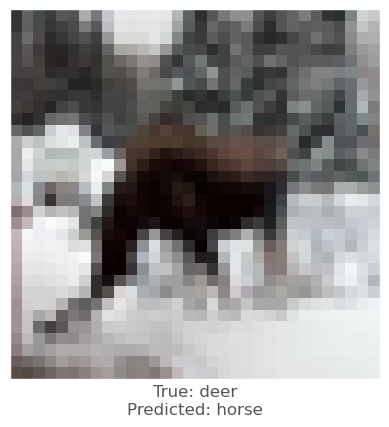


 lenet - image 4124 - 65 / 90
1/1 [==============================] - 0s 24ms/step


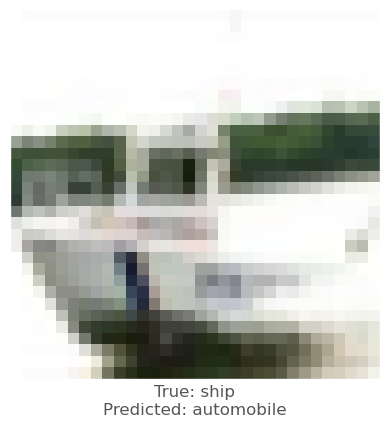


 lenet - image 1197 - 66 / 90
1/1 [==============================] - 0s 23ms/step


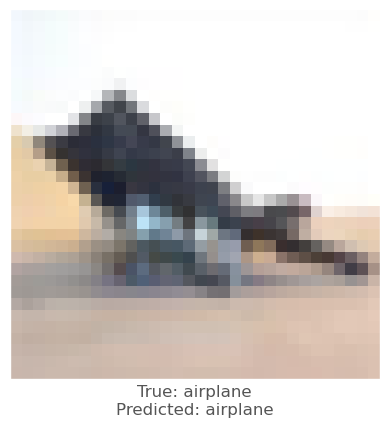


 lenet - image 8847 - 67 / 90
1/1 [==============================] - 0s 20ms/step


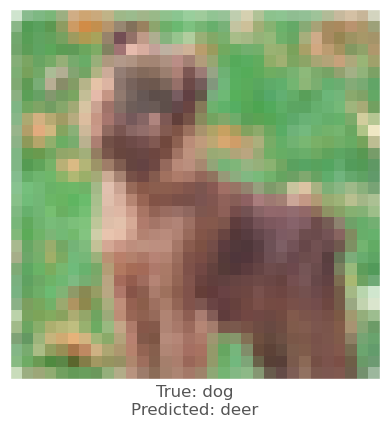


 lenet - image 3076 - 68 / 90
1/1 [==============================] - 0s 22ms/step


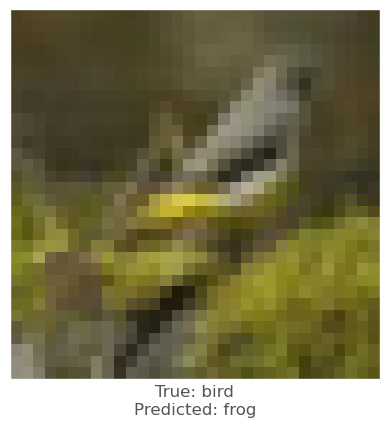


 lenet - image 6633 - 69 / 90
1/1 [==============================] - 0s 20ms/step


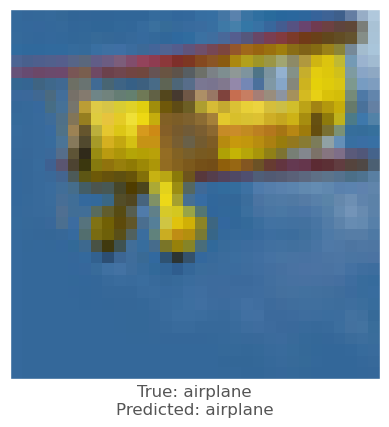


 lenet - image 331 - 70 / 90
1/1 [==============================] - 0s 22ms/step


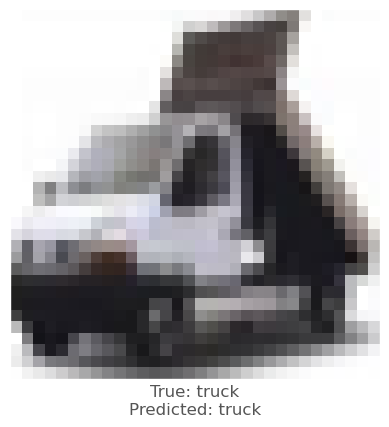


 lenet - image 4913 - 71 / 90
1/1 [==============================] - 0s 22ms/step


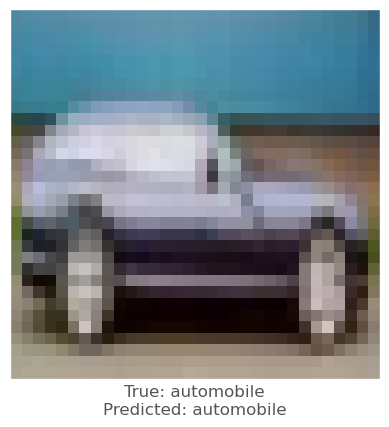


 lenet - image 8826 - 72 / 90
1/1 [==============================] - 0s 22ms/step


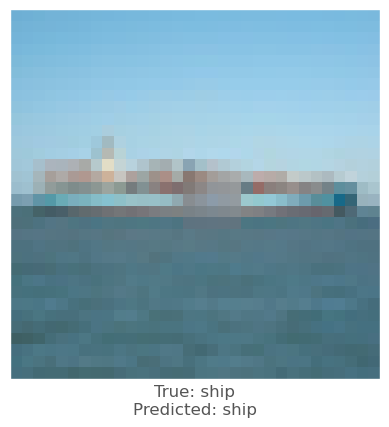


 lenet - image 5860 - 73 / 90
1/1 [==============================] - 0s 20ms/step


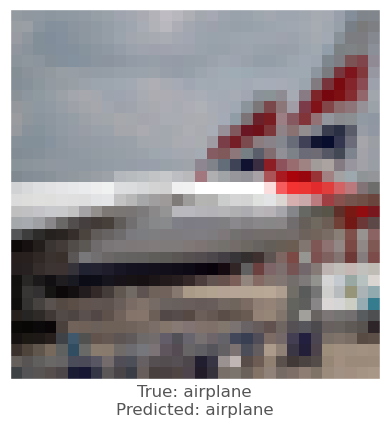


 lenet - image 1104 - 74 / 90
1/1 [==============================] - 0s 21ms/step


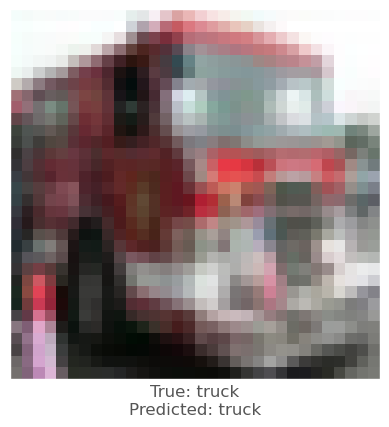


 lenet - image 6472 - 75 / 90
1/1 [==============================] - 0s 21ms/step


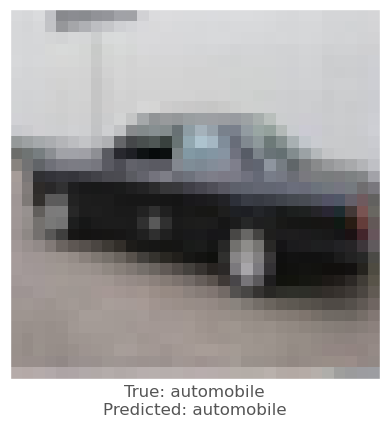


 lenet - image 9977 - 76 / 90
1/1 [==============================] - 0s 21ms/step


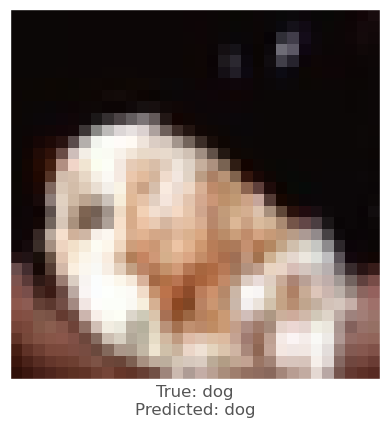


 lenet - image 4098 - 77 / 90
1/1 [==============================] - 0s 23ms/step


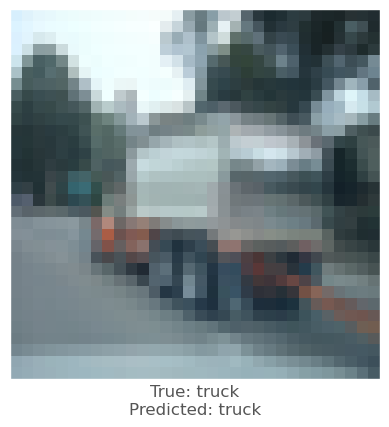


 lenet - image 5140 - 78 / 90
1/1 [==============================] - 0s 23ms/step


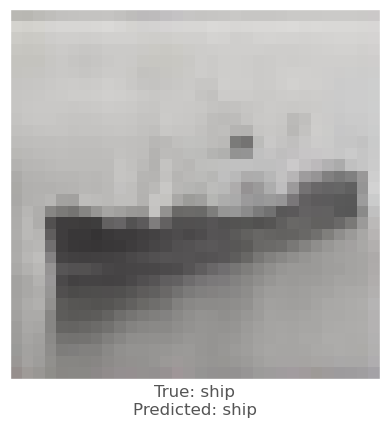


 lenet - image 8112 - 79 / 90
1/1 [==============================] - 0s 23ms/step


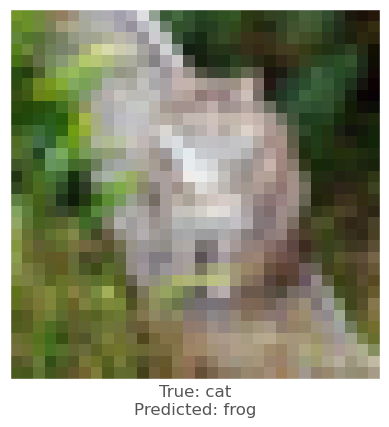


 lenet - image 5798 - 80 / 90
1/1 [==============================] - 0s 23ms/step


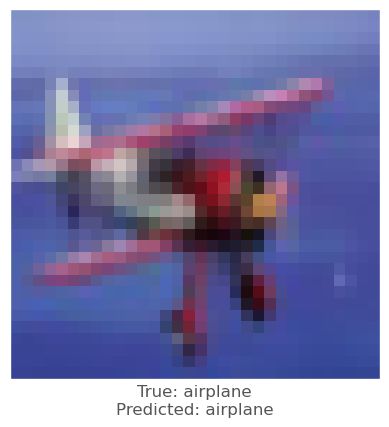


 lenet - image 7243 - 81 / 90
1/1 [==============================] - 0s 23ms/step


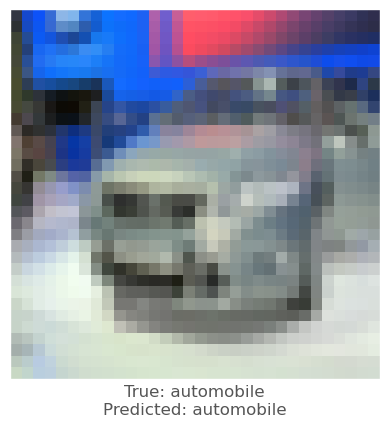


 lenet - image 673 - 82 / 90
1/1 [==============================] - 0s 22ms/step


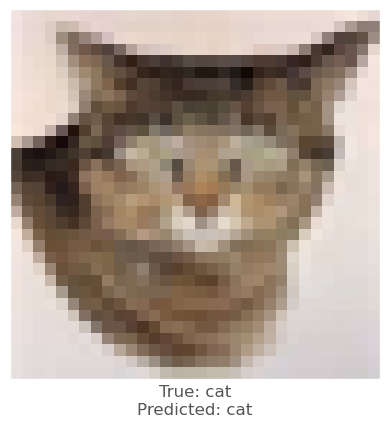


 lenet - image 6645 - 83 / 90
1/1 [==============================] - 0s 22ms/step


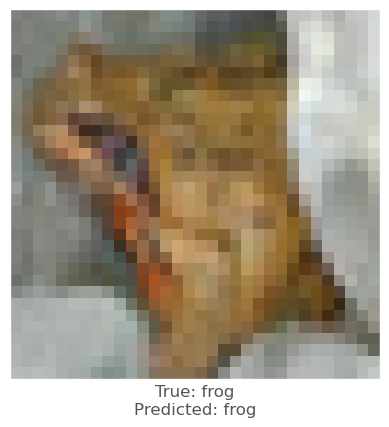


 lenet - image 7986 - 84 / 90
1/1 [==============================] - 0s 22ms/step


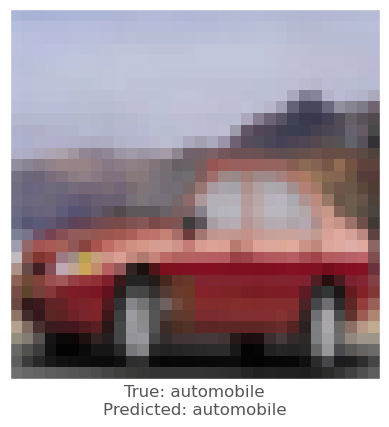


 lenet - image 3100 - 85 / 90
1/1 [==============================] - 0s 20ms/step


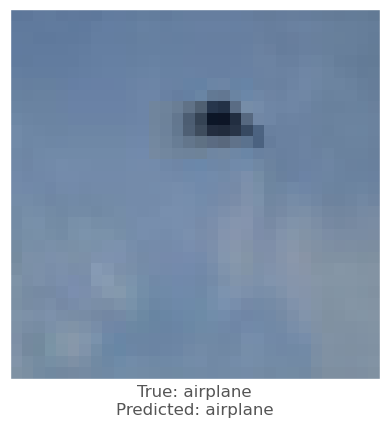


 lenet - image 7701 - 86 / 90
1/1 [==============================] - 0s 21ms/step


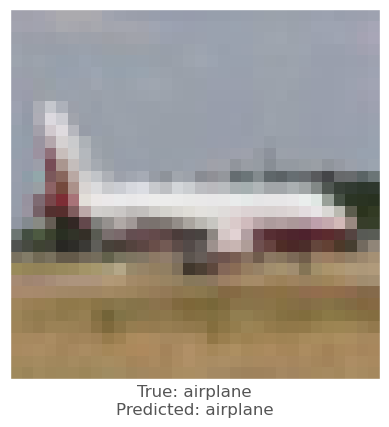


 lenet - image 8271 - 87 / 90
1/1 [==============================] - 0s 23ms/step


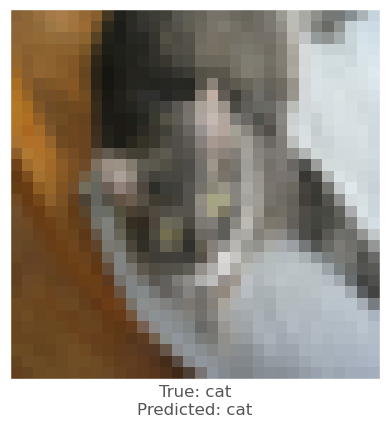


 lenet - image 172 - 88 / 90
1/1 [==============================] - 0s 22ms/step


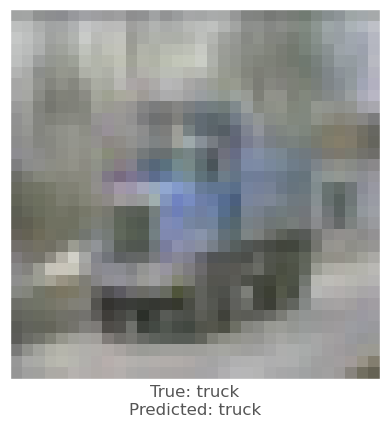


 lenet - image 6053 - 89 / 90
1/1 [==============================] - 0s 21ms/step


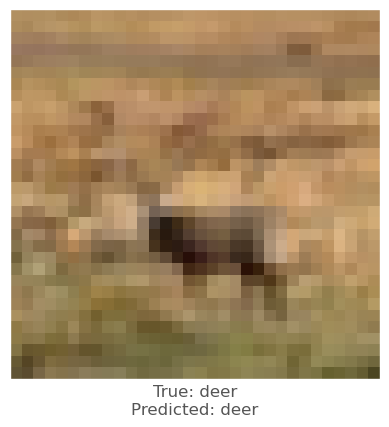


 lenet - image 7490 - 90 / 90
1/1 [==============================] - 0s 21ms/step


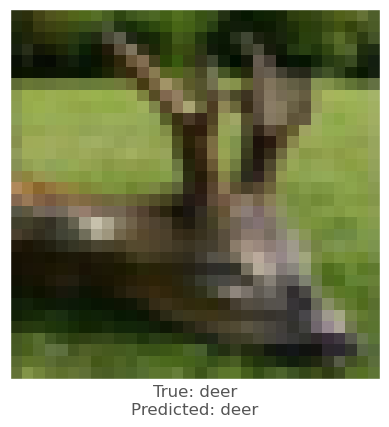


 lenet - image 9263 - 1 / 90
1/1 [==============================] - 0s 22ms/step


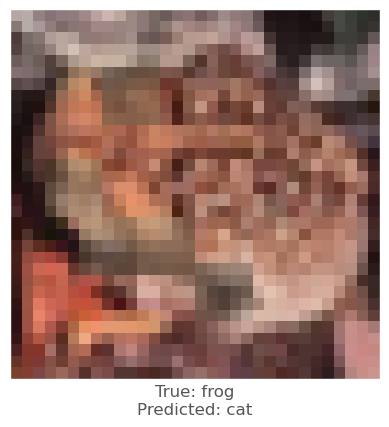


 lenet - image 6249 - 2 / 90
1/1 [==============================] - 0s 20ms/step


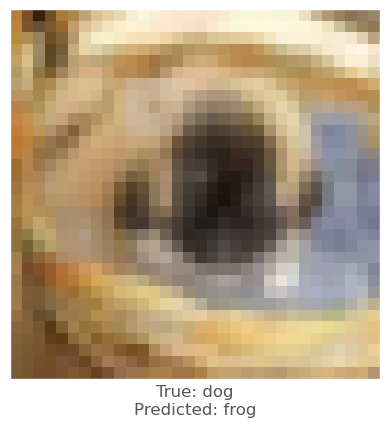


 lenet - image 3732 - 3 / 90
1/1 [==============================] - 0s 21ms/step


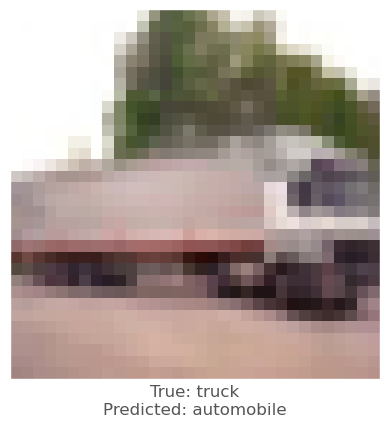


 lenet - image 8015 - 4 / 90
1/1 [==============================] - 0s 19ms/step


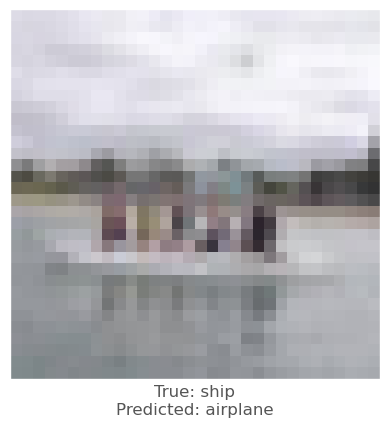


 lenet - image 4356 - 5 / 90
1/1 [==============================] - 0s 21ms/step


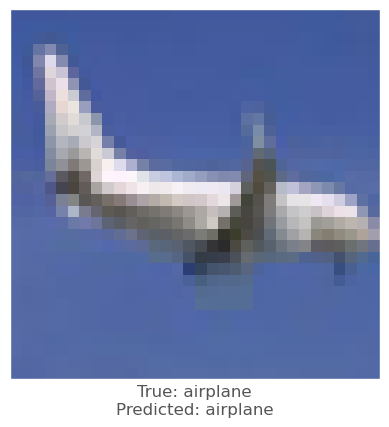


 lenet - image 4929 - 6 / 90
1/1 [==============================] - 0s 20ms/step


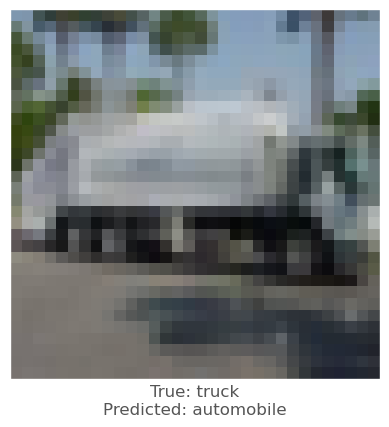


 lenet - image 2448 - 7 / 90
1/1 [==============================] - 0s 21ms/step


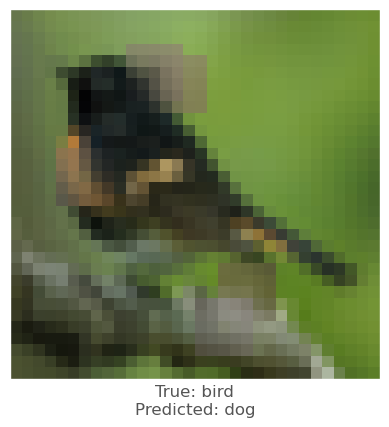


 lenet - image 1082 - 8 / 90
1/1 [==============================] - 0s 20ms/step


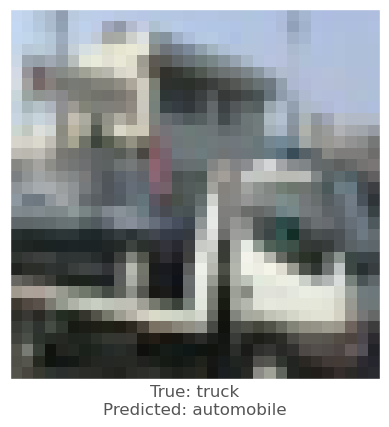


 lenet - image 6592 - 9 / 90
1/1 [==============================] - 0s 22ms/step


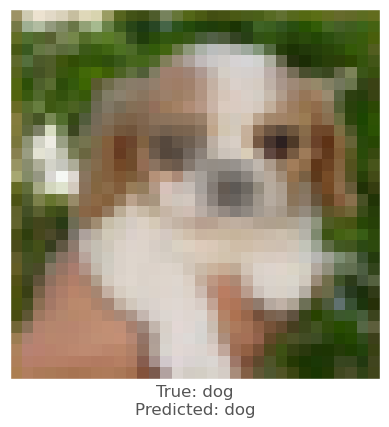


 lenet - image 8118 - 10 / 90
1/1 [==============================] - 0s 21ms/step


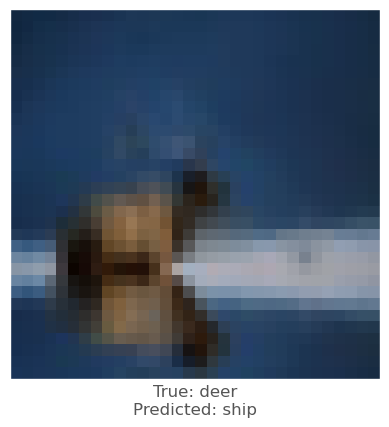


 lenet - image 4040 - 11 / 90
1/1 [==============================] - 0s 20ms/step


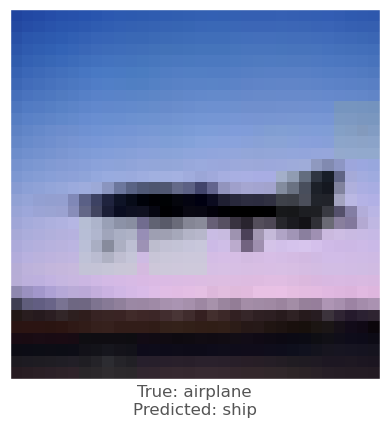


 lenet - image 4969 - 12 / 90
1/1 [==============================] - 0s 22ms/step


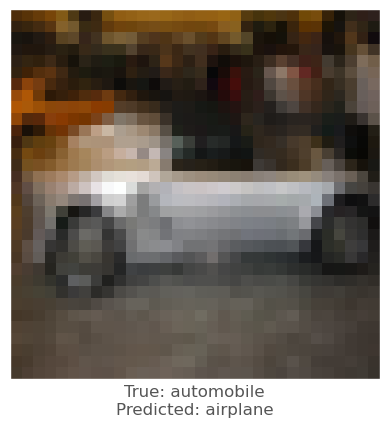


 lenet - image 4087 - 13 / 90
1/1 [==============================] - 0s 23ms/step


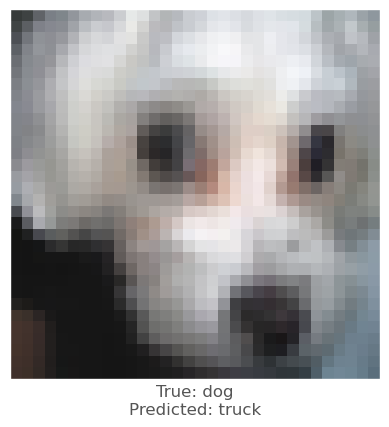


 lenet - image 1606 - 14 / 90
1/1 [==============================] - 0s 19ms/step


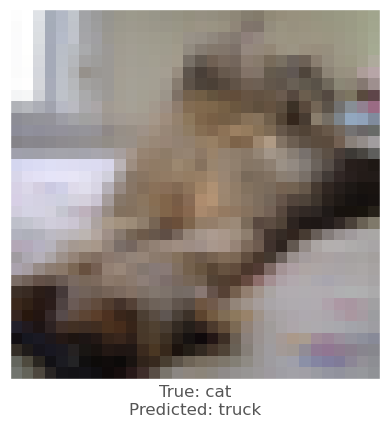


 lenet - image 8275 - 15 / 90
1/1 [==============================] - 0s 23ms/step


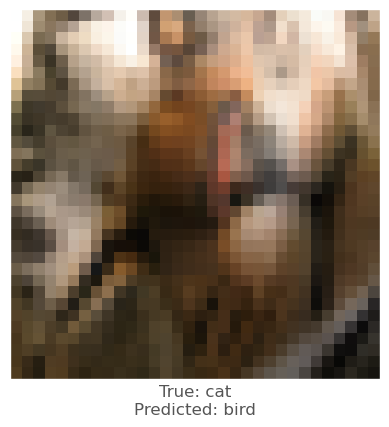


 lenet - image 4893 - 16 / 90
1/1 [==============================] - 0s 22ms/step


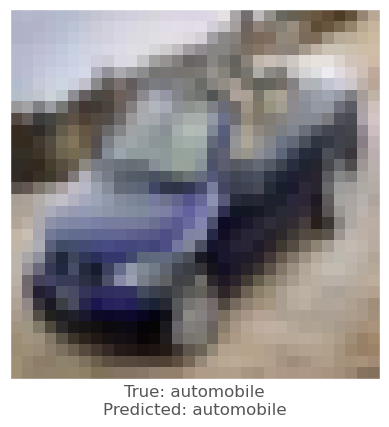


 lenet - image 6749 - 17 / 90
1/1 [==============================] - 0s 20ms/step


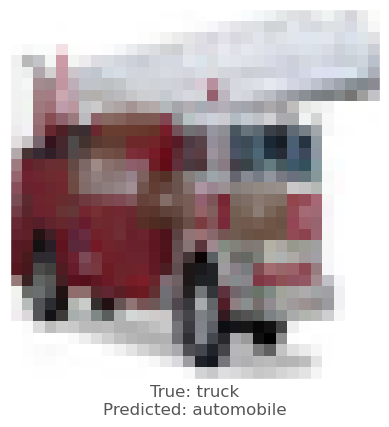


 lenet - image 1702 - 18 / 90
1/1 [==============================] - 0s 21ms/step


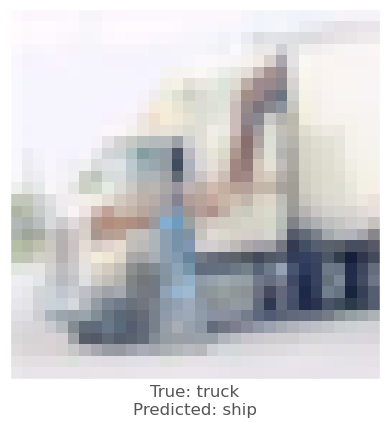


 lenet - image 662 - 19 / 90
1/1 [==============================] - 0s 23ms/step


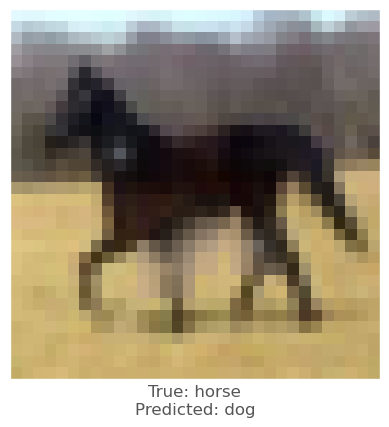


 lenet - image 379 - 20 / 90
1/1 [==============================] - 0s 22ms/step


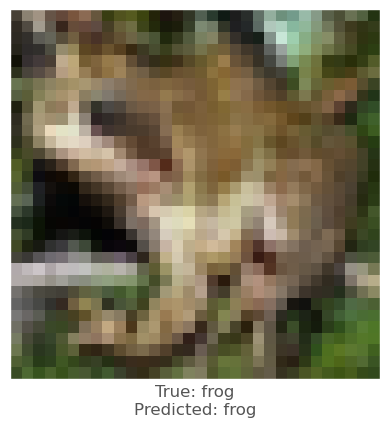


 lenet - image 8273 - 21 / 90
1/1 [==============================] - 0s 21ms/step


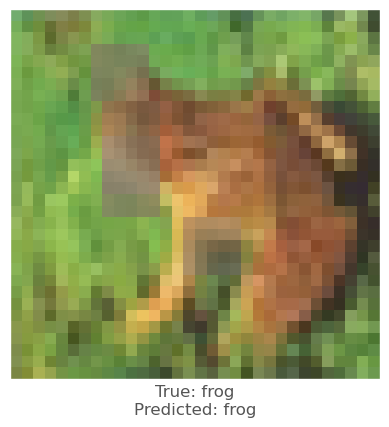


 lenet - image 7693 - 22 / 90
1/1 [==============================] - 0s 21ms/step


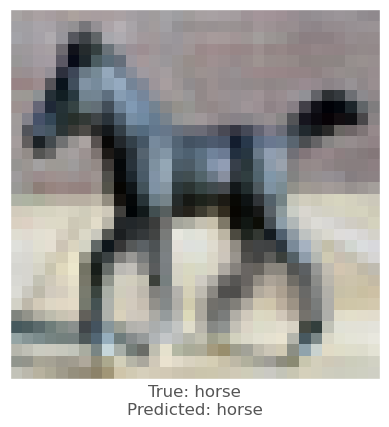


 lenet - image 8018 - 23 / 90
1/1 [==============================] - 0s 22ms/step


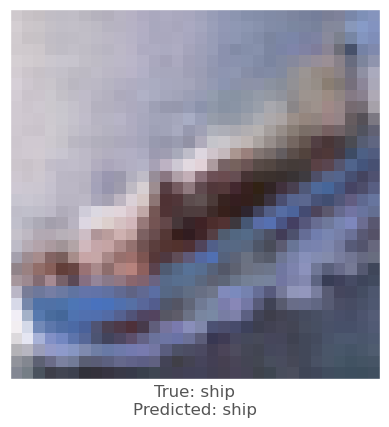


 lenet - image 1180 - 24 / 90
1/1 [==============================] - 0s 22ms/step


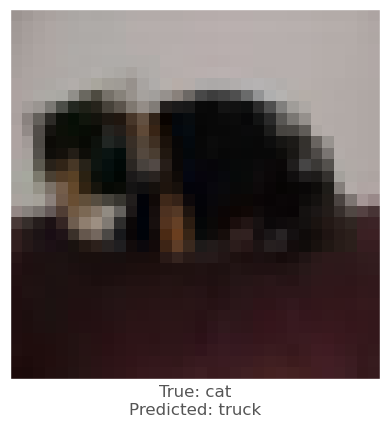


 lenet - image 5664 - 25 / 90
1/1 [==============================] - 0s 22ms/step


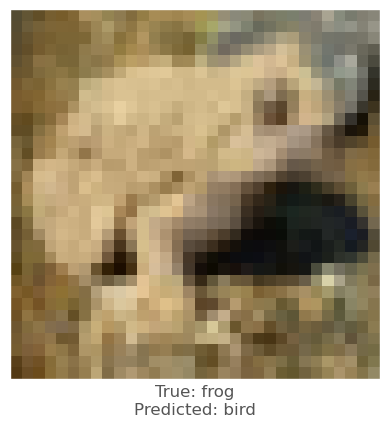


 lenet - image 4016 - 26 / 90
1/1 [==============================] - 0s 19ms/step


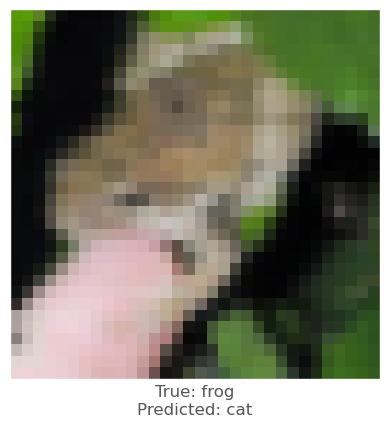


 lenet - image 6744 - 27 / 90
1/1 [==============================] - 0s 21ms/step


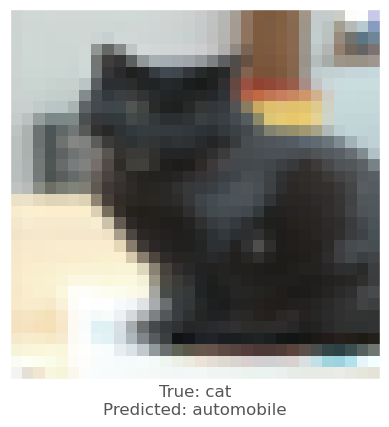


 lenet - image 3535 - 28 / 90
1/1 [==============================] - 0s 22ms/step


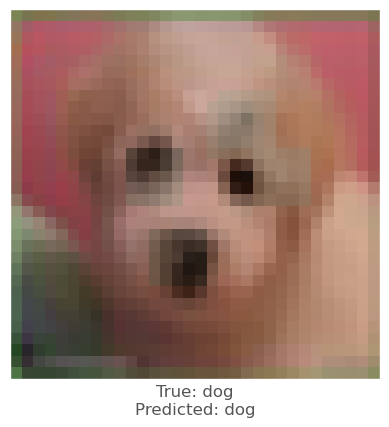


 lenet - image 8640 - 29 / 90
1/1 [==============================] - 0s 22ms/step


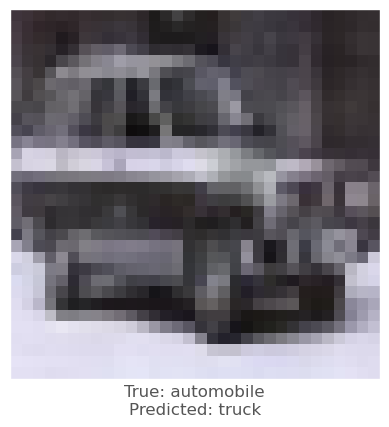


 lenet - image 6740 - 30 / 90
1/1 [==============================] - 0s 21ms/step


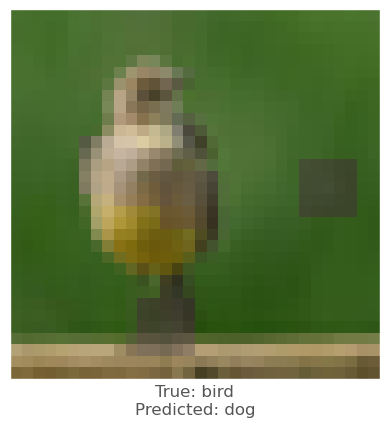


 lenet - image 7166 - 31 / 90
1/1 [==============================] - 0s 20ms/step


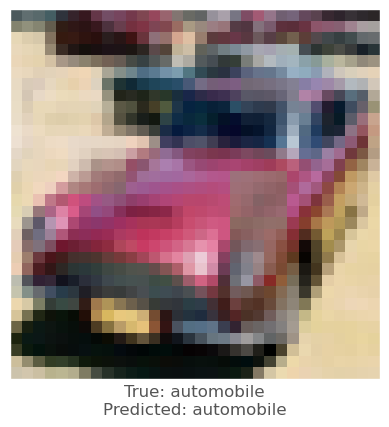


 lenet - image 2429 - 32 / 90
1/1 [==============================] - 0s 21ms/step


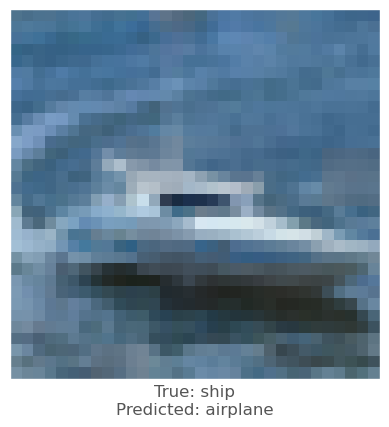


 lenet - image 9651 - 33 / 90
1/1 [==============================] - 0s 20ms/step


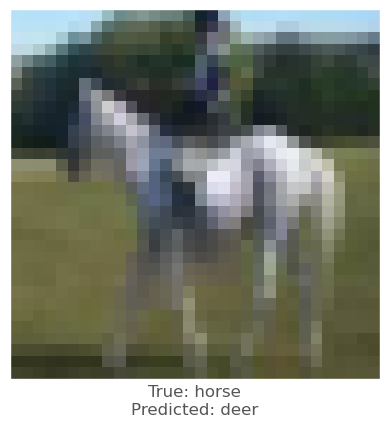


 lenet - image 3389 - 34 / 90
1/1 [==============================] - 0s 23ms/step


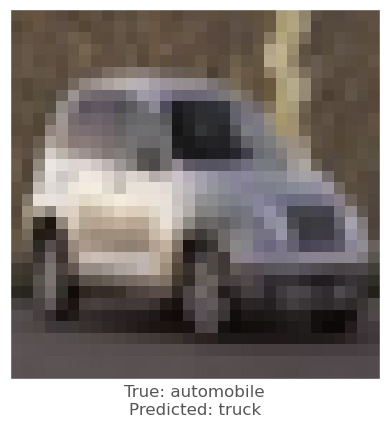


 lenet - image 5295 - 35 / 90
1/1 [==============================] - 0s 21ms/step


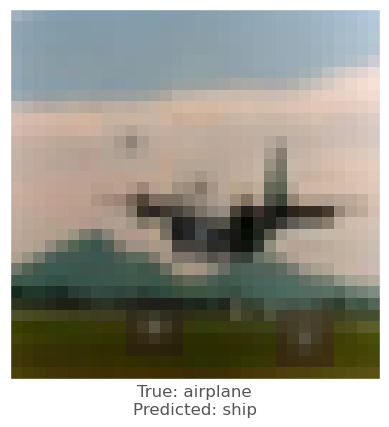


 lenet - image 3796 - 36 / 90
1/1 [==============================] - 0s 22ms/step


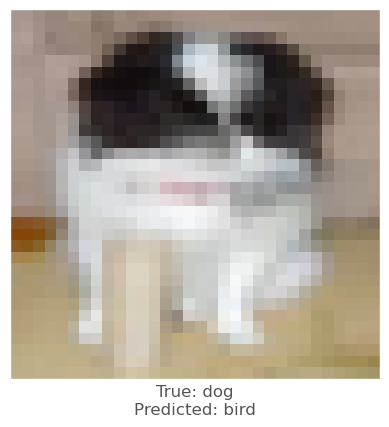


 lenet - image 7563 - 37 / 90
1/1 [==============================] - 0s 22ms/step


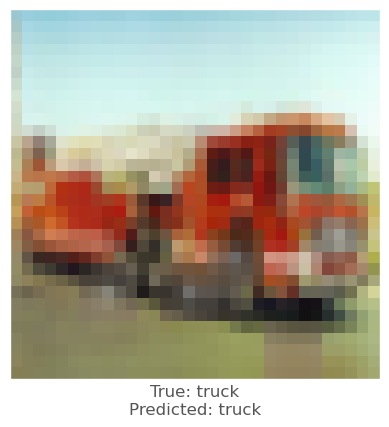


 lenet - image 2802 - 38 / 90
1/1 [==============================] - 0s 22ms/step


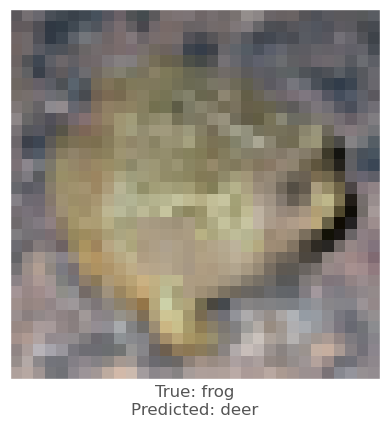


 lenet - image 5631 - 39 / 90
1/1 [==============================] - 0s 20ms/step


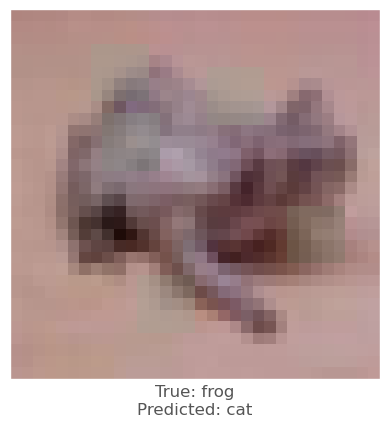


 lenet - image 7277 - 40 / 90
1/1 [==============================] - 0s 22ms/step


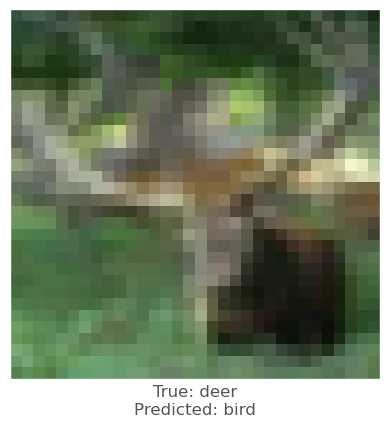


 lenet - image 5929 - 41 / 90
1/1 [==============================] - 0s 19ms/step


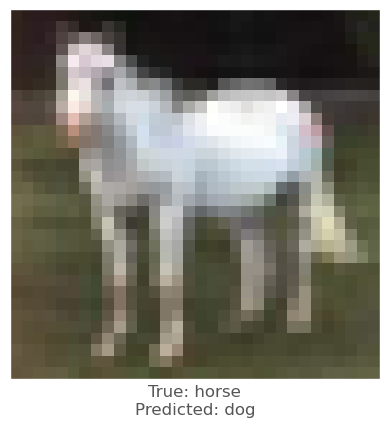


 lenet - image 8661 - 42 / 90
1/1 [==============================] - 0s 23ms/step


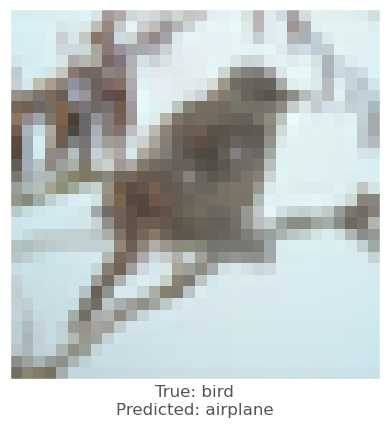


 lenet - image 7140 - 43 / 90
1/1 [==============================] - 0s 21ms/step


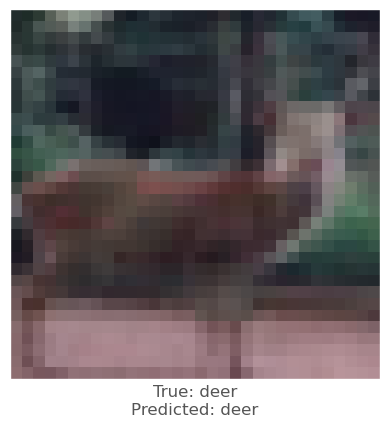


 lenet - image 1390 - 44 / 90
1/1 [==============================] - 0s 24ms/step


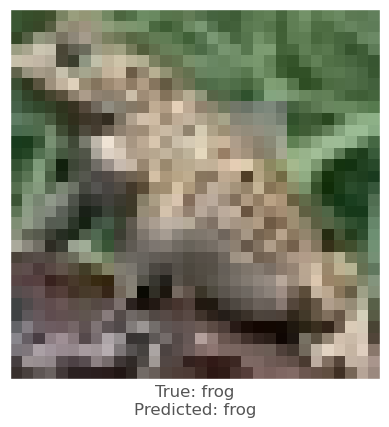


 lenet - image 6657 - 45 / 90
1/1 [==============================] - 0s 22ms/step


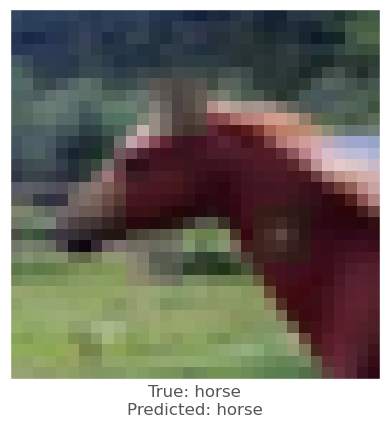


 lenet - image 9363 - 46 / 90
1/1 [==============================] - 0s 20ms/step


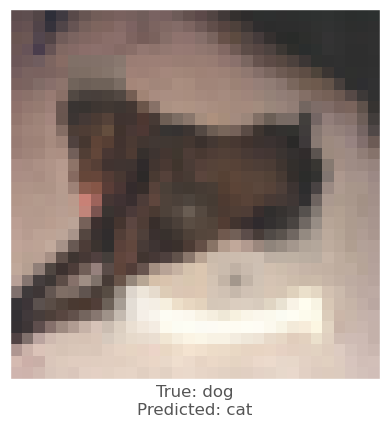


 lenet - image 6539 - 47 / 90
1/1 [==============================] - 0s 22ms/step


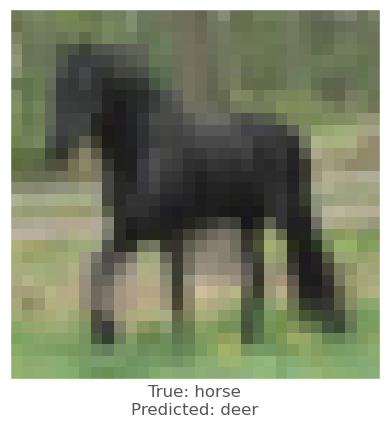


 lenet - image 2329 - 48 / 90
1/1 [==============================] - 0s 23ms/step


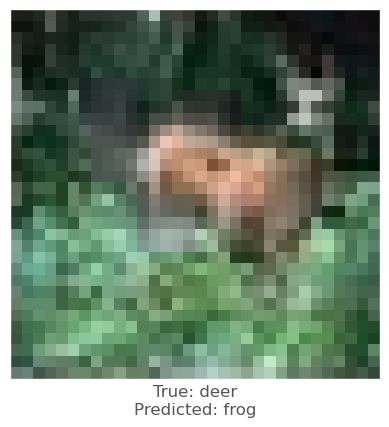


 lenet - image 2340 - 49 / 90
1/1 [==============================] - 0s 21ms/step


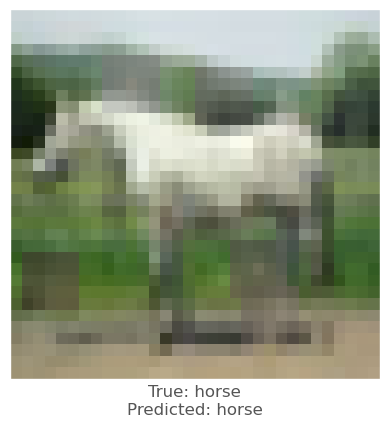


 lenet - image 7370 - 50 / 90
1/1 [==============================] - 0s 25ms/step


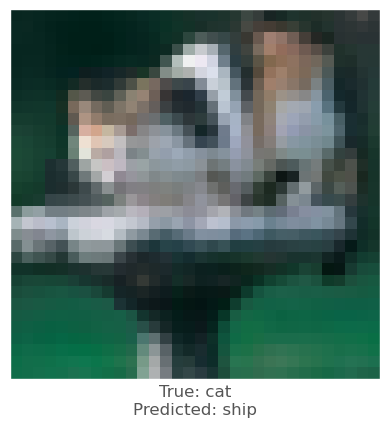


 lenet - image 4900 - 51 / 90
1/1 [==============================] - 0s 21ms/step


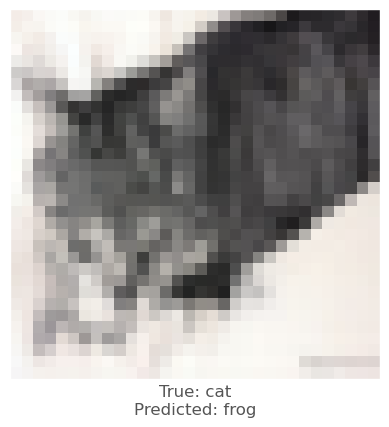


 lenet - image 2587 - 52 / 90
1/1 [==============================] - 0s 20ms/step


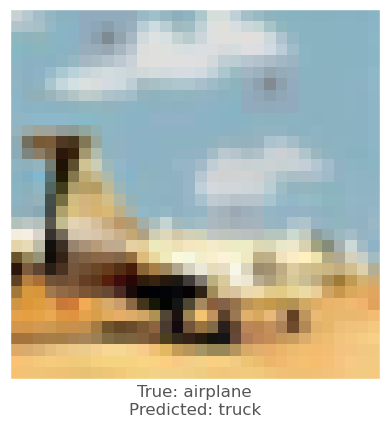


 lenet - image 5267 - 53 / 90
1/1 [==============================] - 0s 22ms/step


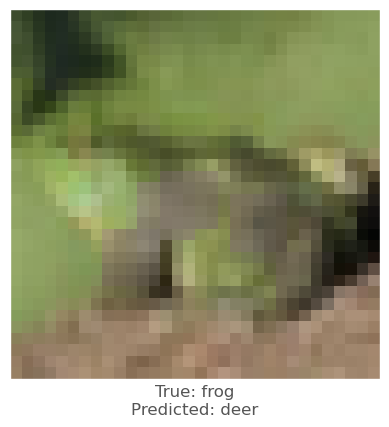


 lenet - image 1876 - 54 / 90
1/1 [==============================] - 0s 20ms/step


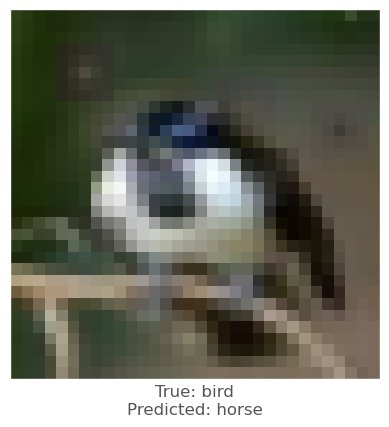


 lenet - image 7238 - 55 / 90
1/1 [==============================] - 0s 20ms/step


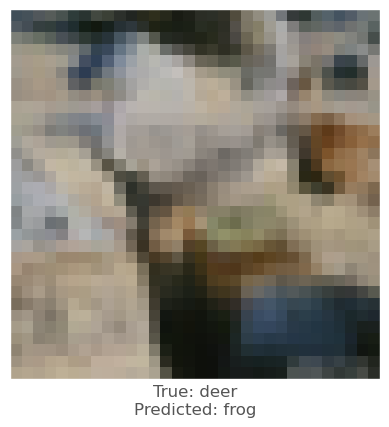


 lenet - image 1152 - 56 / 90
1/1 [==============================] - 0s 25ms/step


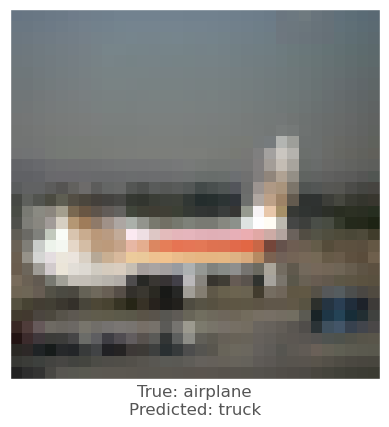


 lenet - image 1892 - 57 / 90
1/1 [==============================] - 0s 21ms/step


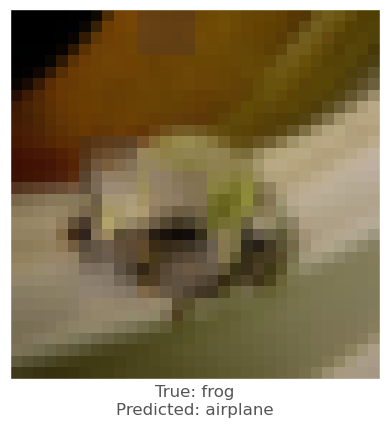


 lenet - image 1651 - 58 / 90
1/1 [==============================] - 0s 21ms/step


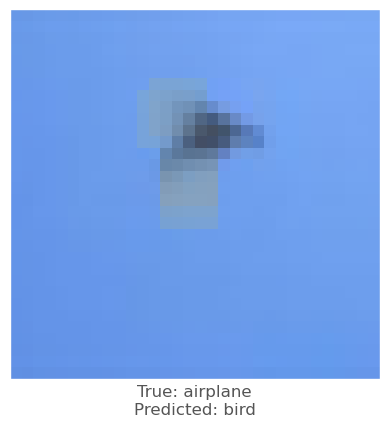


 lenet - image 2246 - 59 / 90
1/1 [==============================] - 0s 30ms/step


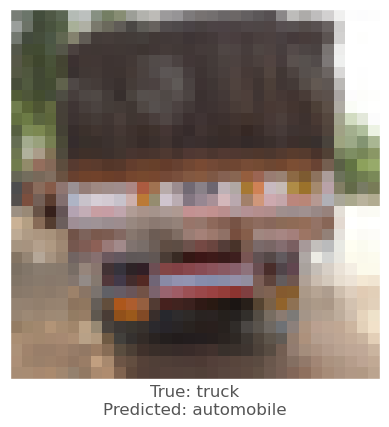


 lenet - image 0 - 60 / 90
1/1 [==============================] - 0s 21ms/step


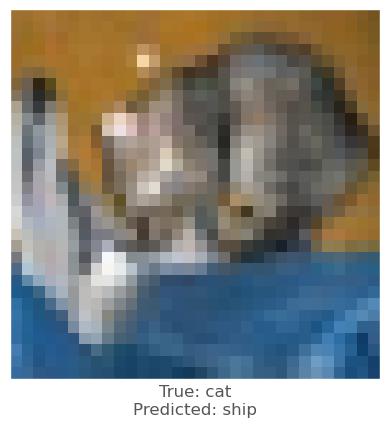


 lenet - image 3599 - 61 / 90
1/1 [==============================] - 0s 22ms/step


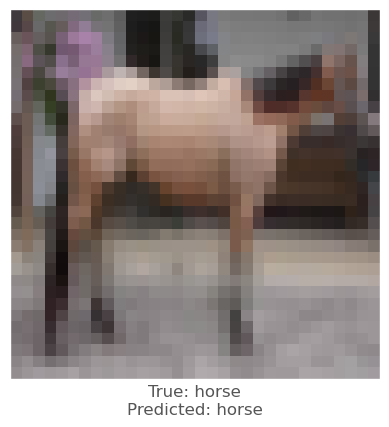


 lenet - image 8643 - 62 / 90
1/1 [==============================] - 0s 24ms/step


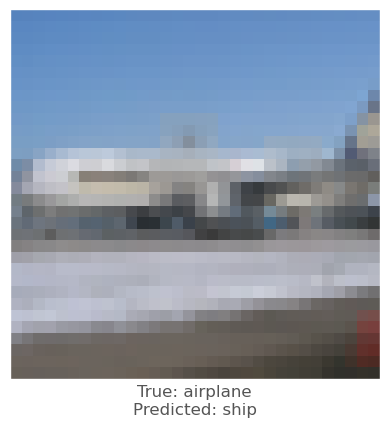


 lenet - image 8073 - 63 / 90
1/1 [==============================] - 0s 21ms/step


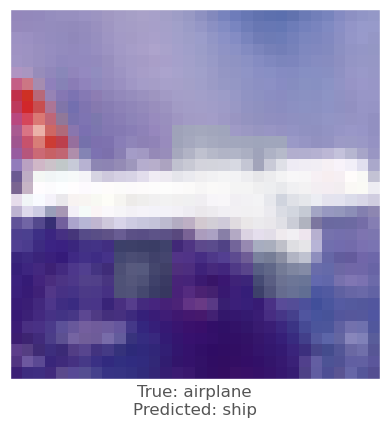


 lenet - image 1272 - 64 / 90
1/1 [==============================] - 0s 21ms/step


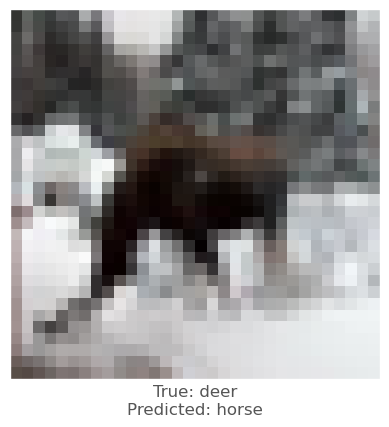


 lenet - image 4124 - 65 / 90
1/1 [==============================] - 0s 22ms/step


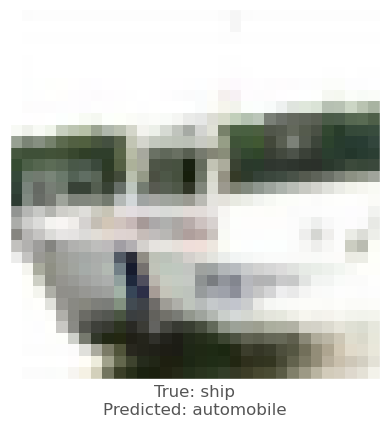


 lenet - image 1197 - 66 / 90
1/1 [==============================] - 0s 21ms/step


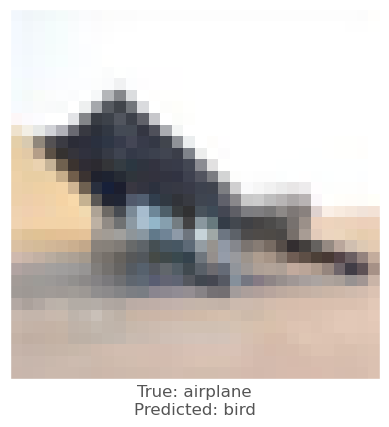


 lenet - image 8847 - 67 / 90
1/1 [==============================] - 0s 23ms/step


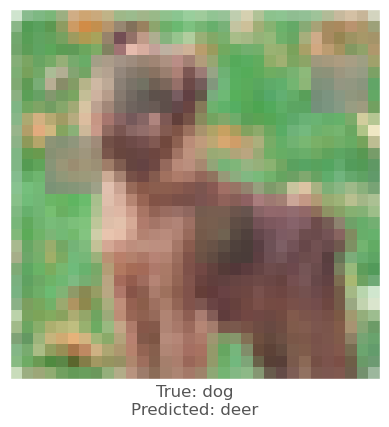


 lenet - image 3076 - 68 / 90
1/1 [==============================] - 0s 25ms/step


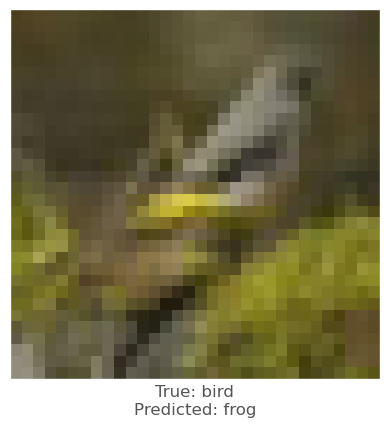


 lenet - image 6633 - 69 / 90
1/1 [==============================] - 0s 22ms/step


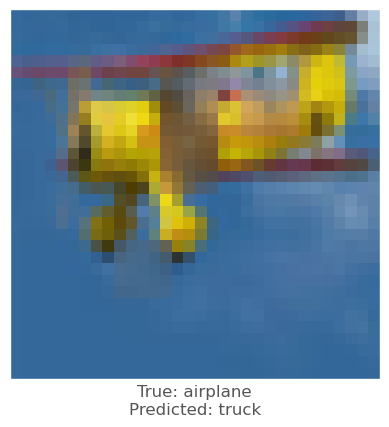


 lenet - image 331 - 70 / 90
1/1 [==============================] - 0s 20ms/step


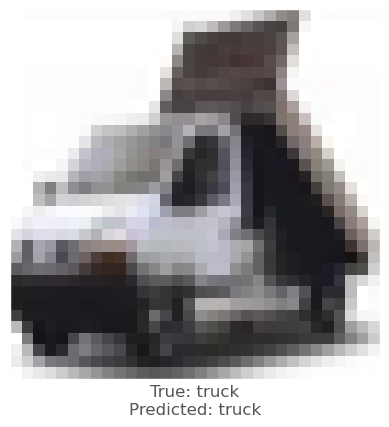


 lenet - image 4913 - 71 / 90
1/1 [==============================] - 0s 21ms/step


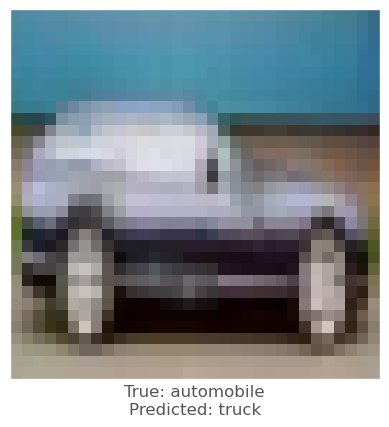


 lenet - image 8826 - 72 / 90
1/1 [==============================] - 0s 21ms/step


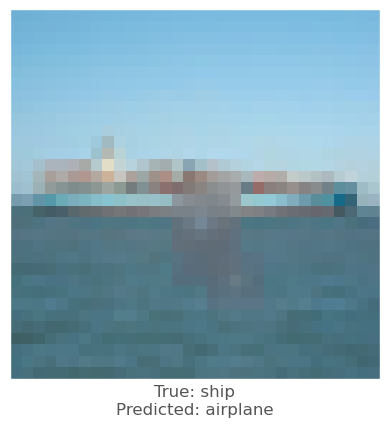


 lenet - image 5860 - 73 / 90
1/1 [==============================] - 0s 21ms/step


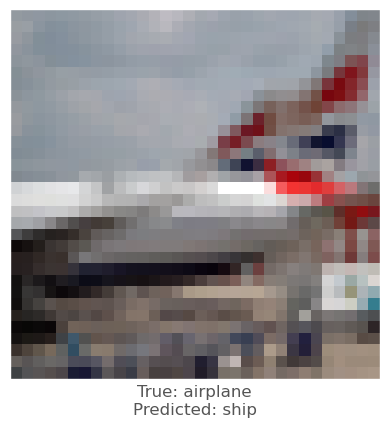


 lenet - image 1104 - 74 / 90
1/1 [==============================] - 0s 23ms/step


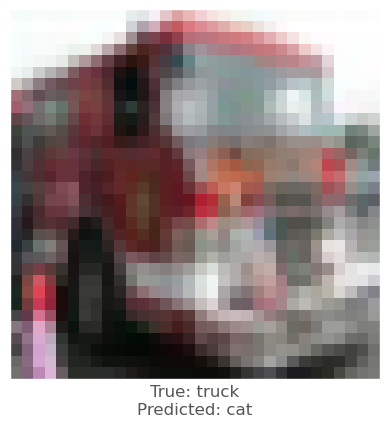


 lenet - image 6472 - 75 / 90
1/1 [==============================] - 0s 22ms/step


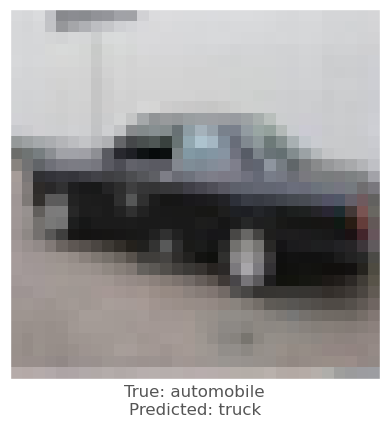


 lenet - image 9977 - 76 / 90
1/1 [==============================] - 0s 21ms/step


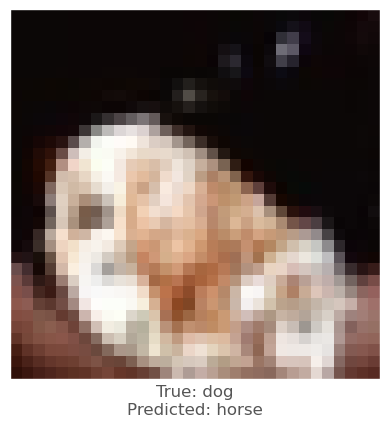


 lenet - image 4098 - 77 / 90
1/1 [==============================] - 0s 21ms/step


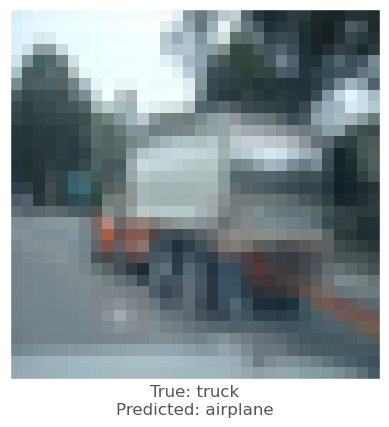


 lenet - image 5140 - 78 / 90
1/1 [==============================] - 0s 23ms/step


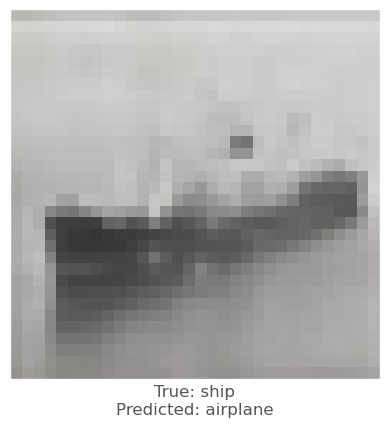


 lenet - image 8112 - 79 / 90
1/1 [==============================] - 0s 22ms/step


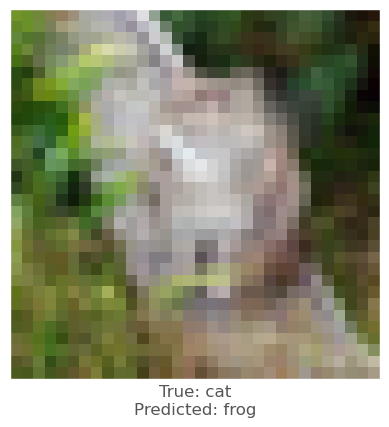


 lenet - image 5798 - 80 / 90
1/1 [==============================] - 0s 21ms/step


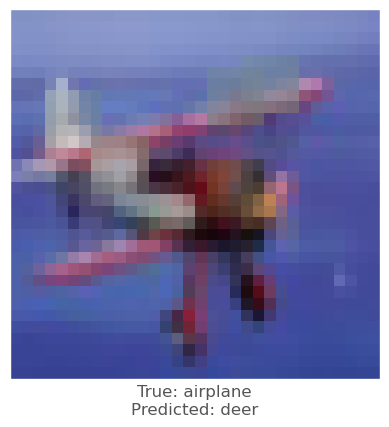


 lenet - image 7243 - 81 / 90
1/1 [==============================] - 0s 20ms/step


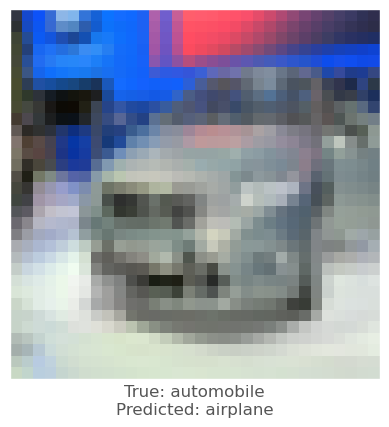


 lenet - image 673 - 82 / 90
1/1 [==============================] - 0s 22ms/step


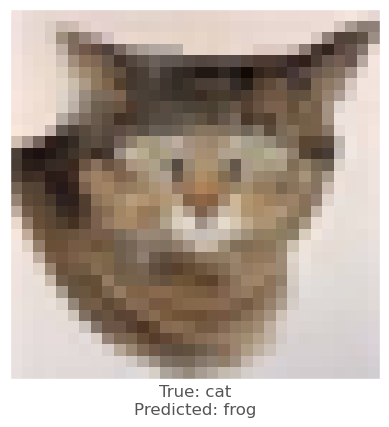


 lenet - image 6645 - 83 / 90
1/1 [==============================] - 0s 22ms/step


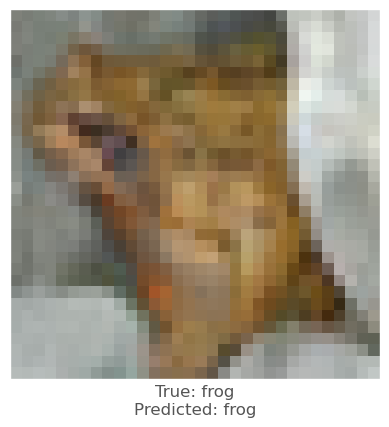


 lenet - image 7986 - 84 / 90
1/1 [==============================] - 0s 25ms/step


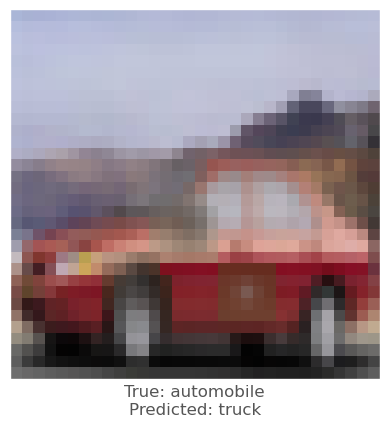


 lenet - image 3100 - 85 / 90
1/1 [==============================] - 0s 21ms/step


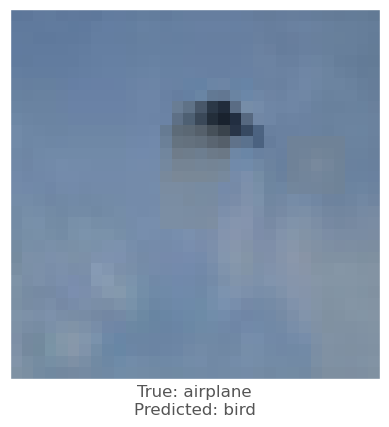


 lenet - image 7701 - 86 / 90
1/1 [==============================] - 0s 26ms/step


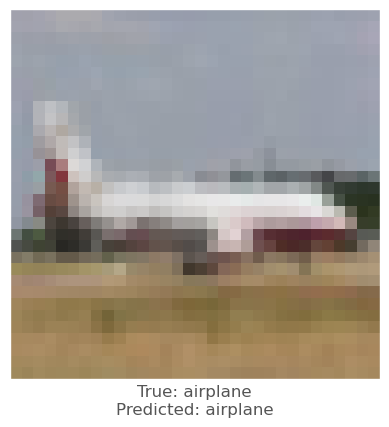


 lenet - image 8271 - 87 / 90
1/1 [==============================] - 0s 20ms/step


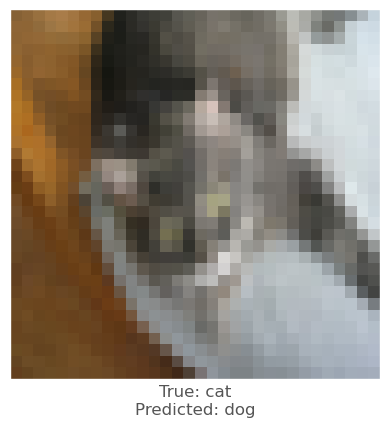


 lenet - image 172 - 88 / 90
1/1 [==============================] - 0s 21ms/step


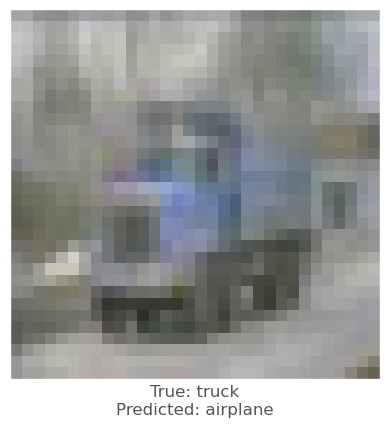


 lenet - image 6053 - 89 / 90
1/1 [==============================] - 0s 22ms/step


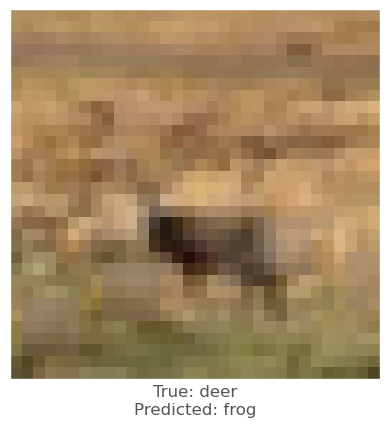


 lenet - image 7490 - 90 / 90
1/1 [==============================] - 0s 20ms/step


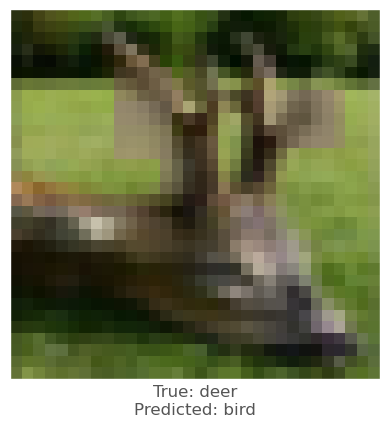


 lenet - image 9263 - 1 / 90
1/1 [==============================] - 0s 21ms/step


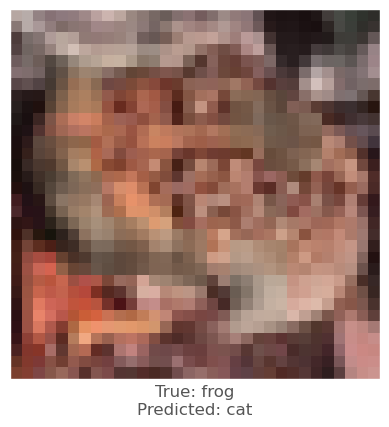


 lenet - image 6249 - 2 / 90
1/1 [==============================] - 0s 21ms/step


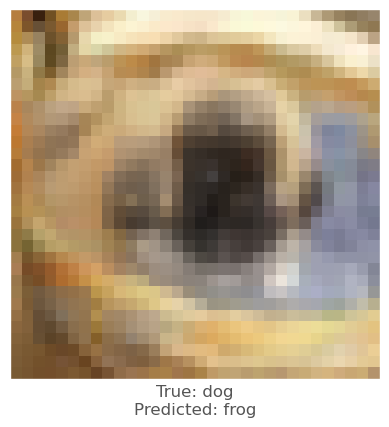


 lenet - image 3732 - 3 / 90
1/1 [==============================] - 0s 20ms/step


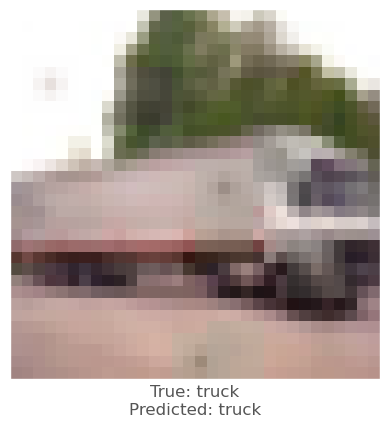


 lenet - image 8015 - 4 / 90
1/1 [==============================] - 0s 20ms/step


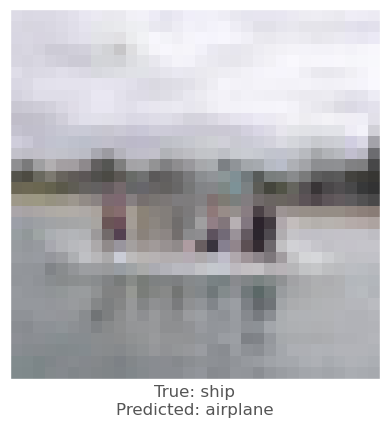


 lenet - image 4356 - 5 / 90
1/1 [==============================] - 0s 23ms/step


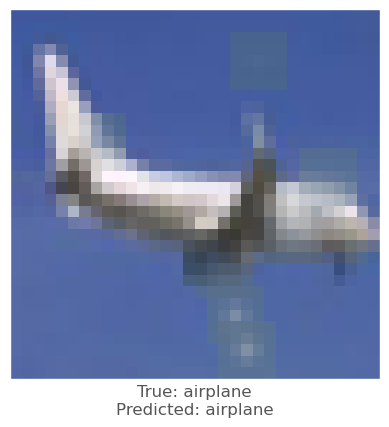


 lenet - image 4929 - 6 / 90
1/1 [==============================] - 0s 20ms/step


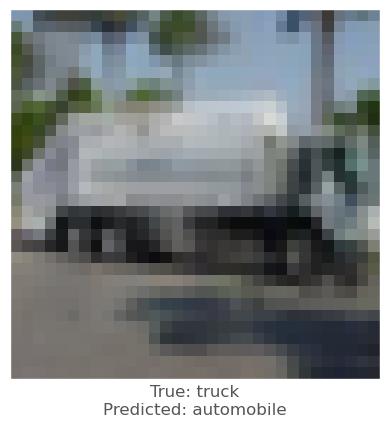


 lenet - image 2448 - 7 / 90
1/1 [==============================] - 0s 20ms/step


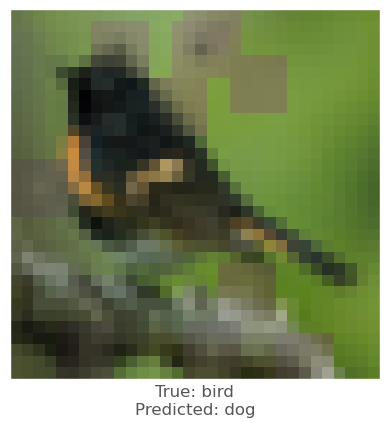


 lenet - image 1082 - 8 / 90
1/1 [==============================] - 0s 24ms/step


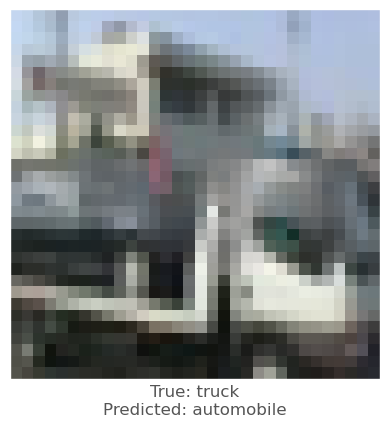


 lenet - image 6592 - 9 / 90
1/1 [==============================] - 0s 22ms/step


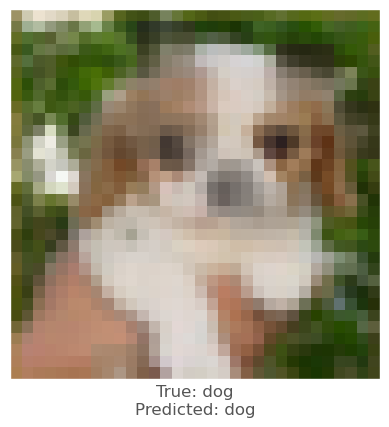


 lenet - image 8118 - 10 / 90
1/1 [==============================] - 0s 19ms/step


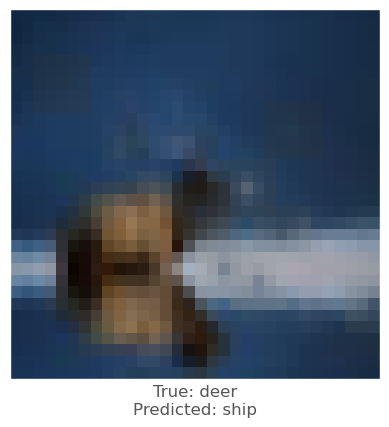


 lenet - image 4040 - 11 / 90
1/1 [==============================] - 0s 20ms/step


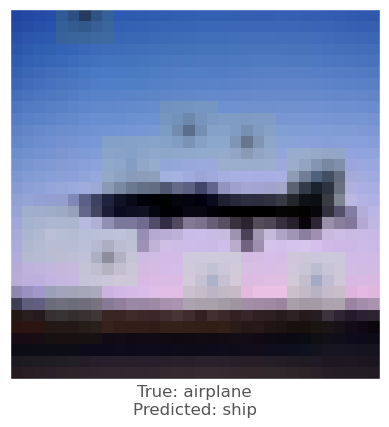


 lenet - image 4969 - 12 / 90
1/1 [==============================] - 0s 20ms/step


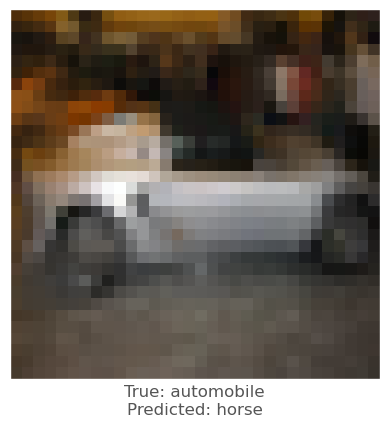


 lenet - image 4087 - 13 / 90
1/1 [==============================] - 0s 20ms/step


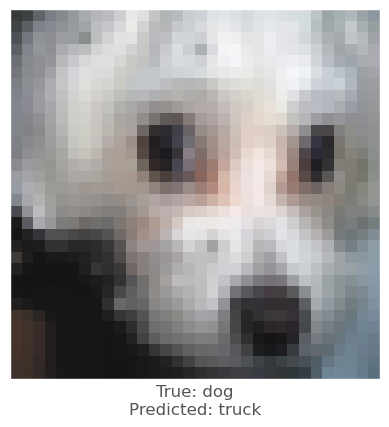


 lenet - image 1606 - 14 / 90
1/1 [==============================] - 0s 21ms/step


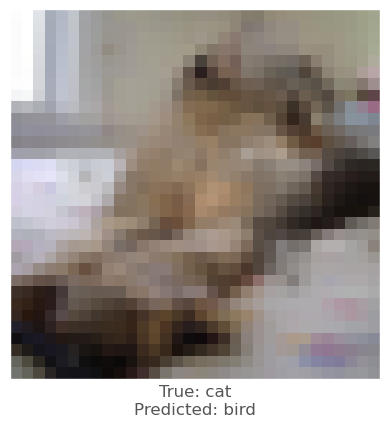


 lenet - image 8275 - 15 / 90
1/1 [==============================] - 0s 20ms/step


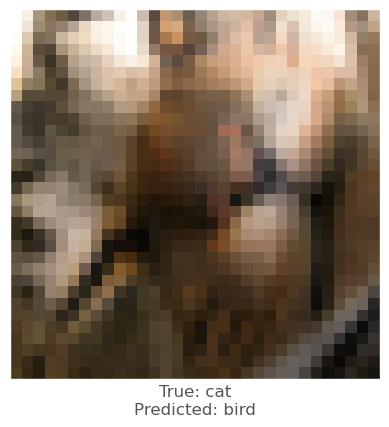


 lenet - image 4893 - 16 / 90
1/1 [==============================] - 0s 20ms/step


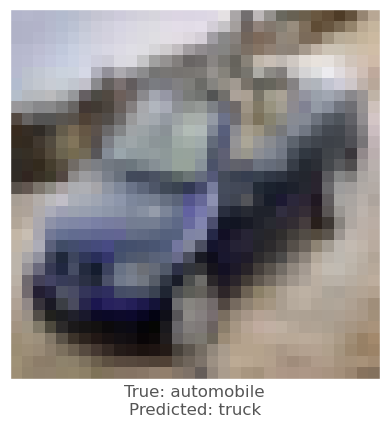


 lenet - image 6749 - 17 / 90
1/1 [==============================] - 0s 22ms/step


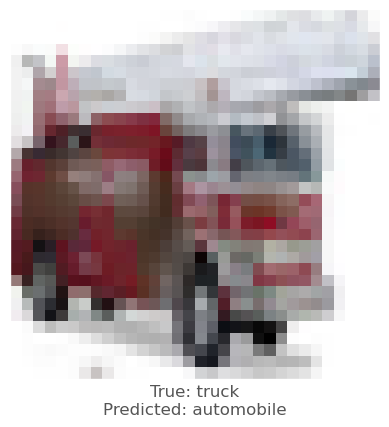


 lenet - image 1702 - 18 / 90
1/1 [==============================] - 0s 22ms/step


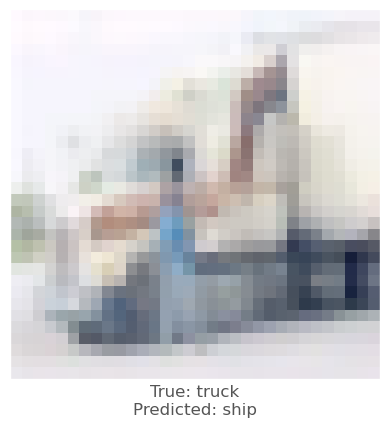


 lenet - image 662 - 19 / 90
1/1 [==============================] - 0s 58ms/step


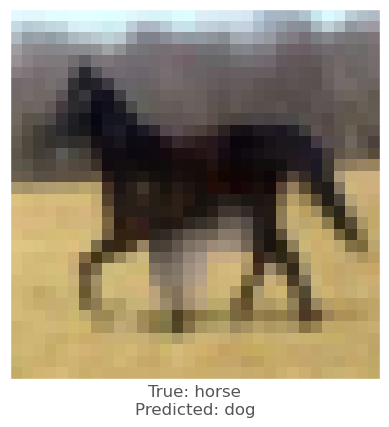


 lenet - image 379 - 20 / 90
1/1 [==============================] - 0s 22ms/step


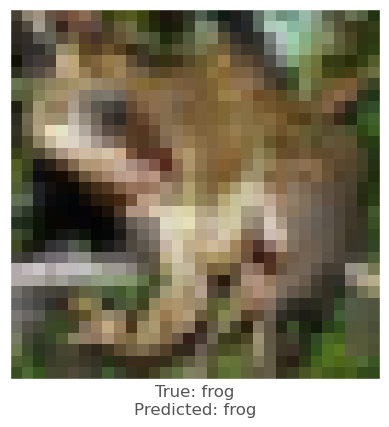


 lenet - image 8273 - 21 / 90
1/1 [==============================] - 0s 26ms/step


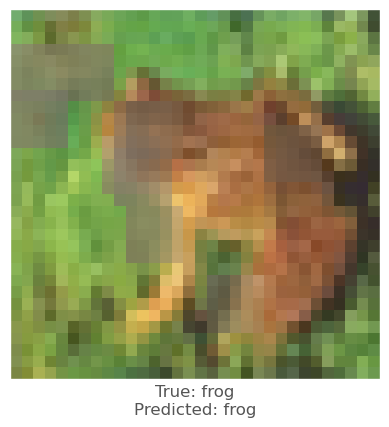


 lenet - image 7693 - 22 / 90
1/1 [==============================] - 0s 21ms/step


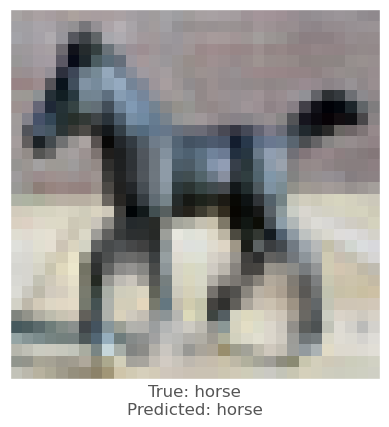


 lenet - image 8018 - 23 / 90
1/1 [==============================] - 0s 32ms/step


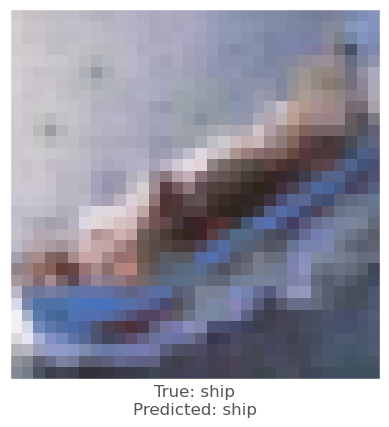


 lenet - image 1180 - 24 / 90
1/1 [==============================] - 0s 33ms/step


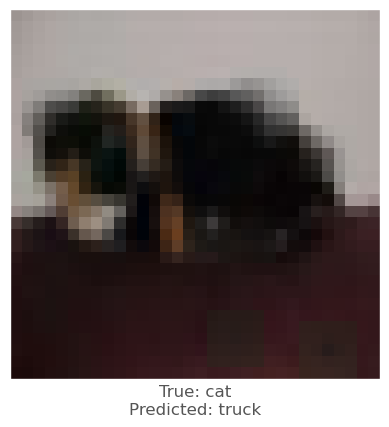


 lenet - image 5664 - 25 / 90
1/1 [==============================] - 0s 23ms/step


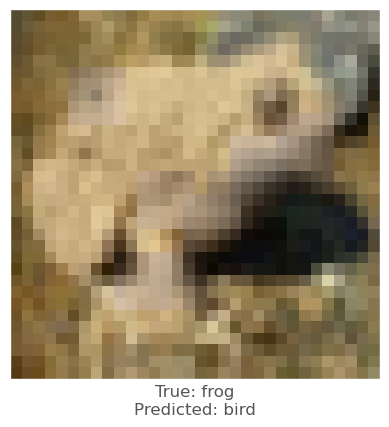


 lenet - image 4016 - 26 / 90
1/1 [==============================] - 0s 26ms/step


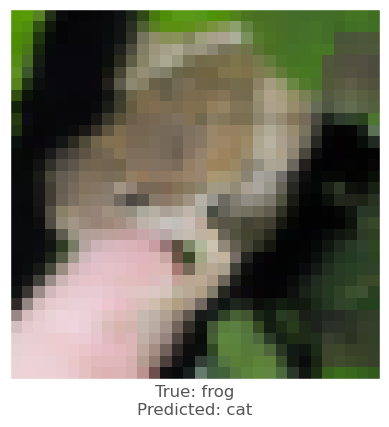


 lenet - image 6744 - 27 / 90
1/1 [==============================] - 0s 23ms/step


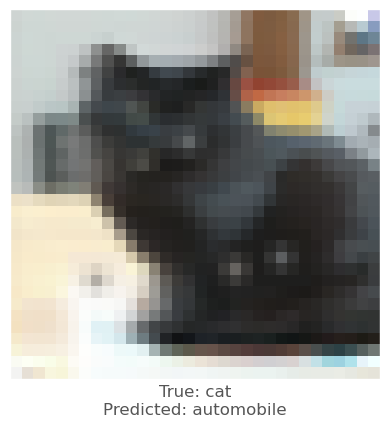


 lenet - image 3535 - 28 / 90
1/1 [==============================] - 0s 23ms/step


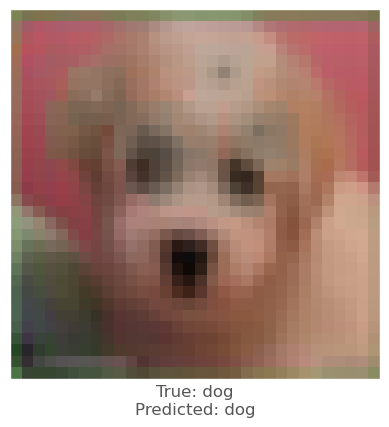


 lenet - image 8640 - 29 / 90
1/1 [==============================] - 0s 25ms/step


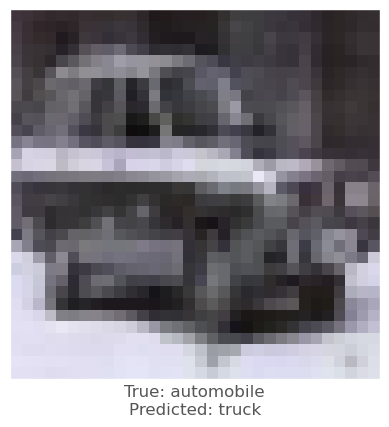


 lenet - image 6740 - 30 / 90
1/1 [==============================] - 0s 22ms/step


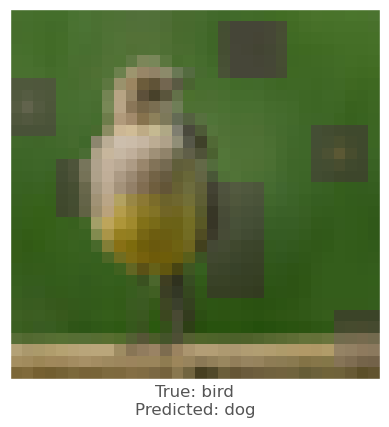


 lenet - image 7166 - 31 / 90
1/1 [==============================] - 0s 22ms/step


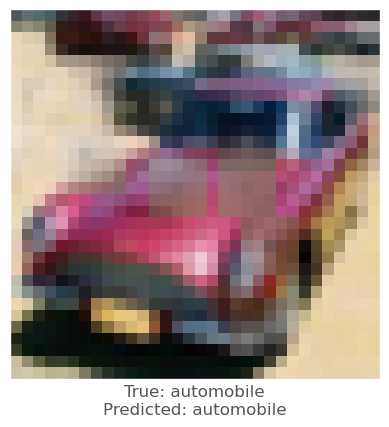


 lenet - image 2429 - 32 / 90
1/1 [==============================] - 0s 21ms/step


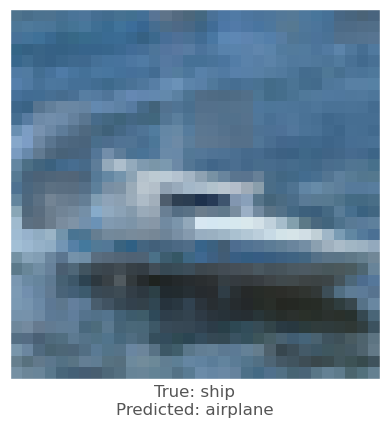


 lenet - image 9651 - 33 / 90
1/1 [==============================] - 0s 23ms/step


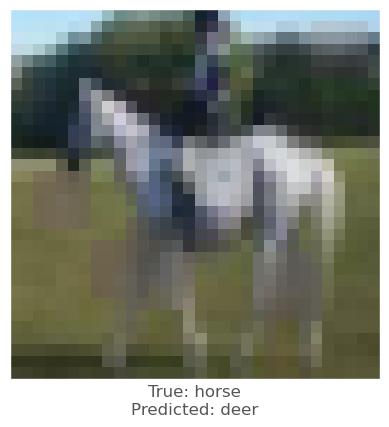


 lenet - image 3389 - 34 / 90
1/1 [==============================] - 0s 20ms/step


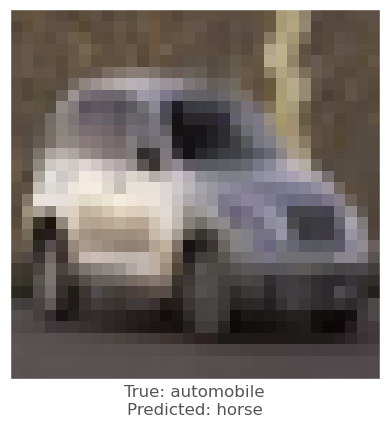


 lenet - image 5295 - 35 / 90
1/1 [==============================] - 0s 20ms/step


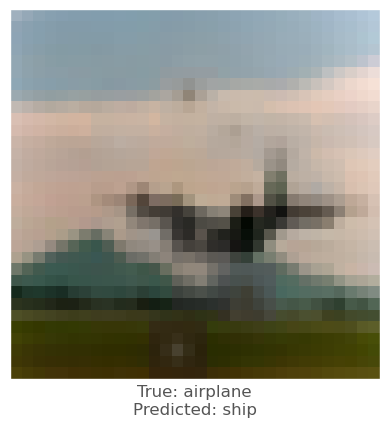


 lenet - image 3796 - 36 / 90
1/1 [==============================] - 0s 20ms/step


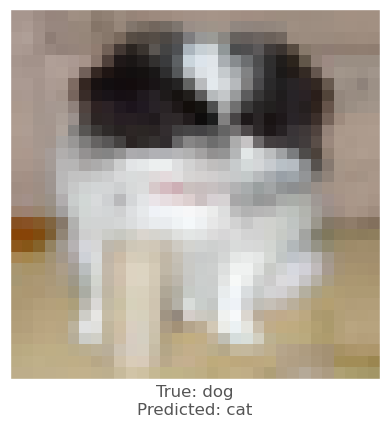


 lenet - image 7563 - 37 / 90
1/1 [==============================] - 0s 22ms/step


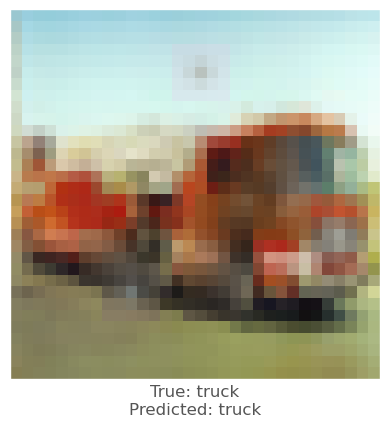


 lenet - image 2802 - 38 / 90
1/1 [==============================] - 0s 21ms/step


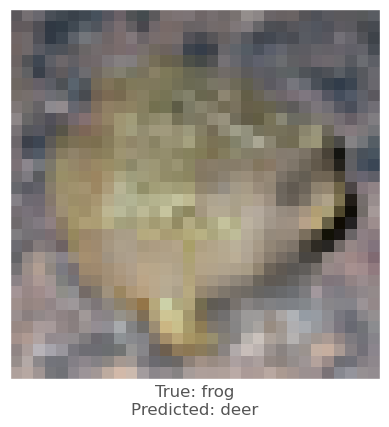


 lenet - image 5631 - 39 / 90
1/1 [==============================] - 0s 24ms/step


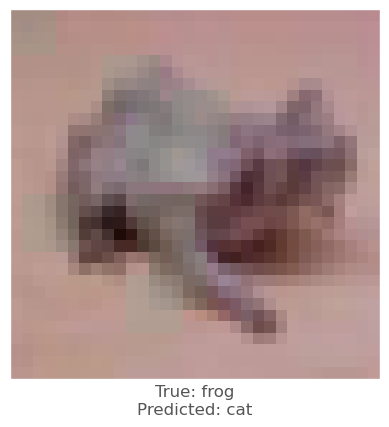


 lenet - image 7277 - 40 / 90
1/1 [==============================] - 0s 23ms/step


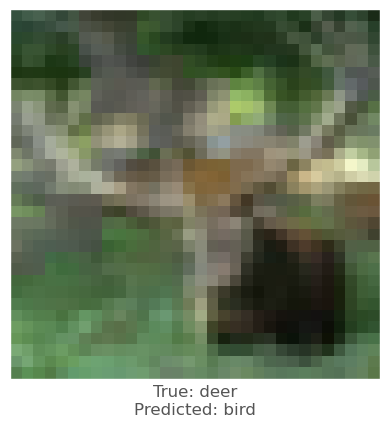


 lenet - image 5929 - 41 / 90
1/1 [==============================] - 0s 26ms/step


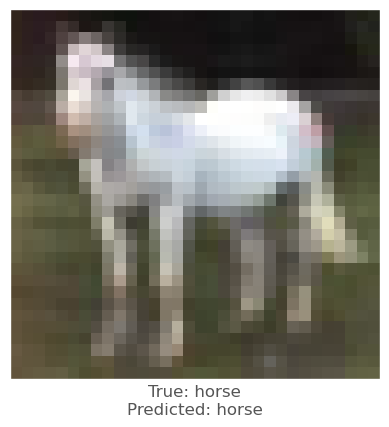


 lenet - image 8661 - 42 / 90
1/1 [==============================] - 0s 26ms/step


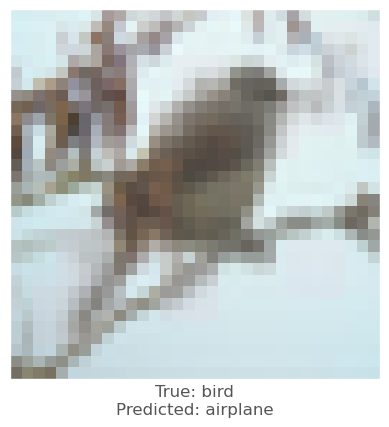


 lenet - image 7140 - 43 / 90
1/1 [==============================] - 0s 22ms/step


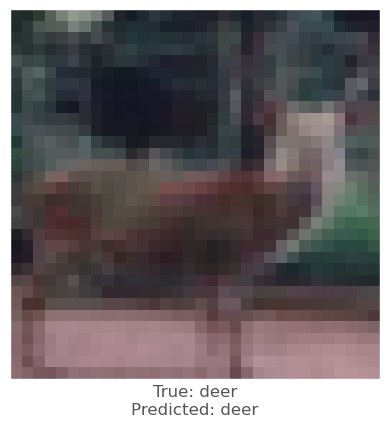


 lenet - image 1390 - 44 / 90
1/1 [==============================] - 0s 22ms/step


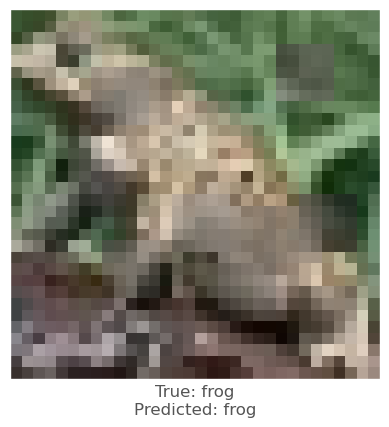


 lenet - image 6657 - 45 / 90
1/1 [==============================] - 0s 21ms/step


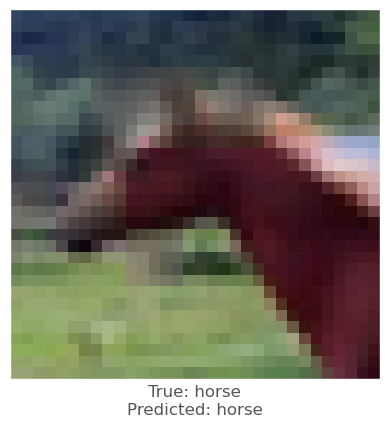


 lenet - image 9363 - 46 / 90
1/1 [==============================] - 0s 24ms/step


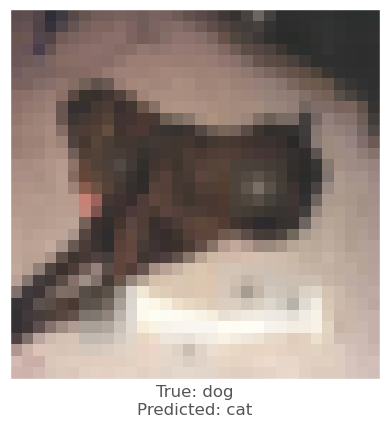


 lenet - image 6539 - 47 / 90
1/1 [==============================] - 0s 21ms/step


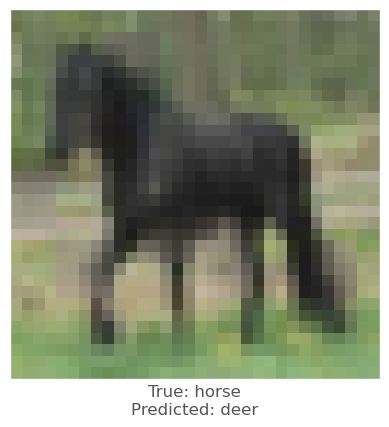


 lenet - image 2329 - 48 / 90
1/1 [==============================] - 0s 22ms/step


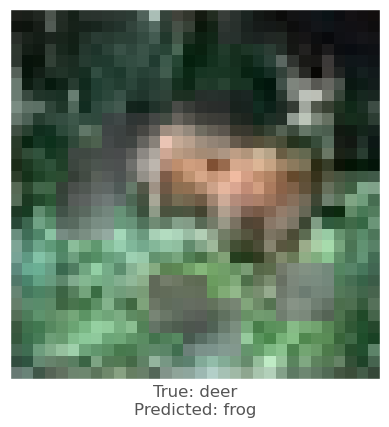


 lenet - image 2340 - 49 / 90
1/1 [==============================] - 0s 22ms/step


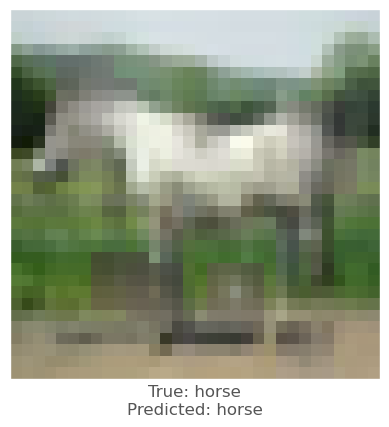


 lenet - image 7370 - 50 / 90
1/1 [==============================] - 0s 22ms/step


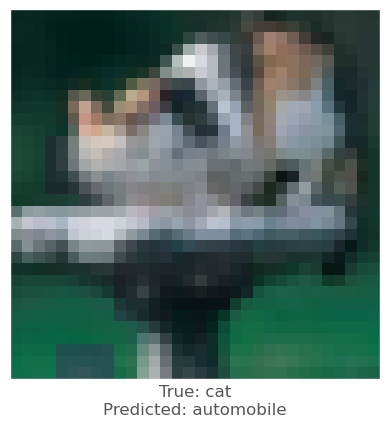


 lenet - image 4900 - 51 / 90
1/1 [==============================] - 0s 21ms/step


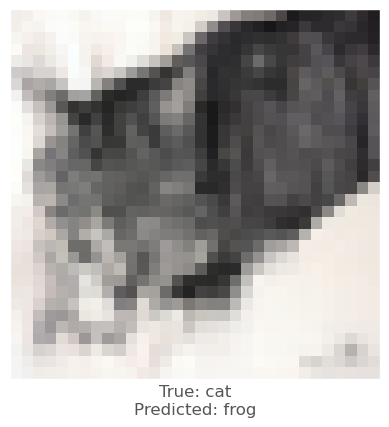


 lenet - image 2587 - 52 / 90
1/1 [==============================] - 0s 21ms/step


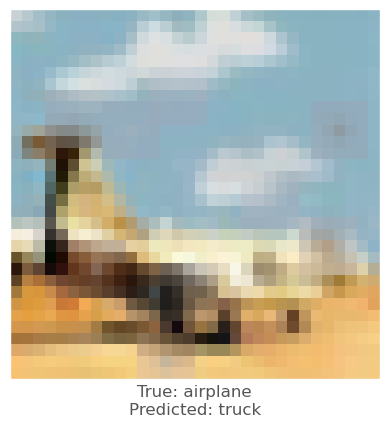


 lenet - image 5267 - 53 / 90
1/1 [==============================] - 0s 23ms/step


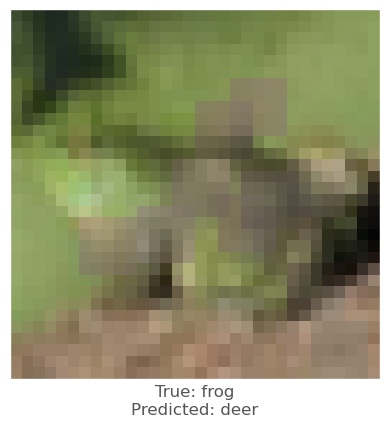


 lenet - image 1876 - 54 / 90
1/1 [==============================] - 0s 21ms/step


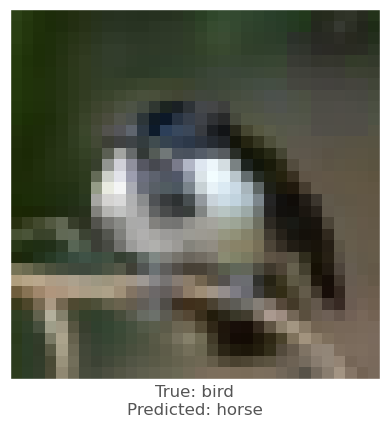


 lenet - image 7238 - 55 / 90
1/1 [==============================] - 0s 20ms/step


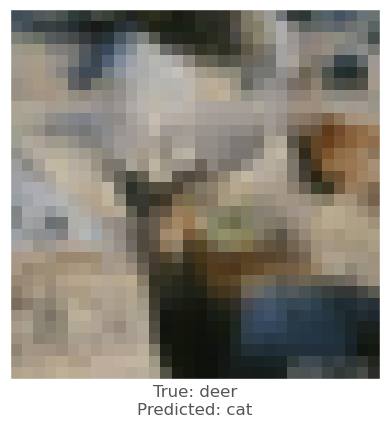


 lenet - image 1152 - 56 / 90
1/1 [==============================] - 0s 20ms/step


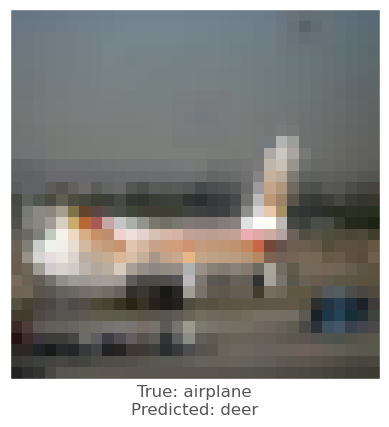


 lenet - image 1892 - 57 / 90
1/1 [==============================] - 0s 20ms/step


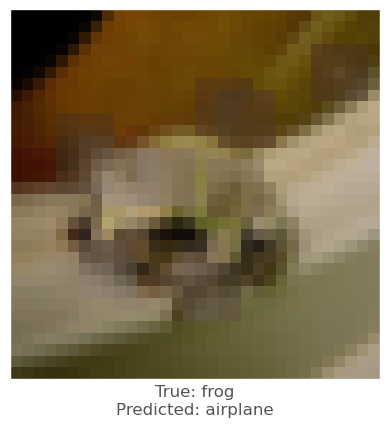


 lenet - image 1651 - 58 / 90
1/1 [==============================] - 0s 21ms/step


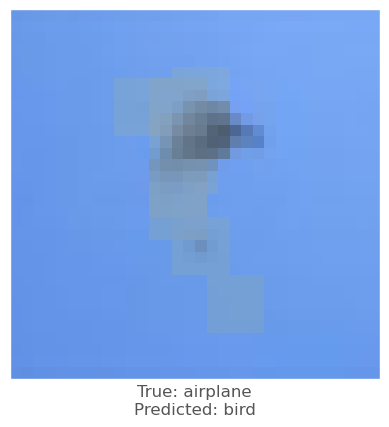


 lenet - image 2246 - 59 / 90
1/1 [==============================] - 0s 22ms/step


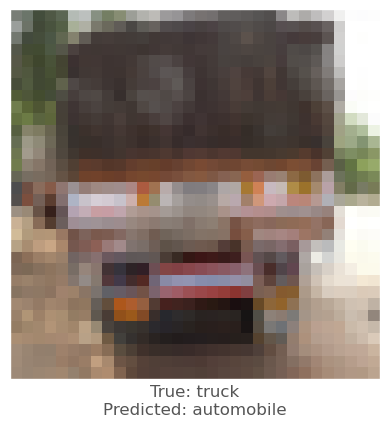


 lenet - image 0 - 60 / 90
1/1 [==============================] - 0s 23ms/step


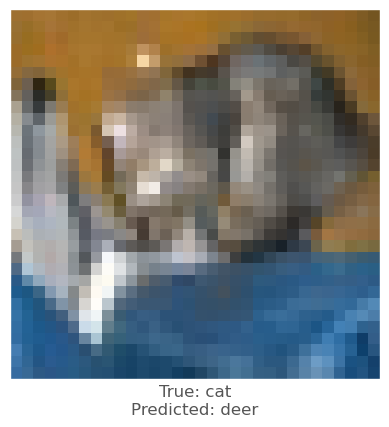


 lenet - image 3599 - 61 / 90
1/1 [==============================] - 0s 25ms/step


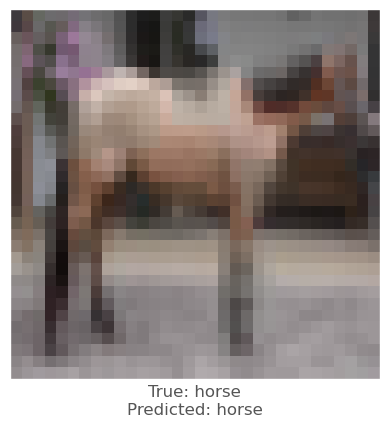


 lenet - image 8643 - 62 / 90
1/1 [==============================] - 0s 21ms/step


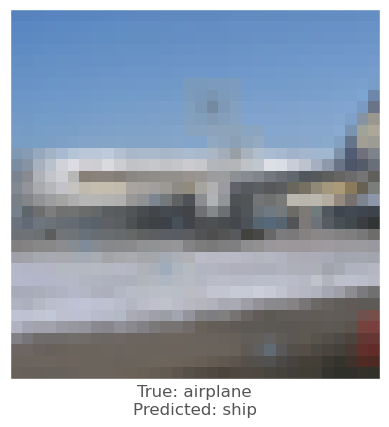


 lenet - image 8073 - 63 / 90
1/1 [==============================] - 0s 22ms/step


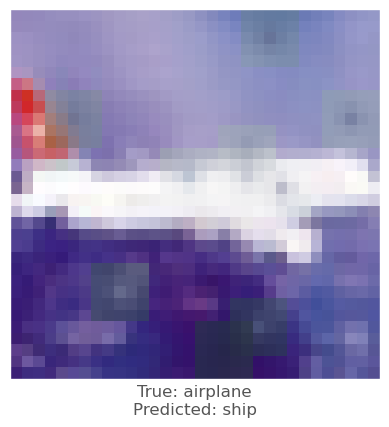


 lenet - image 1272 - 64 / 90
1/1 [==============================] - 0s 21ms/step


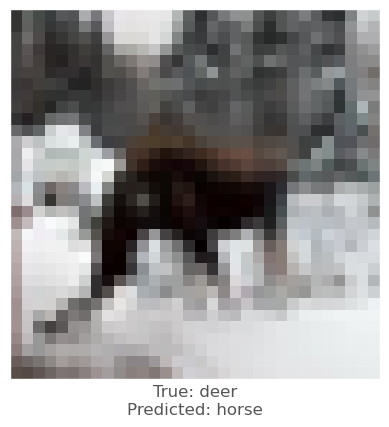


 lenet - image 4124 - 65 / 90
1/1 [==============================] - 0s 22ms/step


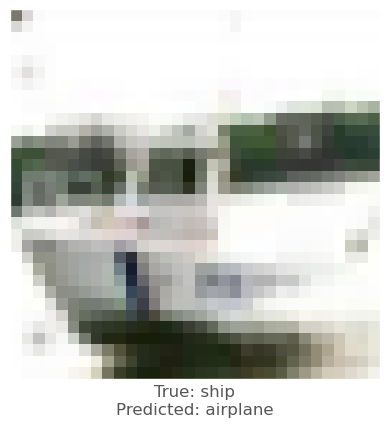


 lenet - image 1197 - 66 / 90
1/1 [==============================] - 0s 22ms/step


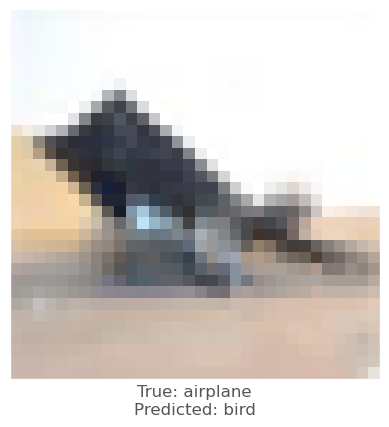


 lenet - image 8847 - 67 / 90
1/1 [==============================] - 0s 24ms/step


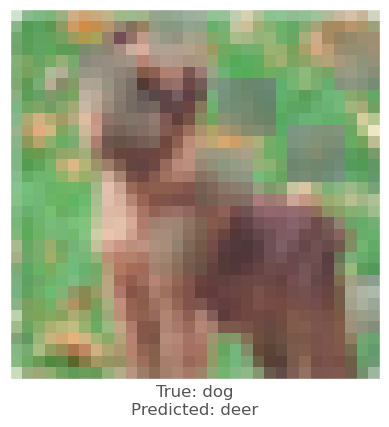


 lenet - image 3076 - 68 / 90
1/1 [==============================] - 0s 22ms/step


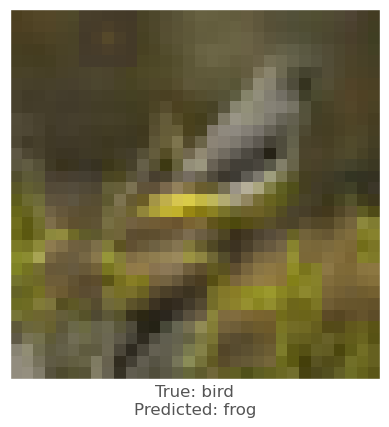


 lenet - image 6633 - 69 / 90
1/1 [==============================] - 0s 23ms/step


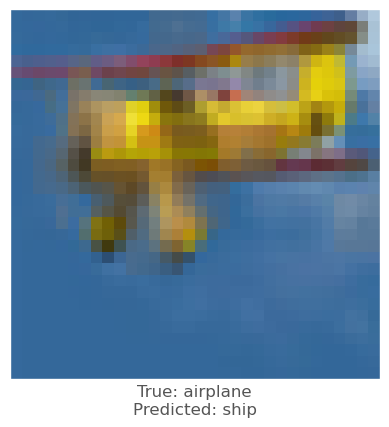


 lenet - image 331 - 70 / 90
1/1 [==============================] - 0s 22ms/step


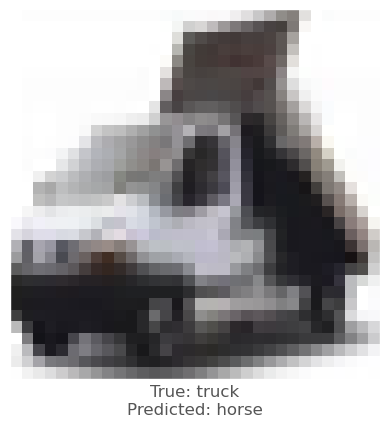


 lenet - image 4913 - 71 / 90
1/1 [==============================] - 0s 21ms/step


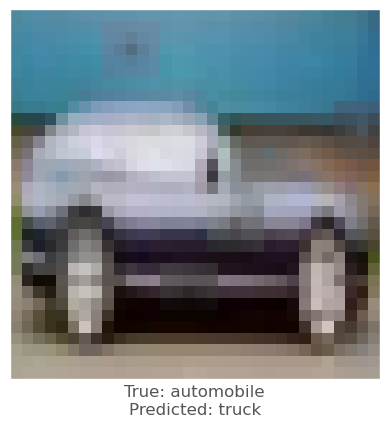


 lenet - image 8826 - 72 / 90
1/1 [==============================] - 0s 19ms/step


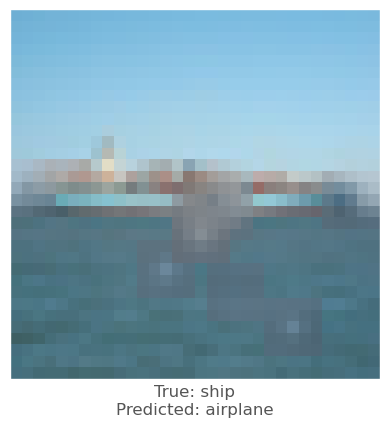


 lenet - image 5860 - 73 / 90
1/1 [==============================] - 0s 20ms/step


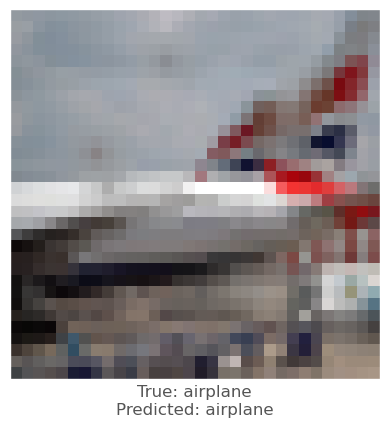


 lenet - image 1104 - 74 / 90
1/1 [==============================] - 0s 22ms/step


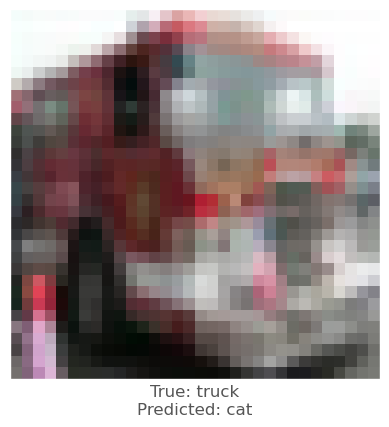


 lenet - image 6472 - 75 / 90
1/1 [==============================] - 0s 23ms/step


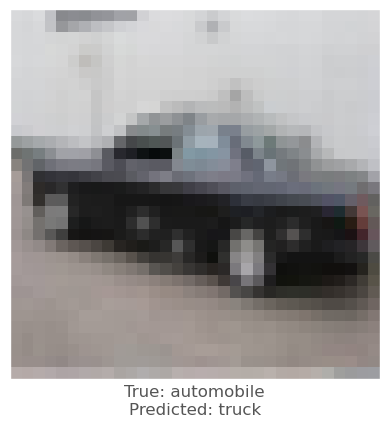


 lenet - image 9977 - 76 / 90
1/1 [==============================] - 0s 21ms/step


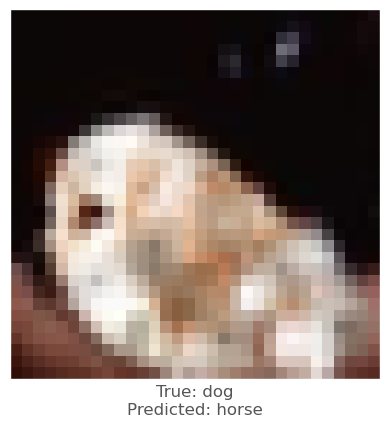


 lenet - image 4098 - 77 / 90
1/1 [==============================] - 0s 21ms/step


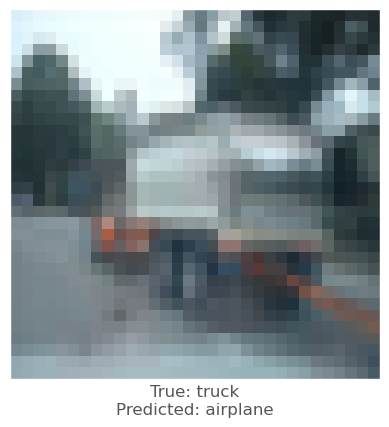


 lenet - image 5140 - 78 / 90
1/1 [==============================] - 0s 23ms/step


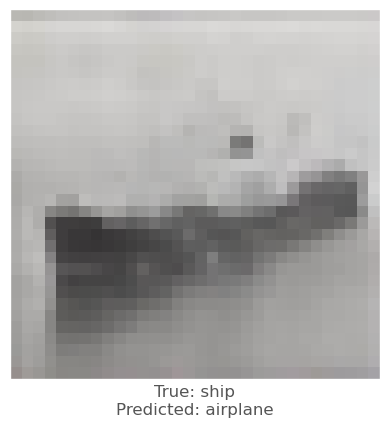


 lenet - image 8112 - 79 / 90
1/1 [==============================] - 0s 22ms/step


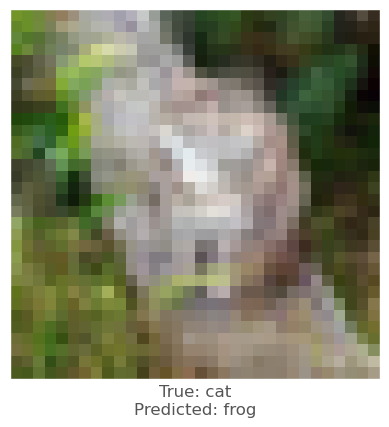


 lenet - image 5798 - 80 / 90
1/1 [==============================] - 0s 21ms/step


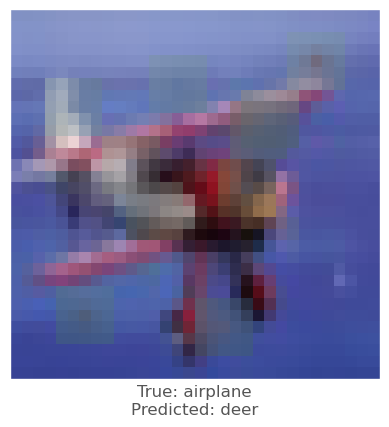


 lenet - image 7243 - 81 / 90
1/1 [==============================] - 0s 20ms/step


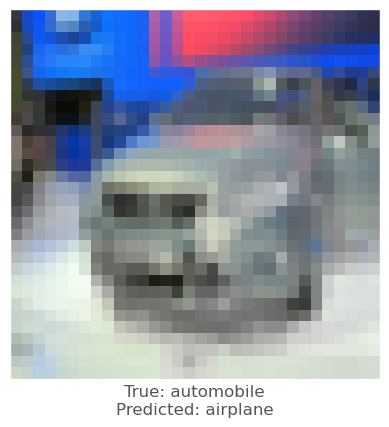


 lenet - image 673 - 82 / 90
1/1 [==============================] - 0s 20ms/step


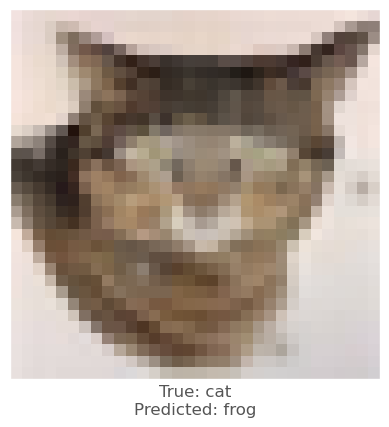


 lenet - image 6645 - 83 / 90
1/1 [==============================] - 0s 22ms/step


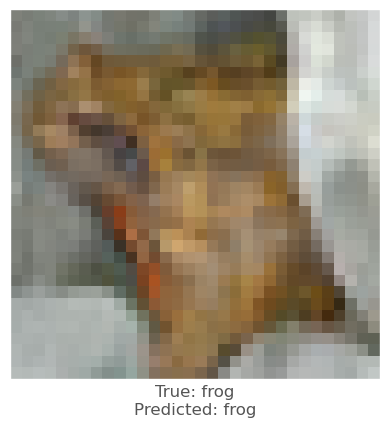


 lenet - image 7986 - 84 / 90
1/1 [==============================] - 0s 21ms/step


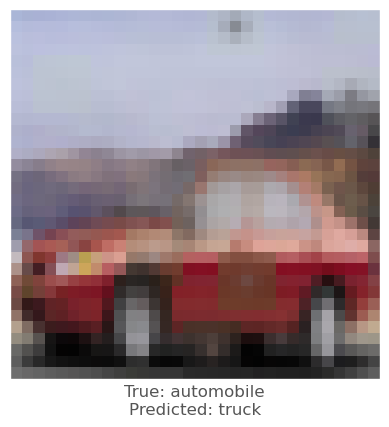


 lenet - image 3100 - 85 / 90
1/1 [==============================] - 0s 21ms/step


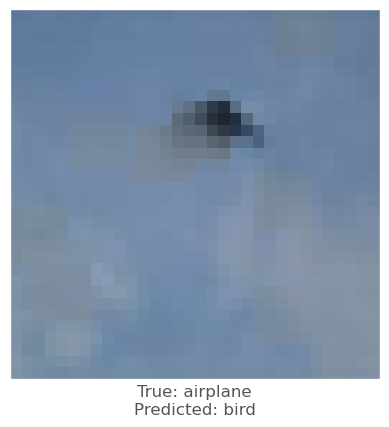


 lenet - image 7701 - 86 / 90
1/1 [==============================] - 0s 21ms/step


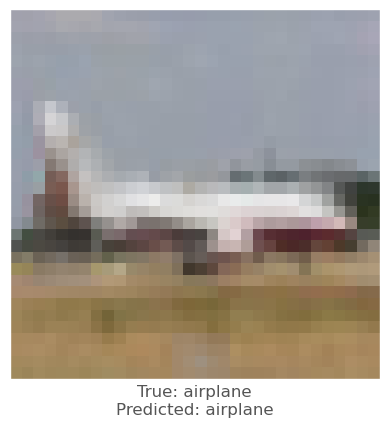


 lenet - image 8271 - 87 / 90
1/1 [==============================] - 0s 21ms/step


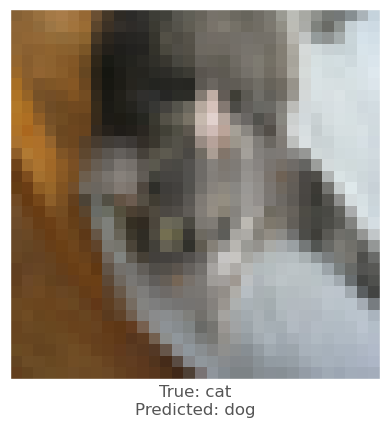


 lenet - image 172 - 88 / 90
1/1 [==============================] - 0s 21ms/step


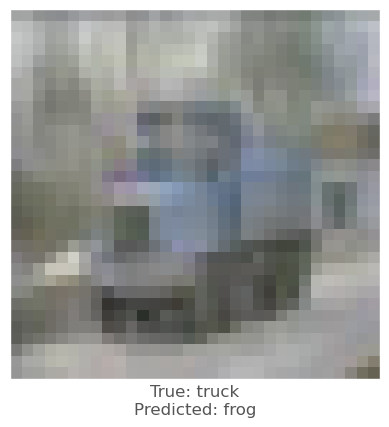


 lenet - image 6053 - 89 / 90
1/1 [==============================] - 0s 22ms/step


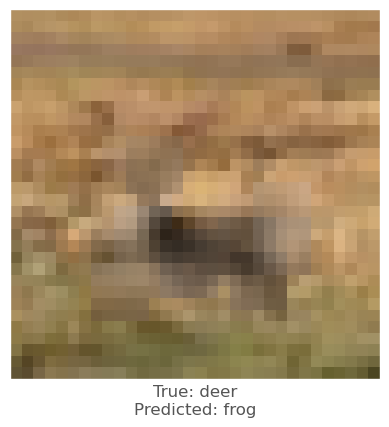


 lenet - image 7490 - 90 / 90
1/1 [==============================] - 0s 23ms/step


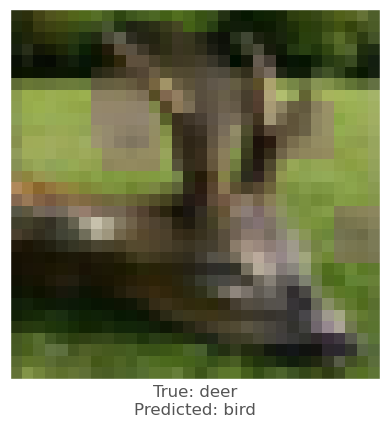


 lenet - image 9263 - 1 / 90
1/1 [==============================] - 0s 21ms/step


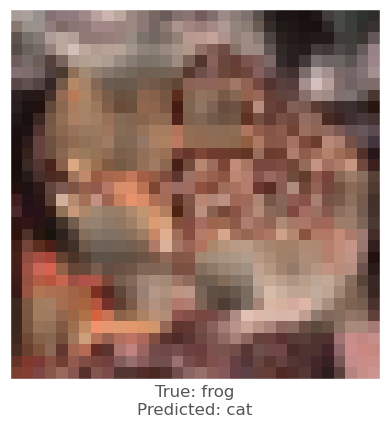


 lenet - image 6249 - 2 / 90
1/1 [==============================] - 0s 22ms/step


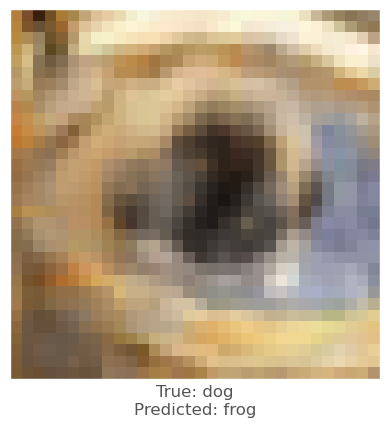


 lenet - image 3732 - 3 / 90
1/1 [==============================] - 0s 21ms/step


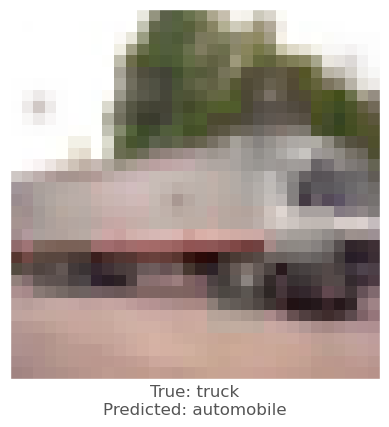


 lenet - image 8015 - 4 / 90
1/1 [==============================] - 0s 22ms/step


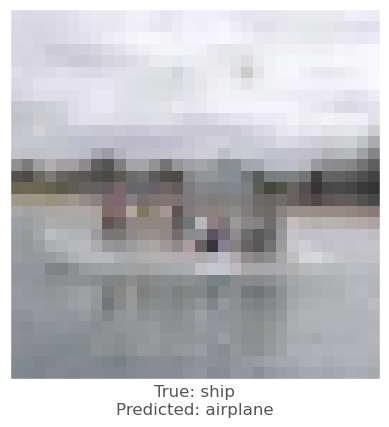


 lenet - image 4356 - 5 / 90
1/1 [==============================] - 0s 24ms/step


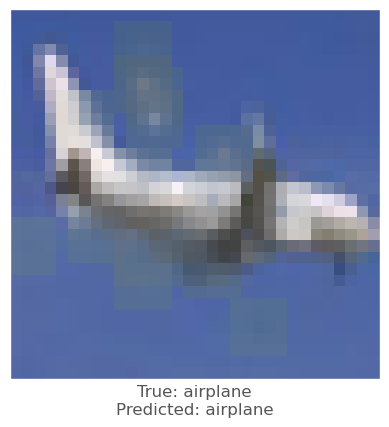


 lenet - image 4929 - 6 / 90
1/1 [==============================] - 0s 21ms/step


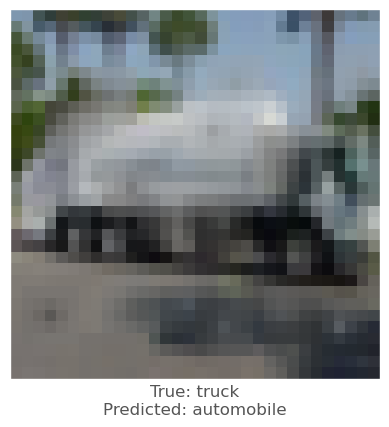


 lenet - image 2448 - 7 / 90
1/1 [==============================] - 0s 20ms/step


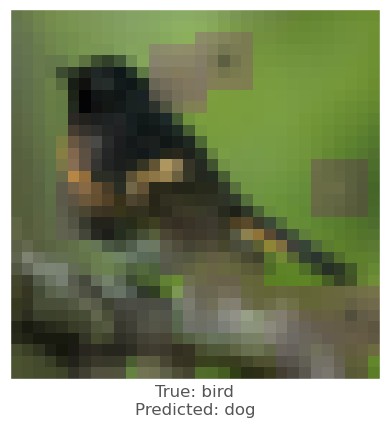


 lenet - image 1082 - 8 / 90
1/1 [==============================] - 0s 25ms/step


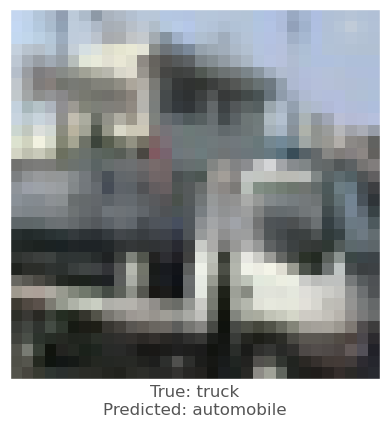


 lenet - image 6592 - 9 / 90
1/1 [==============================] - 0s 21ms/step


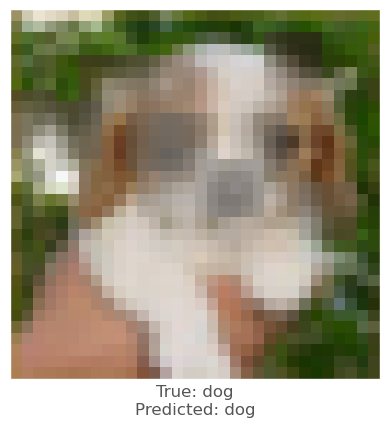


 lenet - image 8118 - 10 / 90
1/1 [==============================] - 0s 21ms/step


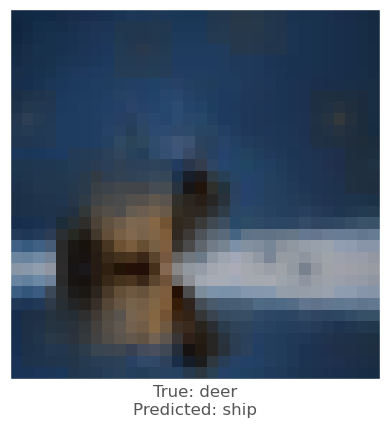


 lenet - image 4040 - 11 / 90
1/1 [==============================] - 0s 21ms/step


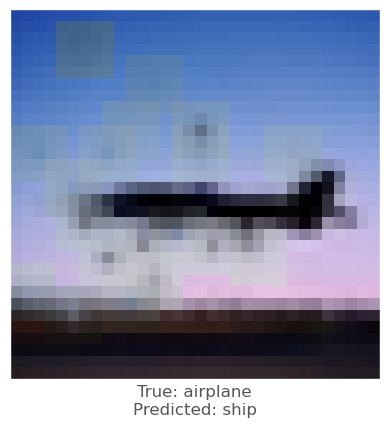


 lenet - image 4969 - 12 / 90
1/1 [==============================] - 0s 21ms/step


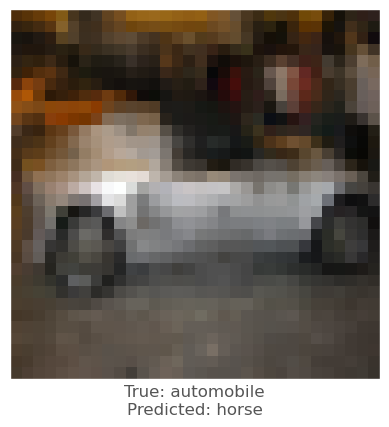


 lenet - image 4087 - 13 / 90
1/1 [==============================] - 0s 24ms/step


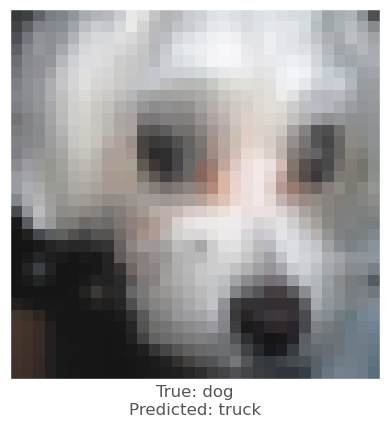


 lenet - image 1606 - 14 / 90
1/1 [==============================] - 0s 20ms/step


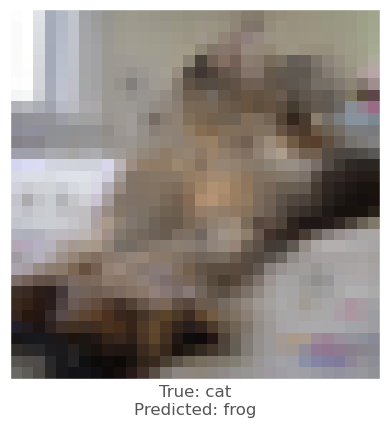


 lenet - image 8275 - 15 / 90
1/1 [==============================] - 0s 21ms/step


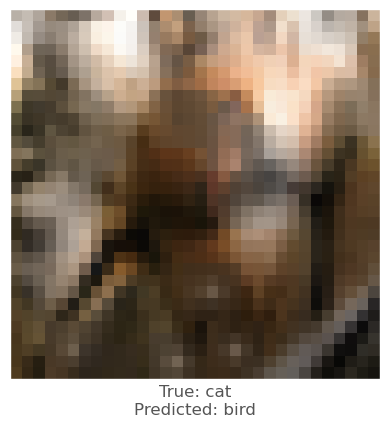


 lenet - image 4893 - 16 / 90
1/1 [==============================] - 0s 20ms/step


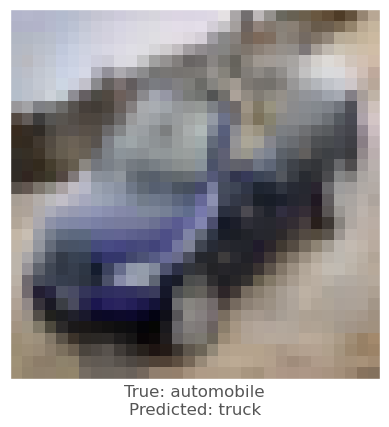


 lenet - image 6749 - 17 / 90
1/1 [==============================] - 0s 22ms/step


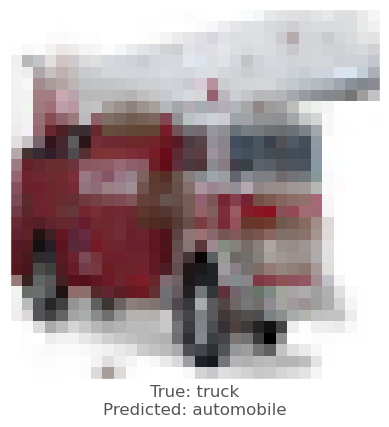


 lenet - image 1702 - 18 / 90
1/1 [==============================] - 0s 22ms/step


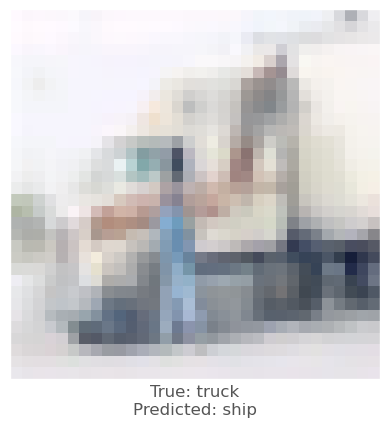


 lenet - image 662 - 19 / 90
1/1 [==============================] - 0s 23ms/step


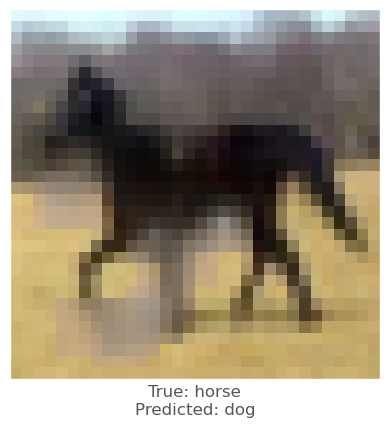


 lenet - image 379 - 20 / 90
1/1 [==============================] - 0s 21ms/step


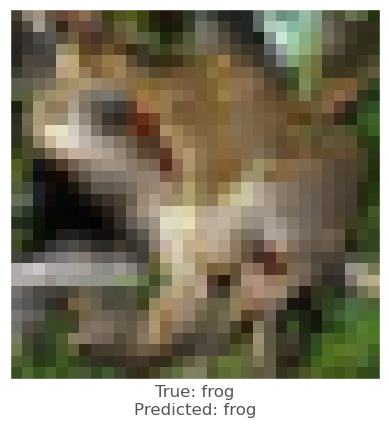


 lenet - image 8273 - 21 / 90
1/1 [==============================] - 0s 21ms/step


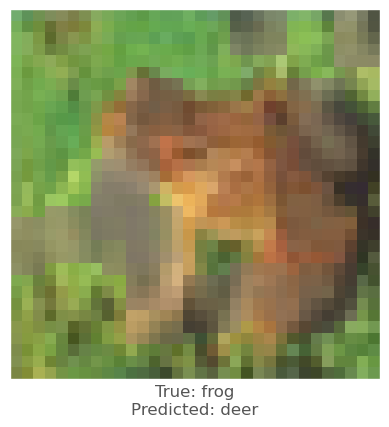


 lenet - image 7693 - 22 / 90
1/1 [==============================] - 0s 22ms/step


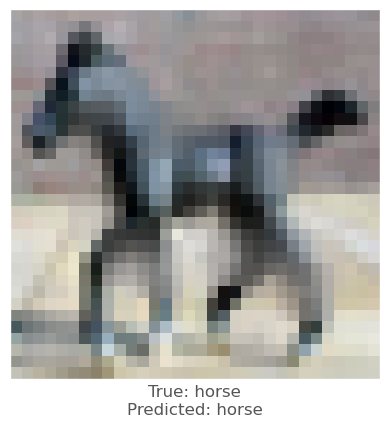


 lenet - image 8018 - 23 / 90
1/1 [==============================] - 0s 28ms/step


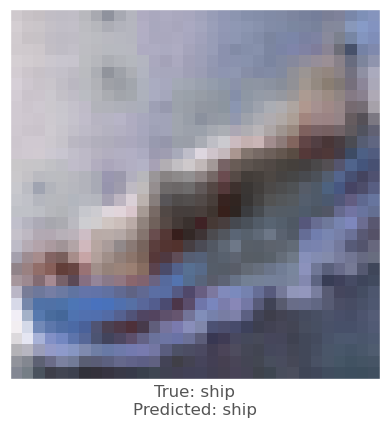


 lenet - image 1180 - 24 / 90
1/1 [==============================] - 0s 27ms/step


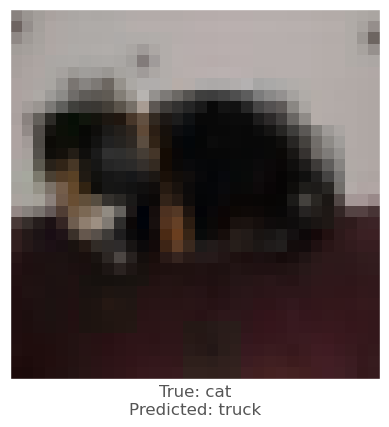


 lenet - image 5664 - 25 / 90
1/1 [==============================] - 0s 22ms/step


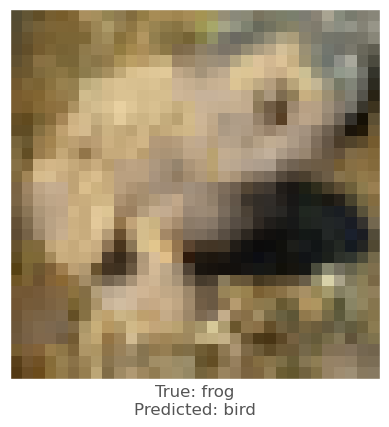


 lenet - image 4016 - 26 / 90
1/1 [==============================] - 0s 22ms/step


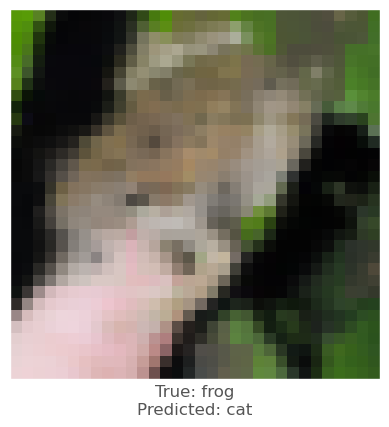


 lenet - image 6744 - 27 / 90
1/1 [==============================] - 0s 24ms/step


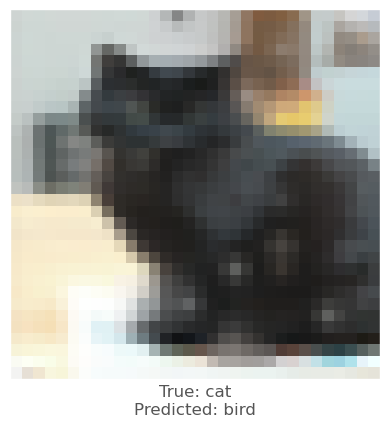


 lenet - image 3535 - 28 / 90
1/1 [==============================] - 0s 21ms/step


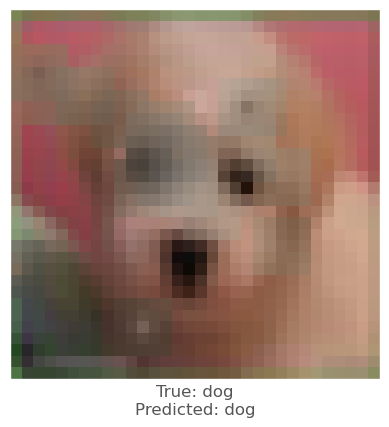


 lenet - image 8640 - 29 / 90
1/1 [==============================] - 0s 22ms/step


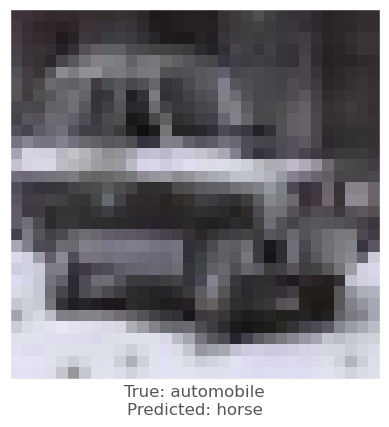


 lenet - image 6740 - 30 / 90
1/1 [==============================] - 0s 22ms/step


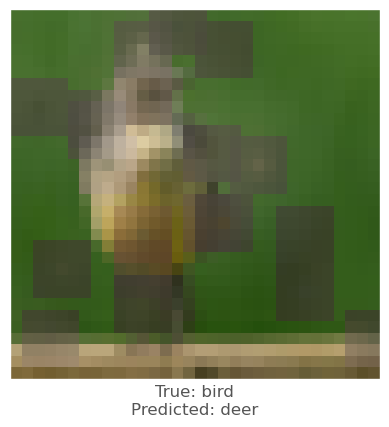


 lenet - image 7166 - 31 / 90
1/1 [==============================] - 0s 21ms/step


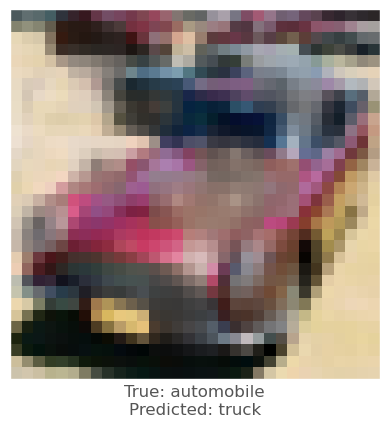


 lenet - image 2429 - 32 / 90
1/1 [==============================] - 0s 23ms/step


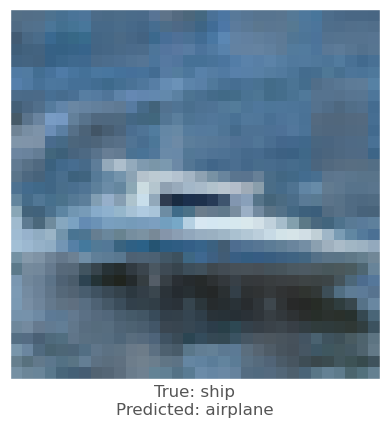


 lenet - image 9651 - 33 / 90
1/1 [==============================] - 0s 22ms/step


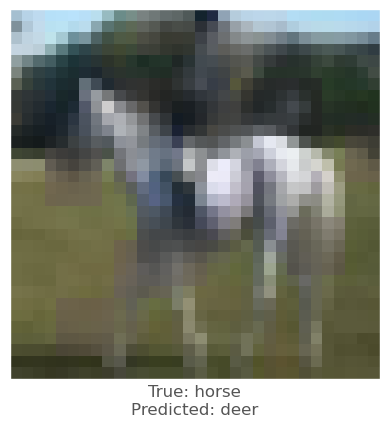


 lenet - image 3389 - 34 / 90
1/1 [==============================] - 0s 22ms/step


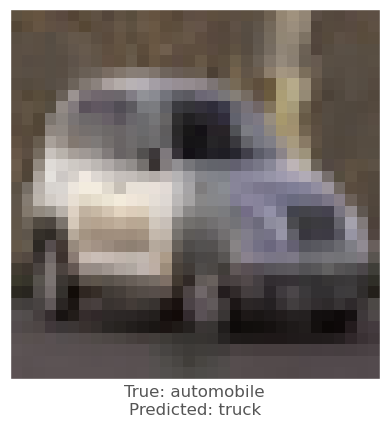


 lenet - image 5295 - 35 / 90
1/1 [==============================] - 0s 23ms/step


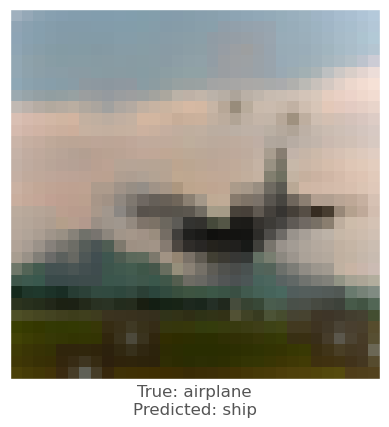


 lenet - image 3796 - 36 / 90
1/1 [==============================] - 0s 26ms/step


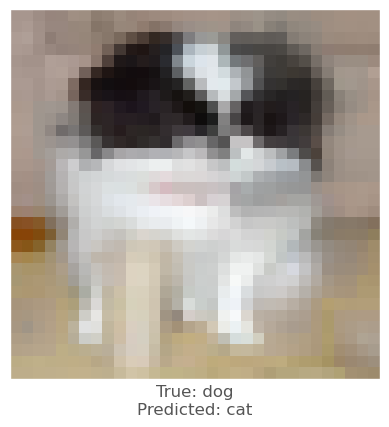


 lenet - image 7563 - 37 / 90
1/1 [==============================] - 0s 22ms/step


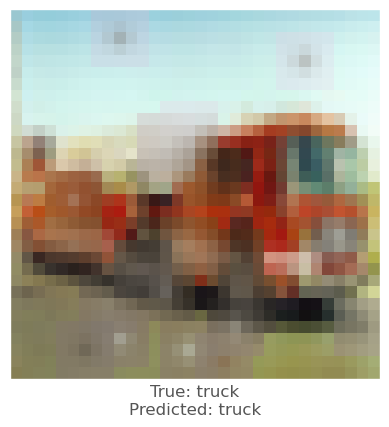


 lenet - image 2802 - 38 / 90
1/1 [==============================] - 0s 22ms/step


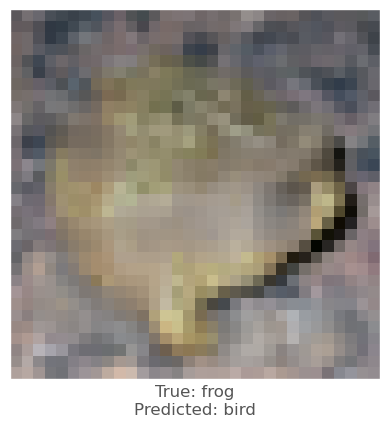


 lenet - image 5631 - 39 / 90
1/1 [==============================] - 0s 23ms/step


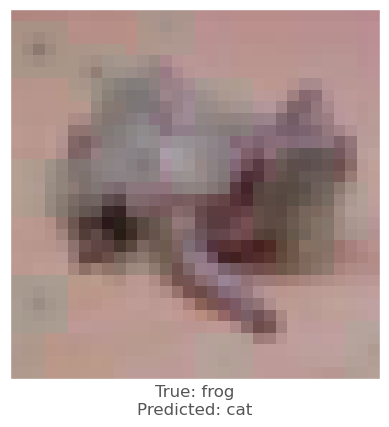


 lenet - image 7277 - 40 / 90
1/1 [==============================] - 0s 24ms/step


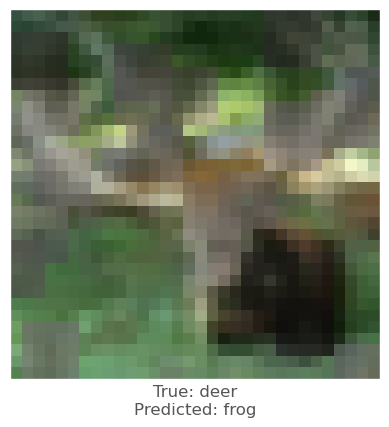


 lenet - image 5929 - 41 / 90
1/1 [==============================] - 0s 20ms/step


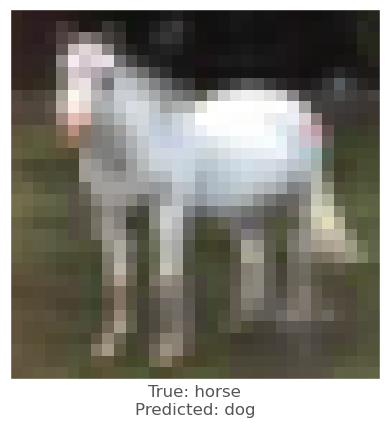


 lenet - image 8661 - 42 / 90
1/1 [==============================] - 0s 23ms/step


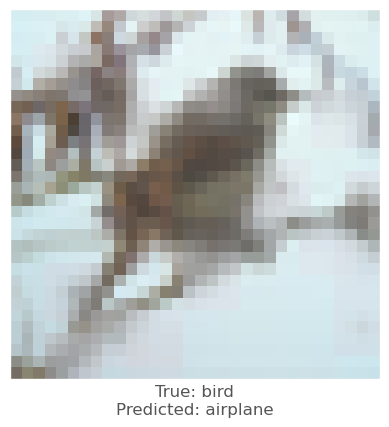


 lenet - image 7140 - 43 / 90
1/1 [==============================] - 0s 22ms/step


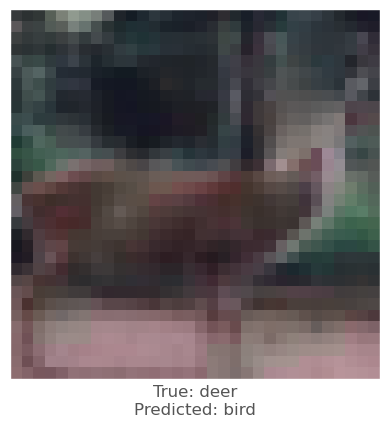


 lenet - image 1390 - 44 / 90
1/1 [==============================] - 0s 22ms/step


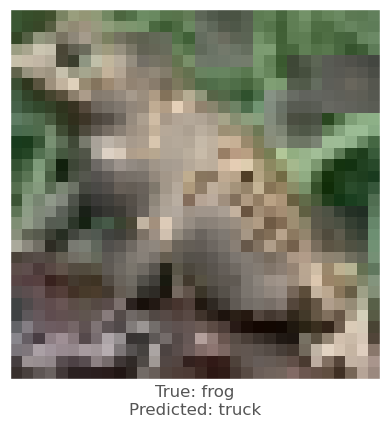


 lenet - image 6657 - 45 / 90
1/1 [==============================] - 0s 21ms/step


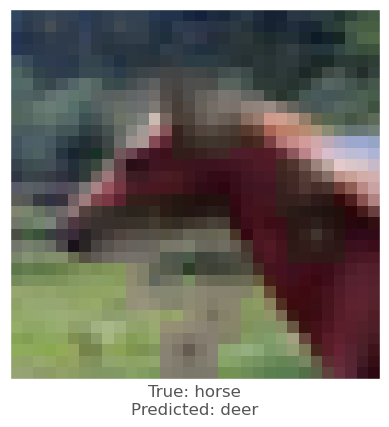


 lenet - image 9363 - 46 / 90
1/1 [==============================] - 0s 22ms/step


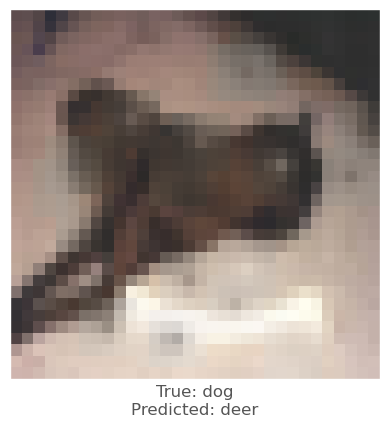


 lenet - image 6539 - 47 / 90
1/1 [==============================] - 0s 21ms/step


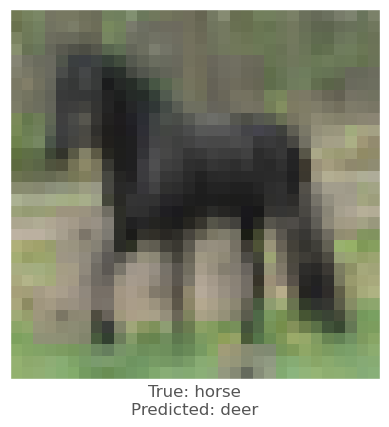


 lenet - image 2329 - 48 / 90
1/1 [==============================] - 0s 21ms/step


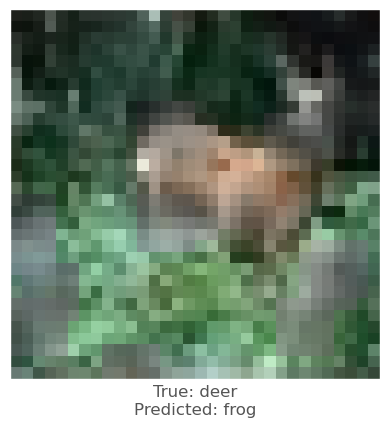


 lenet - image 2340 - 49 / 90
1/1 [==============================] - 0s 25ms/step


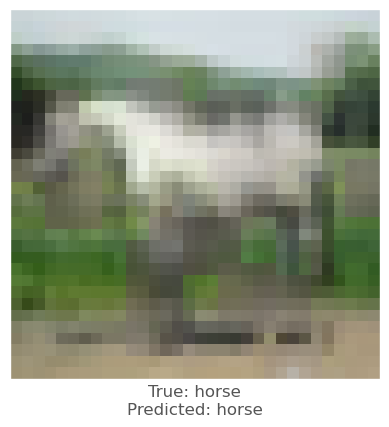


 lenet - image 7370 - 50 / 90
1/1 [==============================] - 0s 23ms/step


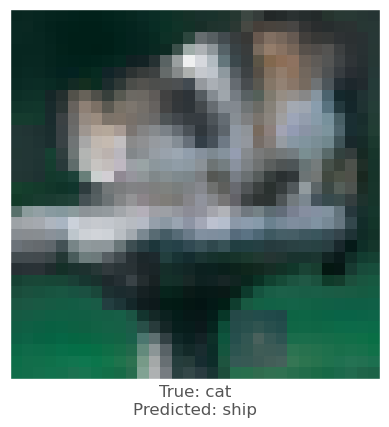


 lenet - image 4900 - 51 / 90
1/1 [==============================] - 0s 23ms/step


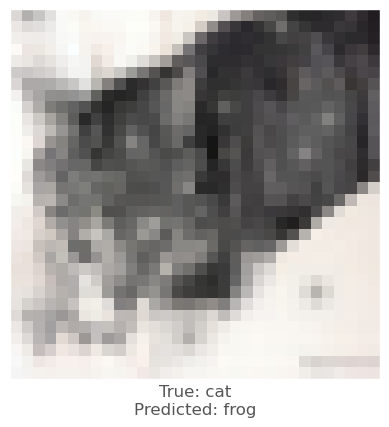


 lenet - image 2587 - 52 / 90
1/1 [==============================] - 0s 23ms/step


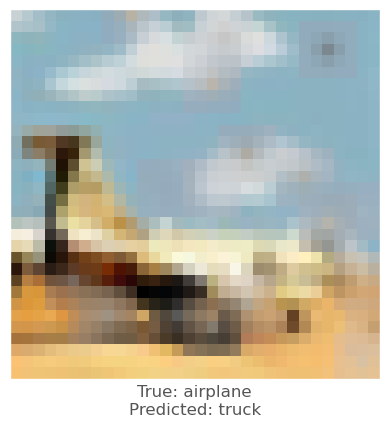


 lenet - image 5267 - 53 / 90
1/1 [==============================] - 0s 21ms/step


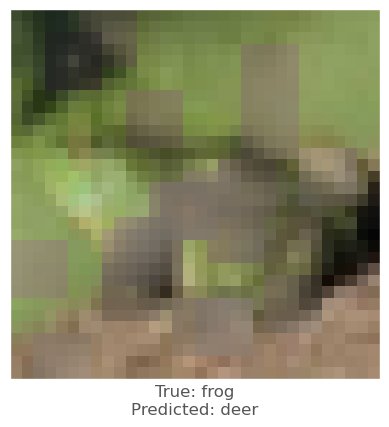


 lenet - image 1876 - 54 / 90
1/1 [==============================] - 0s 32ms/step


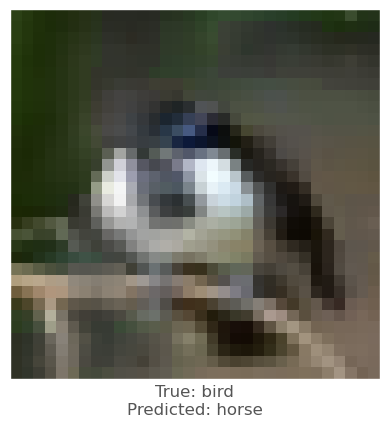


 lenet - image 7238 - 55 / 90
1/1 [==============================] - 0s 21ms/step


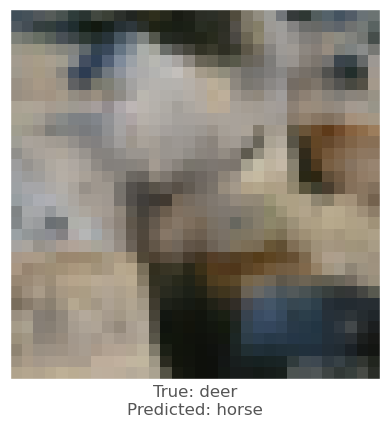


 lenet - image 1152 - 56 / 90
1/1 [==============================] - 0s 21ms/step


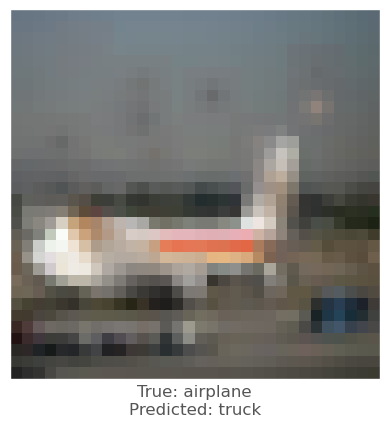


 lenet - image 1892 - 57 / 90
1/1 [==============================] - 0s 21ms/step


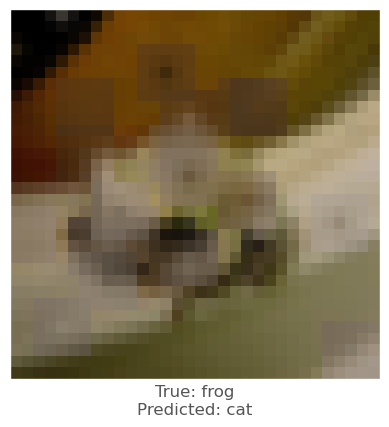


 lenet - image 1651 - 58 / 90
1/1 [==============================] - 0s 27ms/step


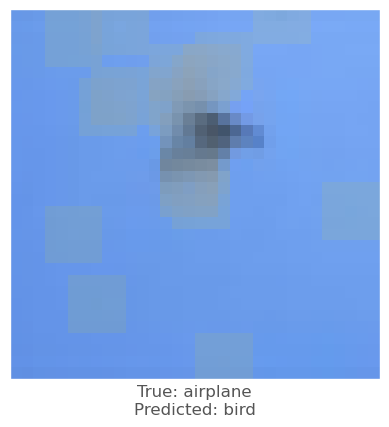


 lenet - image 2246 - 59 / 90
1/1 [==============================] - 0s 25ms/step


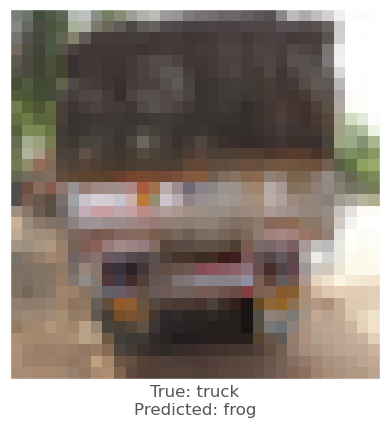


 lenet - image 0 - 60 / 90
1/1 [==============================] - 0s 23ms/step


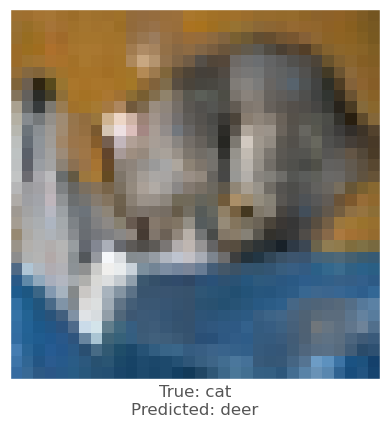


 lenet - image 3599 - 61 / 90
1/1 [==============================] - 0s 21ms/step


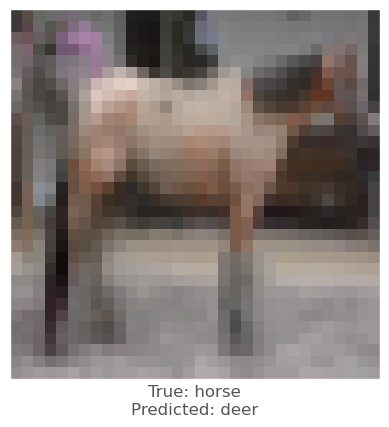


 lenet - image 8643 - 62 / 90
1/1 [==============================] - 0s 21ms/step


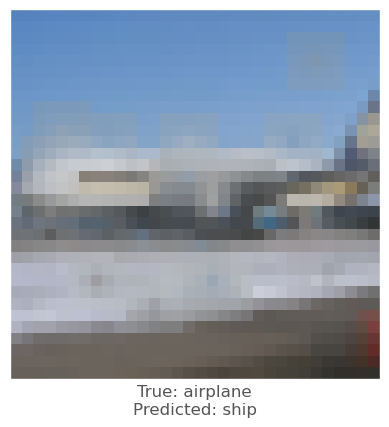


 lenet - image 8073 - 63 / 90
1/1 [==============================] - 0s 24ms/step


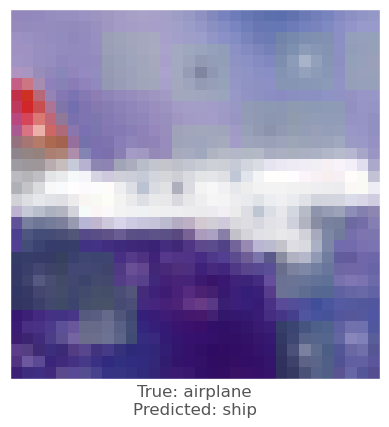


 lenet - image 1272 - 64 / 90
1/1 [==============================] - 0s 21ms/step


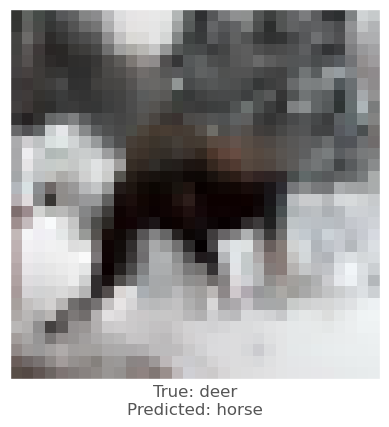


 lenet - image 4124 - 65 / 90
1/1 [==============================] - 0s 22ms/step


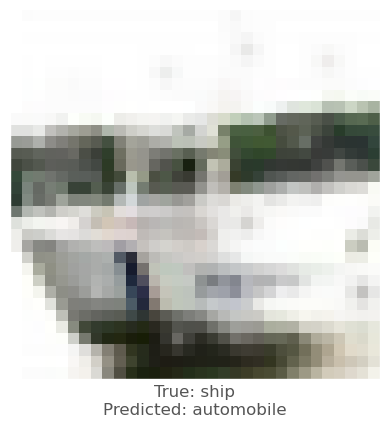


 lenet - image 1197 - 66 / 90
1/1 [==============================] - 0s 23ms/step


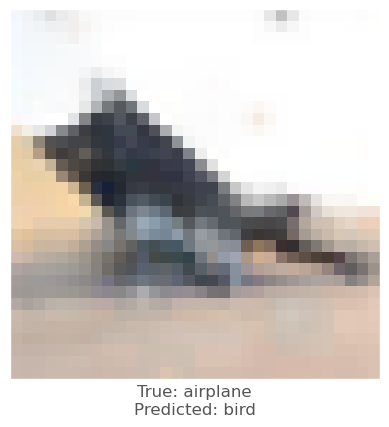


 lenet - image 8847 - 67 / 90
1/1 [==============================] - 0s 23ms/step


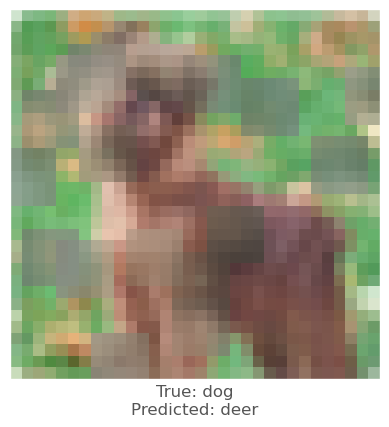


 lenet - image 3076 - 68 / 90
1/1 [==============================] - 0s 22ms/step


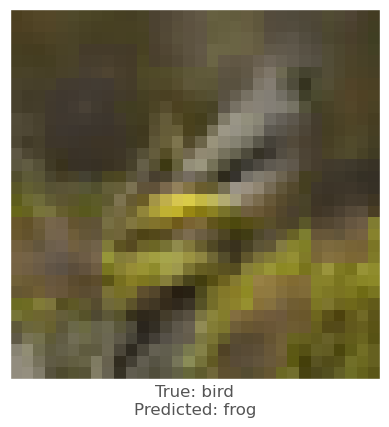


 lenet - image 6633 - 69 / 90
1/1 [==============================] - 0s 21ms/step


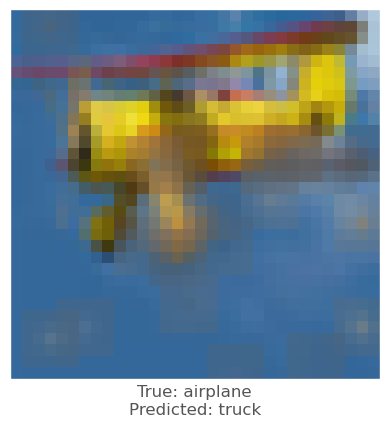


 lenet - image 331 - 70 / 90
1/1 [==============================] - 0s 22ms/step


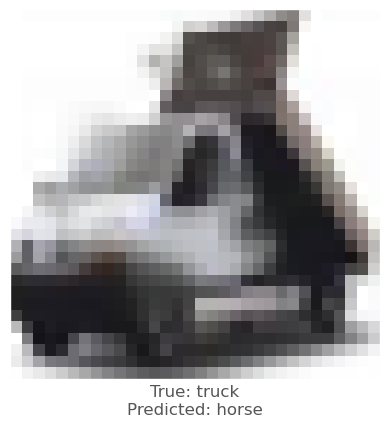


 lenet - image 4913 - 71 / 90
1/1 [==============================] - 0s 22ms/step


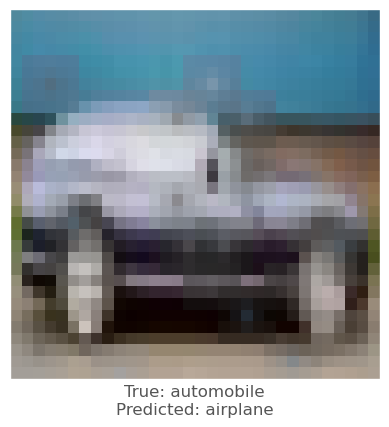


 lenet - image 8826 - 72 / 90
1/1 [==============================] - 0s 22ms/step


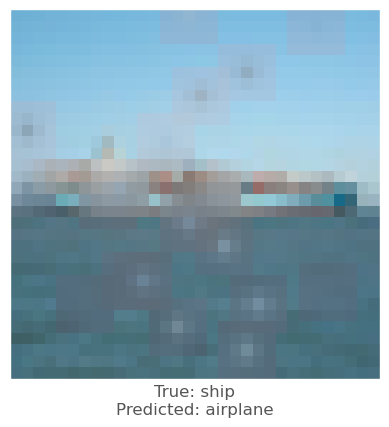


 lenet - image 5860 - 73 / 90
1/1 [==============================] - 0s 22ms/step


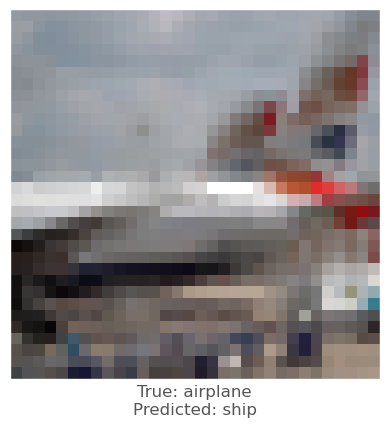


 lenet - image 1104 - 74 / 90
1/1 [==============================] - 0s 24ms/step


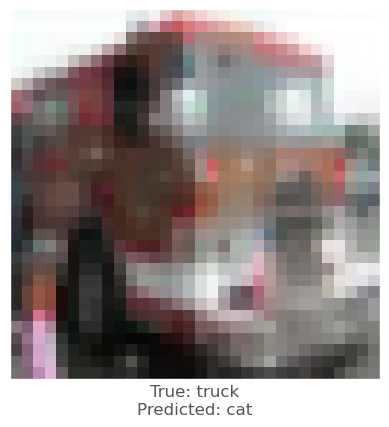


 lenet - image 6472 - 75 / 90
1/1 [==============================] - 0s 22ms/step


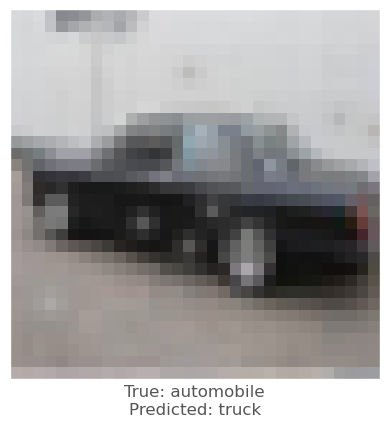


 lenet - image 9977 - 76 / 90
1/1 [==============================] - 0s 23ms/step


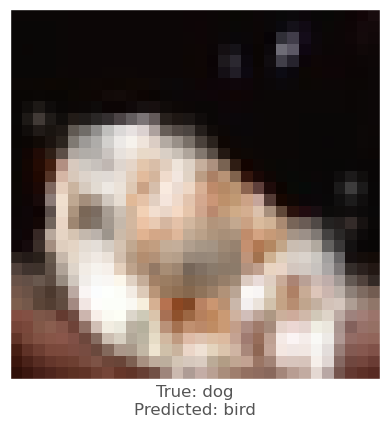


 lenet - image 4098 - 77 / 90
1/1 [==============================] - 0s 21ms/step


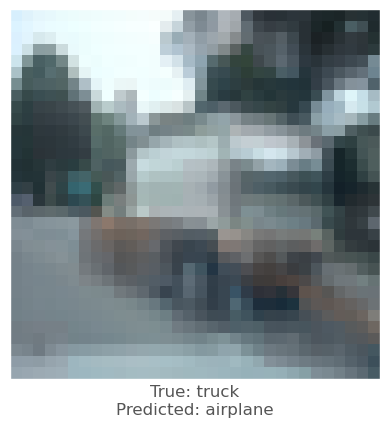


 lenet - image 5140 - 78 / 90
1/1 [==============================] - 0s 22ms/step


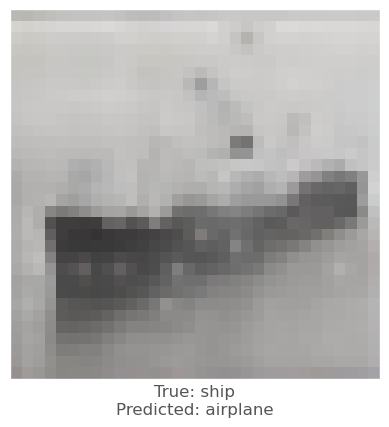


 lenet - image 8112 - 79 / 90
1/1 [==============================] - 0s 22ms/step


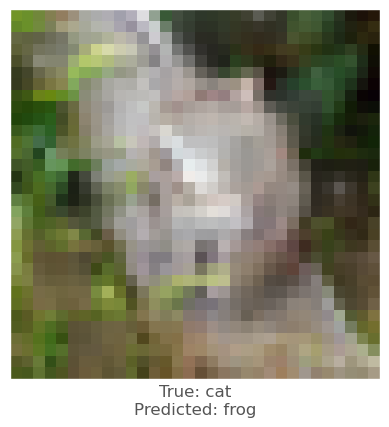


 lenet - image 5798 - 80 / 90
1/1 [==============================] - 0s 21ms/step


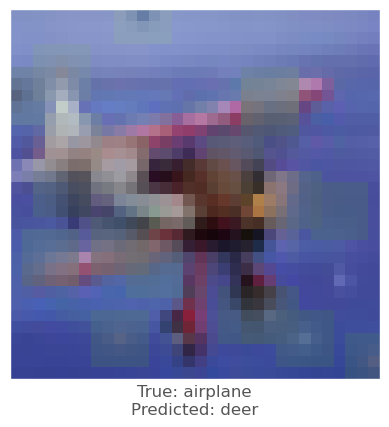


 lenet - image 7243 - 81 / 90
1/1 [==============================] - 0s 23ms/step


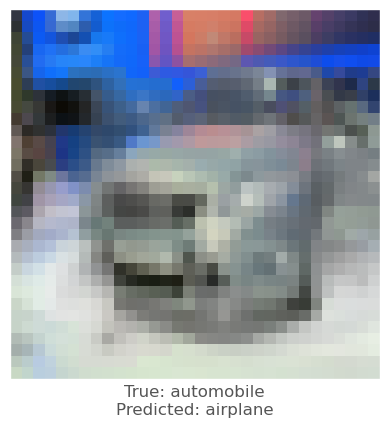


 lenet - image 673 - 82 / 90
1/1 [==============================] - 0s 25ms/step


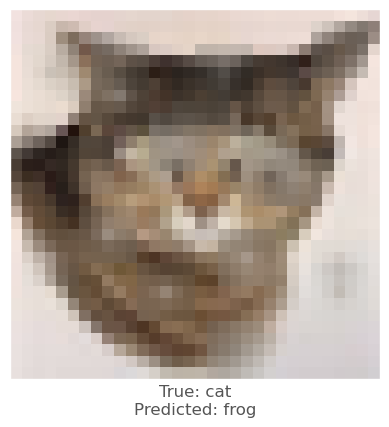


 lenet - image 6645 - 83 / 90
1/1 [==============================] - 0s 24ms/step


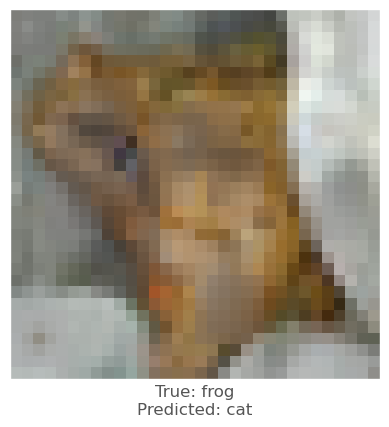


 lenet - image 7986 - 84 / 90
1/1 [==============================] - 0s 25ms/step


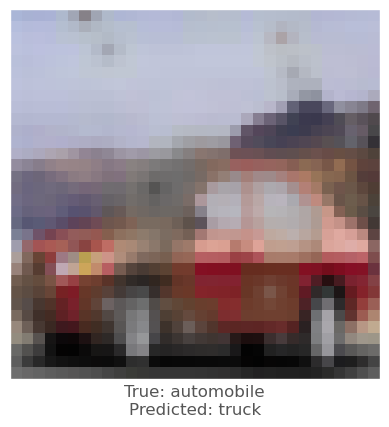


 lenet - image 3100 - 85 / 90
1/1 [==============================] - 0s 23ms/step


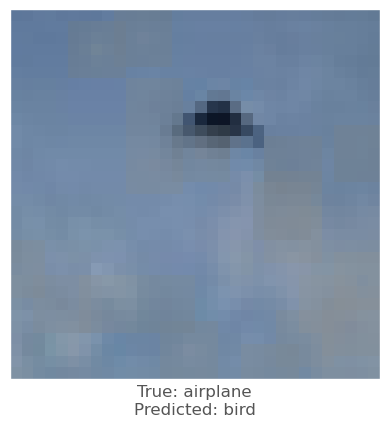


 lenet - image 7701 - 86 / 90
1/1 [==============================] - 0s 23ms/step


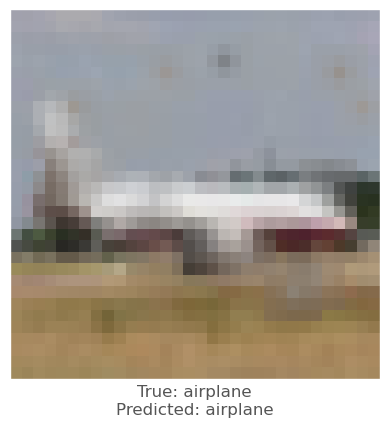


 lenet - image 8271 - 87 / 90
1/1 [==============================] - 0s 25ms/step


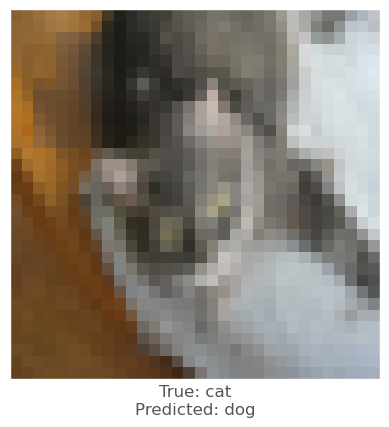


 lenet - image 172 - 88 / 90
1/1 [==============================] - 0s 21ms/step


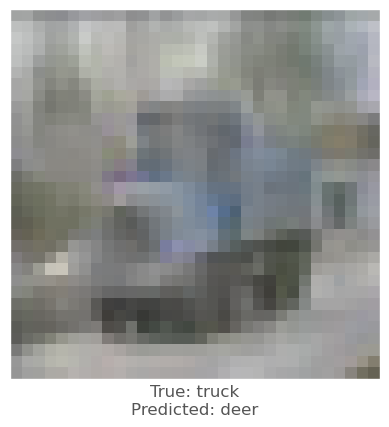


 lenet - image 6053 - 89 / 90
1/1 [==============================] - 0s 21ms/step


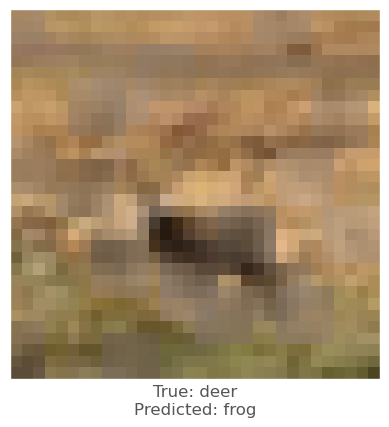


 lenet - image 7490 - 90 / 90
1/1 [==============================] - 0s 22ms/step


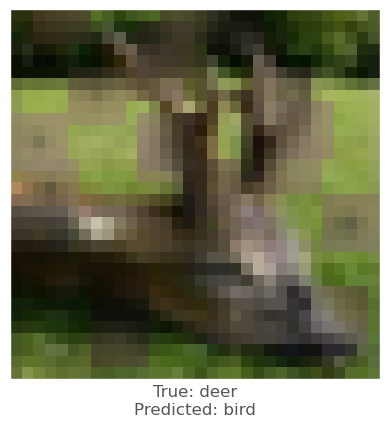

In [12]:
untargeted = attack_all(models, samples=90, targeted=False)

In [13]:
# Find the number of columns in the first row of the data
num_columns = len(untargeted[0])

# Create a list of column names
columns = ['model', 'pixels', 'image', 'true', 'predicted', 'success', 'cdiff', 'prior_probs', 'predicted_probs', 'perturbation']

# If the number of columns in the data is greater than the length of the `columns` list, add 'extra_column_i' for each extra column
for i in range(len(columns), num_columns):
    columns.append(f'extra_column_{i}')

# Create the DataFrame with the updated `columns` list
untargeted_results = pd.DataFrame(untargeted, columns=columns)

In [14]:
helper.attack_stats(untargeted_results, models, network_stats)

model  accuracy  pixels  attack_success_rate
0  lenet    0.7488       1             0.233333
1  lenet    0.7488      10             0.788889
2  lenet    0.7488      20             0.900000
3  lenet    0.7488       5             0.800000